In [ ]:
pip install pycbc

     |████████████████████████████████| 6.7 MB 7.4 MB/s 
     |████████████████████████████████| 1.4 MB 56.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 46.3 MB 40.3 MB/s 
     |████████████████████████████████| 45 kB 2.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 7.4 MB/s 
     |████████████████████████████████| 201 kB 83.7 MB/s 
     |████████████████████████████████| 7.3 MB 28.5 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
     |████████████████████████████████| 295 kB 72.6 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ...

In [ ]:
from pycbc.catalog import Merger
#import pycbc
import scipy.constants as cnt
from scipy.stats import chisquare
import numpy as np
from numpy.ma.core import argmax
import pandas as pd
from google.colab import files
from math import pi
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
plt.rcParams.update({
    'figure.dpi': 200,
    'figure.figsize': (4, 3),
})
plt.rcParams.update({'font.size': 8})
cmap = plt.cm.get_cmap('Spectral')
M_sun = 1.989*10**30

print("All requirements setup")

All requirements setup


In [ ]:
'''
Generate Fake Noise and Inject a signal in it
'''
import pycbc.noise, pycbc.psd
import pylab,random,numpy
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pycbc.waveform import get_td_waveform, taper_timeseries
from pycbc.detector import Detector
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.pnutils import nearest_larger_binary_number
from pycbc import DYN_RANGE_FAC
from pycbc.filter import sigma
import logging
from pycbc import frame
import warnings
warnings.filterwarnings("ignore")

colors = ["#2CBDEF", '#9D2EC5', '#EC1C4B', '#355C7D']

import seaborn as sns
sns.set_context('talk') 
sns.set_palette('colorblind')
sns.set_style('ticks')

pylab.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'font.size':8,
        'legend.fontsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

pylab.rcParams['axes.linewidth'] = 1

log_level = logging.INFO
logging.basicConfig(level=log_level,
                    format='%(asctime)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

def make_padded_frequency_series(vec, filter_N=None, delta_f=None):
    logging.info("Generating frequency domain version of the waveform")
    if filter_N is None:
        power = ceil(log(len(vec), 2)) + 1
        N = 2 ** power
    else:
        N = filter_N
    n = N // 2 + 1

    if isinstance(vec, FrequencySeries):
        vectilde = FrequencySeries(zeros(n, dtype=complex_same_precision_as(vec)),
                                   delta_f=1.0, copy=False)
        if len(vectilde) < len(vec):
            cplen = len(vectilde)
        else:
            cplen = len(vec)
        vectilde[0:cplen] = vec[0:cplen]
        delta_f = vec.delta_f

    elif isinstance(vec, TimeSeries):
        curr_length = len(vec)
        new_length = int(nearest_larger_binary_number(curr_length))
        while new_length * vec.delta_t < 1./delta_f:
            new_length = new_length * 2
        vec.resize(new_length)

        v_tilde = vec.to_frequencyseries()
        i_delta_f = v_tilde.get_delta_f()
        v_tilde = v_tilde.numpy()
        df_ratio = int(delta_f / i_delta_f)
        n_freq_len = int((n-1) * df_ratio +1)
        assert(n <= len(v_tilde))
        df_ratio = int(delta_f / i_delta_f)
        v_tilde = v_tilde[:n_freq_len:df_ratio]
        vectilde = FrequencySeries(v_tilde, delta_f=delta_f, dtype=np.complex64)

    return FrequencySeries(vectilde * DYN_RANGE_FAC, delta_f=delta_f,
                           dtype=np.complex128)

def get_timeseries(mchirp_low, 
                   mchirq_high, 
                   min_mratio, 
                   max_mratio,
                   min_snr,
                   max_snr,
                   min_eccentricity,
                   max_eccentricity,
                   case,
                   get_image,
                   get_strain_zoom):
    
    logging.info("Generating Fake Strain")
    noise_l = 256
    flow = 10.0
    delta_f = 1.0 / noise_l
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, delta_f, flow)

    # Generate 64 seconds of noise at 4096 Hz
    seed = random.randint(10, 200)
    random.seed(seed)
    delta_t = 1.0 / 4096
    tsamples = int(noise_l / delta_t)
    ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=seed)
    if get_image:
        pylab.figure(figsize=(15,3))
        pylab.grid(zorder=1)
        pylab.plot(ts.sample_times, ts, color=colors[2],zorder=2)
        pylab.ylabel('Strain')
        pylab.xlabel('Time (s)')
        pylab.show()
    
    # Make life hell 
    mchirp = random.uniform(mchirp_low, 
                            mchirq_high)
    
    q = random.uniform(min_mratio, 
                       max_mratio)
    
    optimal_snr = random.randint(min_snr, 
                                 max_snr)
    
    eccentricity = random.uniform(min_eccentricity, 
                                  max_eccentricity)

    # NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
    #       coa_phase runs from 0 to 2 pi.    
    inclination = random.uniform(0, numpy.pi)
    coa_phase = random.uniform(0, numpy.pi)

    
    declination  = random.uniform(0, numpy.pi)
    right_ascension = random.uniform(0, numpy.pi)
    polarization = random.uniform(0, numpy.pi)
    
    # Don't change the end_time otherwise the signal will be 
    # injected outside the region of generated noise
    end_time = random.randint(10,25)
    
    logging.info('Generating waveform')
    mass1 = mass1_from_mchirp_q(mchirp, q)
    mass2 = mass2_from_mchirp_q(mchirp, q)
    
    apx = 'EccentricTD'
    hp, hc = get_td_waveform(approximant=apx,
                             mass1=mass1,
                             mass2=mass1,
                             eccentricity = eccentricity,
                             inclination = inclination,
                             coa_phase = coa_phase,
                             delta_t = delta_t,
                             f_lower = 10)

    det_h1 = Detector('H1')
    signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
    
    if get_image:
        pylab.figure(figsize=(15,3))
        pylab.grid(zorder=1)
        pylab.plot(signal_h1.sample_times, signal_h1, label='H1', color=colors[2],zorder=2)
        pylab.ylabel('Strain')
        pylab.xlabel('Time (s)')
        pylab.title(r'$case={},mchirp={:0.2f},~e={:1.2f},~\iota={:1.2f},~\varphi_c={:1.2f},~RA={:1.2f},~DEC={:1.2f},~SNR={:1.2f}$'.format(case,
                                                                                                                                                     mchirp,
                                                                                                                                                     eccentricity,
                                                                                                                                                     inclination,
                                                                                                                                                     coa_phase,
                                                                                                                                                     right_ascension,
                                                                                                                                                     declination,
                                                                                                                                                     optimal_snr))
        
        pylab.show()
        
    logging.info('Tapering TimeSeries and scaling its SNR')
    
    signal_h1 = taper_timeseries(signal_h1, 'TAPER_STARTEND')
    stilde = make_padded_frequency_series(vec=signal_h1,filter_N=flen, delta_f=psd.delta_f)
    inj = stilde
    inj /= sigma(stilde, psd=psd, low_frequency_cutoff=10.0)
    inj = inj * optimal_snr
    inj = inj.to_timeseries(delta_t= ts.delta_t)
    
    logging.info("Applying injections")
    
    dt = end_time - ts.start_time
    inj = inj.cyclic_time_shift(dt)
    inj.start_time += end_time
    strain = (inj + ts)
    
        
    logging.info(r'$case={},mchirp={:0.2f},~e={:1.2f},~\iota={:1.2f},~\varphi_c={:1.2f},~ra={:1.2f},~dec={:1.2f},~SNR={:1.2f}$'.format(case,
                                                                                                                                                      mchirp,
                                                                                                                                                      eccentricity,
                                                                                                                                                      inclination,
                                                                                                                                                      coa_phase,                                                                                                                                             right_ascension,
                                                                                                                                                      declination,
                                                                                                                                                      optimal_snr))

    
  

    tc = end_time+hp.get_duration()
    
    if get_strain_zoom == True:
        #returns a strain zoomed in on the merger
        strain = strain.whiten(4, 4)#,remove_corrupted=False)
        if tc+3<= noise_l:
            data_zoom= strain.time_slice(tc-42,tc+3)
        else:
            data_zoom= strain.time_slice(tc-42,tc)
        return data_zoom, mchirp , eccentricity, tc, optimal_snr
    
    else:
        return strain, mchirp , eccentricity, tc, optimal_snr 

In [ ]:
#Modified Q transform from pycbc to return q value
def qtransform(strain, delta_t=None, delta_f=None, logfsteps=None,
              frange=None, qrange=(4,64), mismatch=0.2, return_complex=False):
    """ Return the interpolated 2d qtransform of this data

    Parameters
    ----------
    delta_t : {self.delta_t, float}
        The time resolution to interpolate to
    delta_f : float, Optional
        The frequency resolution to interpolate to
    logfsteps : int
        Do a log interpolation (incompatible with delta_f option) and set
        the number of steps to take.
    frange : {(30, nyquist*0.8), tuple of ints}
        frequency range
    qrange : {(4, 64), tuple}
        q range
    mismatch : float
        Mismatch between frequency tiles
    return_complex: {False, bool}
        return the raw complex series instead of the normalized power.

    Returns
    -------
    times : numpy.ndarray
        The time that the qtransform is sampled.
    freqs : numpy.ndarray
        The frequencies that the qtransform is sampled.
    qplane : numpy.ndarray (2d)
        The two dimensional interpolated qtransform of this time series.
    """
    from pycbc.filter.qtransform import qtiling, qplane
    from scipy.interpolate import interp2d
    import numpy as _numpy
    
    if frange is None:
        frange = (30, int(strain.sample_rate / 2 * 8))

    q_base = qtiling(strain, qrange, frange, mismatch)
    max_key, times, freqs, q_plane = qplane(q_base, strain.to_frequencyseries(),
                                      return_complex=return_complex)
    if logfsteps and delta_f:
        raise ValueError("Provide only one (or none) of delta_f and logfsteps")

    # Interpolate if requested
    if delta_f or delta_t or logfsteps:
        if return_complex:
            interp_amp = interp2d(times, freqs, abs(q_plane))
            interp_phase = interp2d(times, freqs, _numpy.angle(q_plane))
        else:
            interp = interp2d(times, freqs, q_plane)

    if delta_t:
        times = _numpy.arange(float(strain.start_time),
                                float(strain.end_time), delta_t)
    if delta_f:
        freqs = _numpy.arange(int(frange[0]), int(frange[1]), delta_f)
    if logfsteps:
        freqs = _numpy.logspace(_numpy.log10(frange[0]),
                                _numpy.log10(frange[1]),
                                 logfsteps)

    if delta_f or delta_t or logfsteps:
        if return_complex:
            q_plane = _numpy.exp(1.0j * interp_phase(times, freqs))
            q_plane *= interp_amp(times, freqs)
        else:
            q_plane = interp(times, freqs)

    return max_key, times, freqs, q_plane

In [ ]:
def chirp_e(mchirp, e):
    """
    Calculates the Effective Chirp Mass from the chirp mass and eccenricity at 10 Hz
    """
    a1 = 0.06110974175360381
    a2 = -0.4193723077257345
    
    b1 = 0.00801015132110059
    b2 = -2.14807199936756e-5
    b3 = 1.12702400406416e-8
    b4 = -1.9753003183066e-12

    c1 = 0.024204222771565382
    c2 = -6.261945897154536e-6
    c3 = 1.1175104924576945e-8
    c4 = -3.681726165703978e-12
    
    a = a1*mchirp + a2
    b = b1*mchirp**2 + b2*mchirp**4 + b3*mchirp**6 + b4*mchirp**8
    c = c1*mchirp**2 + c2*mchirp**4 + c3*mchirp**6 + c4*mchirp**8

    m_e = mchirp*(1 + a*e**2 + b*e**4 + c*e**6)
    
    return m_e

def gen_freq(m,e, times,tc):
    """
    Generate f(t) for given chirp mass (m) and eccentricity (e) and array of time (times) from effective
    """
    Me = chirp_e(m,e)
    return ((96*pi**(8/3)/5)*(cnt.G*Me*M_sun/cnt.c**3)**(5/3)*(tc-times)*8/3)**(-3/8)
    

In [ ]:
# m1 = [-0.37493451554842944, -0.374895145659326, -0.3748470856694093, -0.3747903876501027, -0.37472532510337725, -0.3746515601330759, -0.37456995124165365]
# m2 = [-0.37579992060794937, -0.37576454172266743, -0.37572016386964896, -0.3756674346931299, -0.37560649439005334, -0.37553677113812256, -0.3754580202719282]
# m3 = [-0.3784090768504471, -0.37838574476410625, -0.37835351041143456, -0.3783128348191226, -0.3782634642415448, -0.37820486462732733, -0.3781383162197524]
# m4 = [-0.3828011451737927, -0.38279808894210987, -0.38278741999213123, -0.3827674298811955, -0.38273935266614306, -0.38270156491773016, -0.38265507000835886]
# m5 = [-0.38904241463157757, -0.38907276839193966, -0.3890927028252096, -0.389104982580889, -0.38910845689552276, -0.38910272278628905, -0.38908871011121476]
# m6 = [-0.3972361991561368, -0.3973112422489705, -0.3973788587758861, -0.3974367999419669, -0.3974847343026427, -0.3975256978353127, -0.3975556224809436]
# i1 = [4.330736422745263, 4.234230913092853, 4.1505890924562445, 4.076769151493914, 4.010695346858928, 3.95088534048411, 3.8962489392913953]
# i2 = [4.332634490430967, 4.235924096486731, 4.152104149978091, 4.078128644333117, 4.011916634096749, 3.951981542200667, 3.8972269691177543]
# i3 = [4.338260609053682, 4.240932074975609, 4.156578962946542, 4.082134112432678, 4.015501449367462, 3.9551849377722132, 3.9000864006821834]
# i4 = [4.3474036923906585, 4.249033094615442, 4.163785453715923, 4.088550394981683, 4.021214582662267, 3.9602615027138315, 3.9045799237687437]
# i5 = [4.359687991007311, 4.259852717117349, 4.173329282367045, 4.096977975621278, 4.0286429919608615, 3.9667891172644123, 3.9102873954994113]
# i6 = [4.374570979342086, 4.272809510110389, 4.1846341361487545, 4.106821526228603, 4.037177134389722, 3.9741474927857805, 3.916563981228446]

m1 = [-0.37493451554842944, -0.3748470856694093, -0.37472532510337725, -0.37456995124165365, -0.374380297281468, -0.3741585472567045, -0.3739032963339358, -0.3736176328441664, -0.37329923204628424, -0.3729509896964767, -0.37257202128978006, -0.37216155923745986, -0.37172171672835747, -0.3712553618428428, -0.3707614912600221, -0.37023631760149683, -0.3696868910918175, -0.36910724614057505]
m2 = [-0.37579992060794937, -0.37572016386964896, -0.37560649439005334, -0.3754580202719282, -0.3752763423383297, -0.37506204142816907, -0.3748146182109281, -0.37453466438007377, -0.37422358320809457, -0.3738812562296657, -0.37350845172553765, -0.3731047696404811, -0.3726722995016769, -0.3722092619803968, -0.3717209232934698, -0.37120461404788785, -0.3706548906759195, -0.3700815237889728]
m3 = [-0.3784090768504471, -0.37835351041143456, -0.3782634642415448, -0.3781383162197524, -0.37798024948709813, -0.37778779963603903, -0.37756153705610646, -0.3773019430804813, -0.3770133879347689, -0.37669055434822163, -0.37633779594693745, -0.375951228711317, -0.37553836293374626, -0.37509182504816824, -0.374618894615957, -0.3741181677362094, -0.3735933891745284, -0.37303460686252754]
m4 = [-0.3828011451737927, -0.38278741999213123, -0.38273935266614306, -0.38265507000835886, -0.38253656690911275, -0.38238404492784256, -0.3821959900463923, -0.3819742452591173, -0.38172200841335296, -0.3814335381007202, -0.3811136111296967, -0.38076212003605525, -0.38038110327276237, -0.3799705972645602, -0.3795263098814531, -0.37905367291311653, -0.3785482151633377, -0.37802525121845765]
m5 = [-0.38904241463157757, -0.3890927028252096, -0.38910845689552276, -0.38908871011121476, -0.3890311276355326, -0.38893805152997635, -0.3888066174354655, -0.38864344899301323, -0.38844542486432193, -0.3882122715313949, -0.3879408484029777, -0.38764178675370603, -0.38731076975491585, -0.3869458497754027, -0.3865434983399411, -0.38612219441460605, -0.38565892397936835, -0.3851718396766384]
m6 = [-0.3972361991561368, -0.3973788587758861, -0.3974847343026427, -0.3975556224809436, -0.39758550793573216, -0.3975772815737538, -0.3975305906961954, -0.39744935211023047, -0.3973299508180536, -0.3971668045892392, -0.3969735866170437, -0.39675174833537896, -0.3964814414889759, -0.3961868018841008, -0.3958579964675702, -0.39548549331682914, -0.3951000858648261, -0.39466813968689546]
m7 = [-0.40752241255331584, -0.40779383139329434, -0.40802986314621864, -0.4082261696669817, -0.40837839727639136, -0.40848983422797375, -0.40856265371482564, -0.40858768886041813, -0.4085749688974897, -0.4085267272984538, -0.4084372592182331, -0.4083117740341783, -0.40814615644776114, -0.40794021974026873, -0.40769238716759354, -0.4074200318077169, -0.4071152460247754, -0.4067622222321571]
m8 = [-0.42009775676975575, -0.42055320423800097, -0.4209643666423168, -0.4213343694910117, -0.42165685839066636, -0.4219321011177664, -0.42216390838624435, -0.4223478631547682, -0.4224897385966314, -0.4225956823665824, -0.4226382529205904, -0.4226435768560631, -0.4226219766358603, -0.4225560762150117, -0.42242068464803995, -0.4222675544174728, -0.42208522947911065, -0.42185689981457625]
m9 = [-0.4352296112172272, -0.43593561527696767, -0.4365943933666997, -0.43721314766214026, -0.43776839412147484, -0.43827629608862617, -0.4387371469642579, -0.4391331281680453, -0.4394885155131872, -0.43978023566110136, -0.44002798920569536, -0.44024468529829996, -0.4403810368587487, -0.4404823535937237, -0.44056250946218695, -0.4405631831983547, -0.4405325327252258, -0.44045985939769594]

i1 = [4.330736422745263, 4.1505890924562445, 4.010695346858928, 3.8962489392913953, 3.7993509781075097, 3.7152972603770573, 3.641045515082877, 3.574531489437475, 3.5142705626061095, 3.4591794211235856, 3.4084278136533213, 3.361371079545925, 3.3175041714078795, 3.276421902600761, 3.2377860479300384, 3.2013117409719025, 3.166778765697369, 3.1339800907647843]
i2 = [4.332634490430967, 4.152104149978091, 4.011916634096749, 3.8972269691177543, 3.8001273703439766, 3.7158975950126387, 3.64149158489058, 3.5748338606831838, 3.514446819567713, 3.4592369985867206, 3.4083765071949763, 3.3612199548416757, 3.3172609609846, 3.2760843774838633, 3.2373637799101167, 3.200814922570796, 3.1661960072993645, 3.1333260862971146]
i3 = [4.338260609053682, 4.156578962946542, 4.015501449367462, 3.9000864006821834, 3.8023757295963967, 3.717611829227496, 3.64273285862569, 3.575649426817971, 3.5148820111485644, 3.459317064330178, 3.408130043132901, 3.3606641366619336, 3.3164211315541317, 3.2749718937330785, 3.2359921295314193, 3.199198387643269, 3.16436168085665, 3.131267849839112]
i4 = [4.3474036923906585, 4.163785453715923, 4.021214582662267, 3.9045799237687437, 3.8058358027916217, 3.7201782012445666, 3.6445056499995414, 3.5767104044099076, 3.5152937273346287, 3.4591298415781084, 3.407386775755789, 3.3594086999871724, 3.3146803014883544, 3.272782721588432, 3.233366544493028, 3.196158330415503, 3.1609138910126897, 3.1274561535181618]
i5 = [4.359687991007311, 4.173329282367045, 4.0286429919608615, 3.9102873954994113, 3.810078879362264, 3.7231480497461904, 3.6463433027033156, 3.5775377907690302, 3.515193700074221, 3.4581824411081854, 3.4056420474851548, 3.3569301193085197, 3.311510041941518, 3.268953877283519, 3.2289096158117943, 3.1911206343529446, 3.1553095002237477, 3.121301160437408]
i6 = [4.374570979342086, 4.1846341361487545, 4.037177134389722, 3.916563981228446, 3.8144376302422285, 3.7258357397503468, 3.647553026039008, 3.5774132782559502, 3.513848876357948, 3.4556995953870406, 3.402123410161815, 3.3524436080326008, 3.3060865872970404, 3.2626648232504327, 3.221806730743805, 3.183206151027314, 3.146664227298438, 3.111925246014041]
i7 = [4.391265877427178, 4.19686332218728, 4.045959810359968, 3.922517870980839, 3.817988007631845, 3.727290450718234, 3.6471504937790606, 3.575308854464245, 3.5101965835643028, 3.4506414533847565, 3.395739284407202, 3.3448077790105453, 3.2972907787738577, 3.252747268348611, 3.2108149514161646, 3.171220686368475, 3.133701350391228, 3.0980256238979766]
i8 = [4.4087155515085525, 4.208913732964061, 4.0538020930478735, 3.926913846575482, 3.8194505493380015, 3.726181604290682, 3.6437462124779287, 3.5698351552126195, 3.502824353937822, 3.441517089123479, 3.384946549354439, 3.332452252077948, 3.283485541118437, 3.2375633569254156, 3.1942833132940875, 3.1534117823753625, 3.1146734547969945, 3.077831031712989]
i9 = [4.425474712888087, 4.219215870673017, 4.059086130783738, 3.9280847832422534, 3.817079091991552, 3.720714736727684, 3.635511492200301, 3.559060683907698, 3.489725944651476, 3.426218489595159, 3.367632148064782, 3.313252116195138, 3.2624245955810465, 3.214752022884429, 3.1698666231350607, 3.127381701146869, 3.087092412595447, 3.0487627284166083]

ml = []
ml.append(m1)
ml.append(m2)
ml.append(m3)
ml.append(m4)
ml.append(m5)
ml.append(m6)
ml.append(m7)
ml.append(m8)
ml.append(m9)
sl = []
sl.append(i1)
sl.append(i2)
sl.append(i3)
sl.append(i4)
sl.append(i5)
sl.append(i6)
sl.append(i7)
sl.append(i8)
sl.append(i9)
# print(m)
print(sl[1][1])
print(ml[0][1])

4.152104149978091
-0.3748470856694093


In [ ]:
def freq_gen(slope, i, times, tc):
  """
  Generate f(t) for given chirp mass (m) and eccentricity (e) and array of time (times) from effective
  """
  return (np.exp(slope*np.log(tc-times)+i))

In [ ]:
def constant(m):
    const = -(3/8)*np.log((256*((np.pi)**(8/3))/5)*((cnt.G*m*M_sun/(cnt.c**3))**(5/3)))
    return const

def freq_gen2(slope, m, times, tc):
  """
  Generate f(t) for given chirp mass (m) and eccentricity (e) and array of time (times) from effective
  """
  return (np.exp(slope*np.log(tc-times)+ constant(m)))

# Example

In [ ]:
m,e = 12,0.4
data_zoom, inj_mchirp , inj_eccentricity,tc, snr= get_timeseries(mchirp_low=m, 
                       mchirq_high=m, 
                       min_mratio=1, 
                       max_mratio=1,
                       min_snr=150,
                       max_snr=150,
                       min_eccentricity=e+0.00001 if e==0 else e,
                       max_eccentricity=e+0.00001 if e==0 else e,
                       get_image=False,
                       get_strain_zoom = False,
                       case=0)

2022-04-15 13:30:38 Generating Fake Strain
2022-04-15 13:30:39 Generating waveform
2022-04-15 13:30:43 Tapering TimeSeries and scaling its SNR
2022-04-15 13:30:43 Generating frequency domain version of the waveform
2022-04-15 13:30:43 Applying injections
2022-04-15 13:30:43 $case=0,mchirp=12.00,~e=0.40,~\iota=2.54,~\varphi_c=0.14,~ra=2.64,~dec=2.61,~SNR=150.00$


In [ ]:
#perform qtransform of the timeseries, and compare with model
qrange = [16,64]
min_f = 10
max_f = 512
max_key, times, freqs, power = qtransform(data_zoom,1/200,qrange=qrange,frange=(min_f,max_f))

In [ ]:
freqs1 = []
power1 = []
for i in range(len(times)):
  r = argmax(power[:, i])
  # power1.append(max(power[:, i]))
  if(max(power[:,i])> 12):
    freqs1.append(freqs[r])
  else:
    freqs1.append(np.nan)

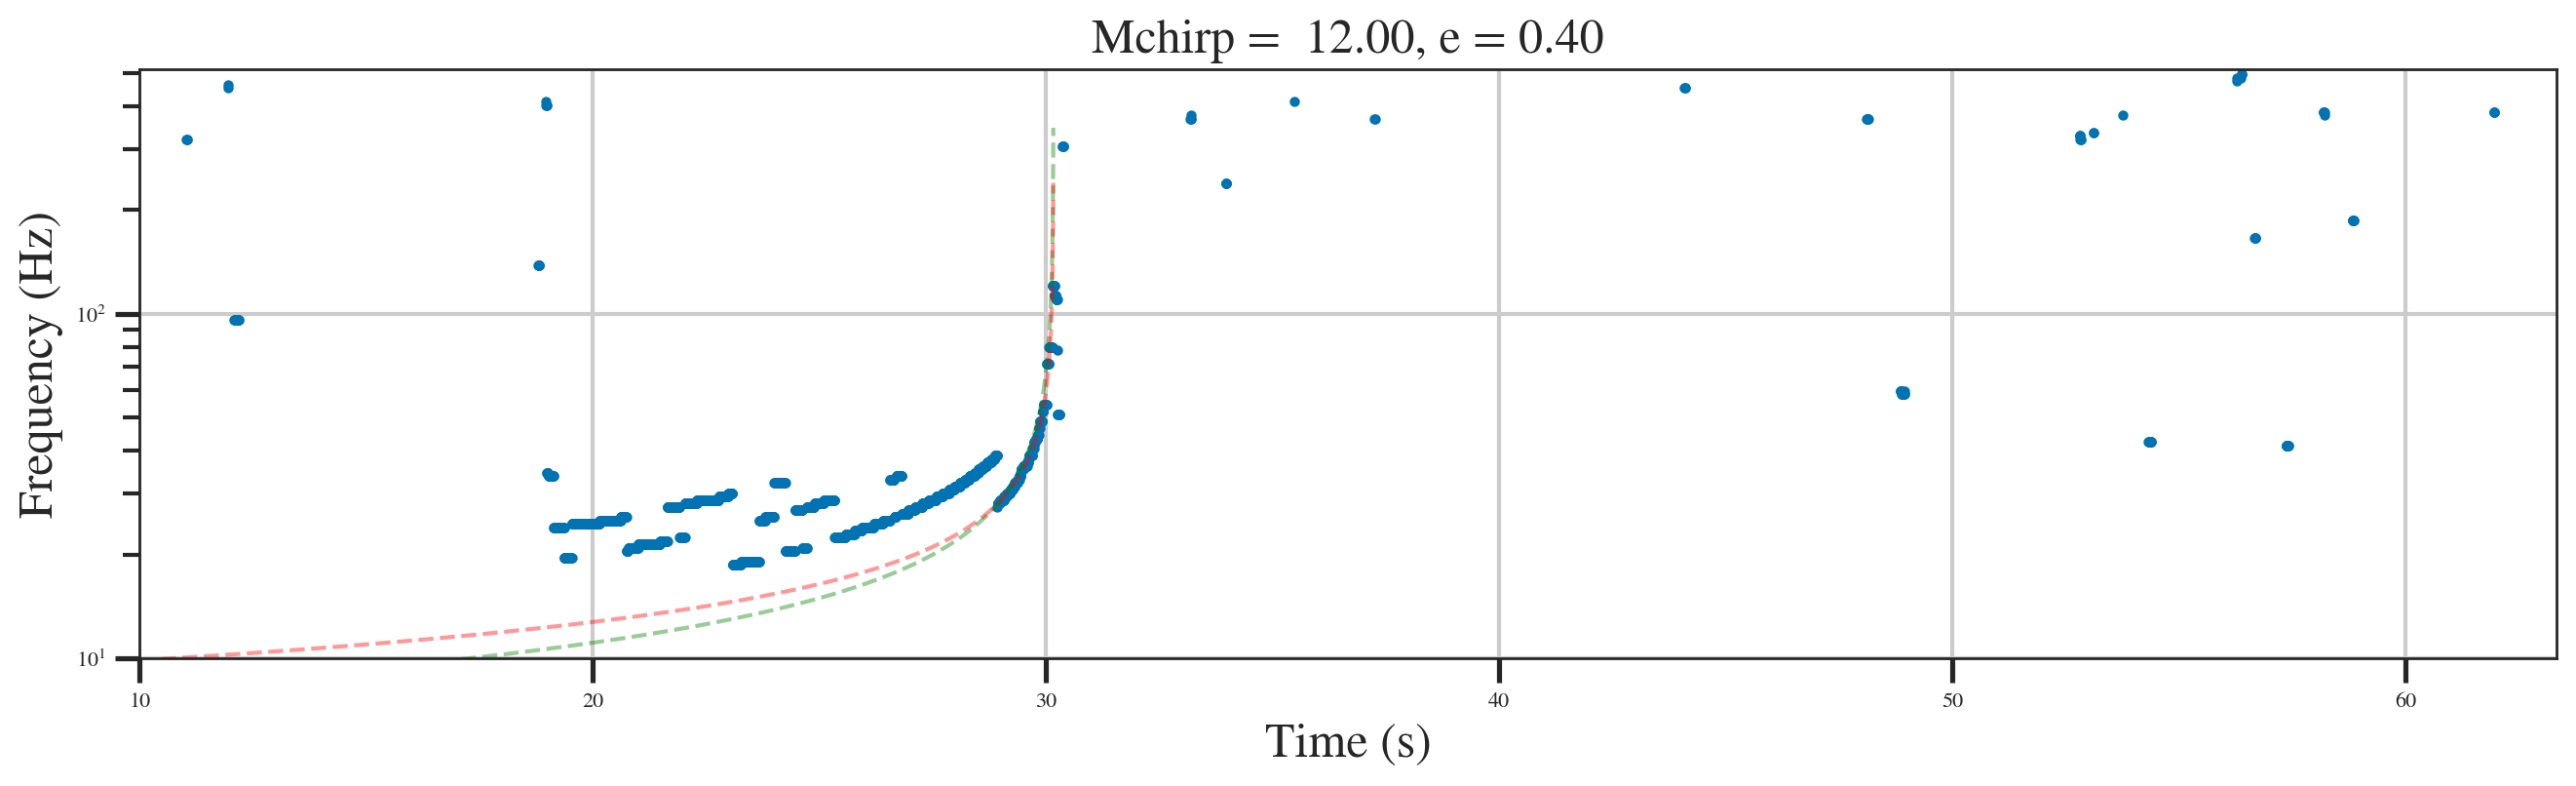

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.ylim(10, 512)
pylab.xlim(10, 760/m)
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')
pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}')
plt.scatter(times, freqs1, s=5)
fx = freq_gen(m9[9], i9[9], times, tc)
# pylab.scatter(times, fx, s=3, color= "green")
pylab.plot(times, fx,"--", color = "green", alpha = 0.4, lw = 1.5)
# fy = freq_gen2(m1[0], m, times, tc)
# pylab.plot(times, fy, "--", color = "white", alpha = 1, lw = 1.5)
fs = gen_freq(m,e,times,tc)
pylab.plot(times, fs, "--", color = "red", alpha = 0.4, lw = 1.5)
# , SNR = {snr:0.2f}, q = {max_key:0.2f}

In [ ]:
index_max = np.argmax(fx)
print(times[index_max])

252.5


In [ ]:
idx_filter = np.abs(fx - freqs1) < 5
frq_1 = np.array(freqs1)
# frq1 = np.append(frq_1[idx_filter], frq_1[(times > 133) * (times < 143)])
frq2 = frq_1[idx_filter]
# times1 = np.append(times[idx_filter], times[(times > 133) * (times < 143)])
times2 = times[idx_filter]
# fx1 = np.append(fx[idx_filter], fx[(times > 133) * (times < 143)])
fx2 = fx[idx_filter]
# fs1 = np.append(fs[idx_filter], fs[(times > 133) * (times < 143)])
fs2 = fs[idx_filter]

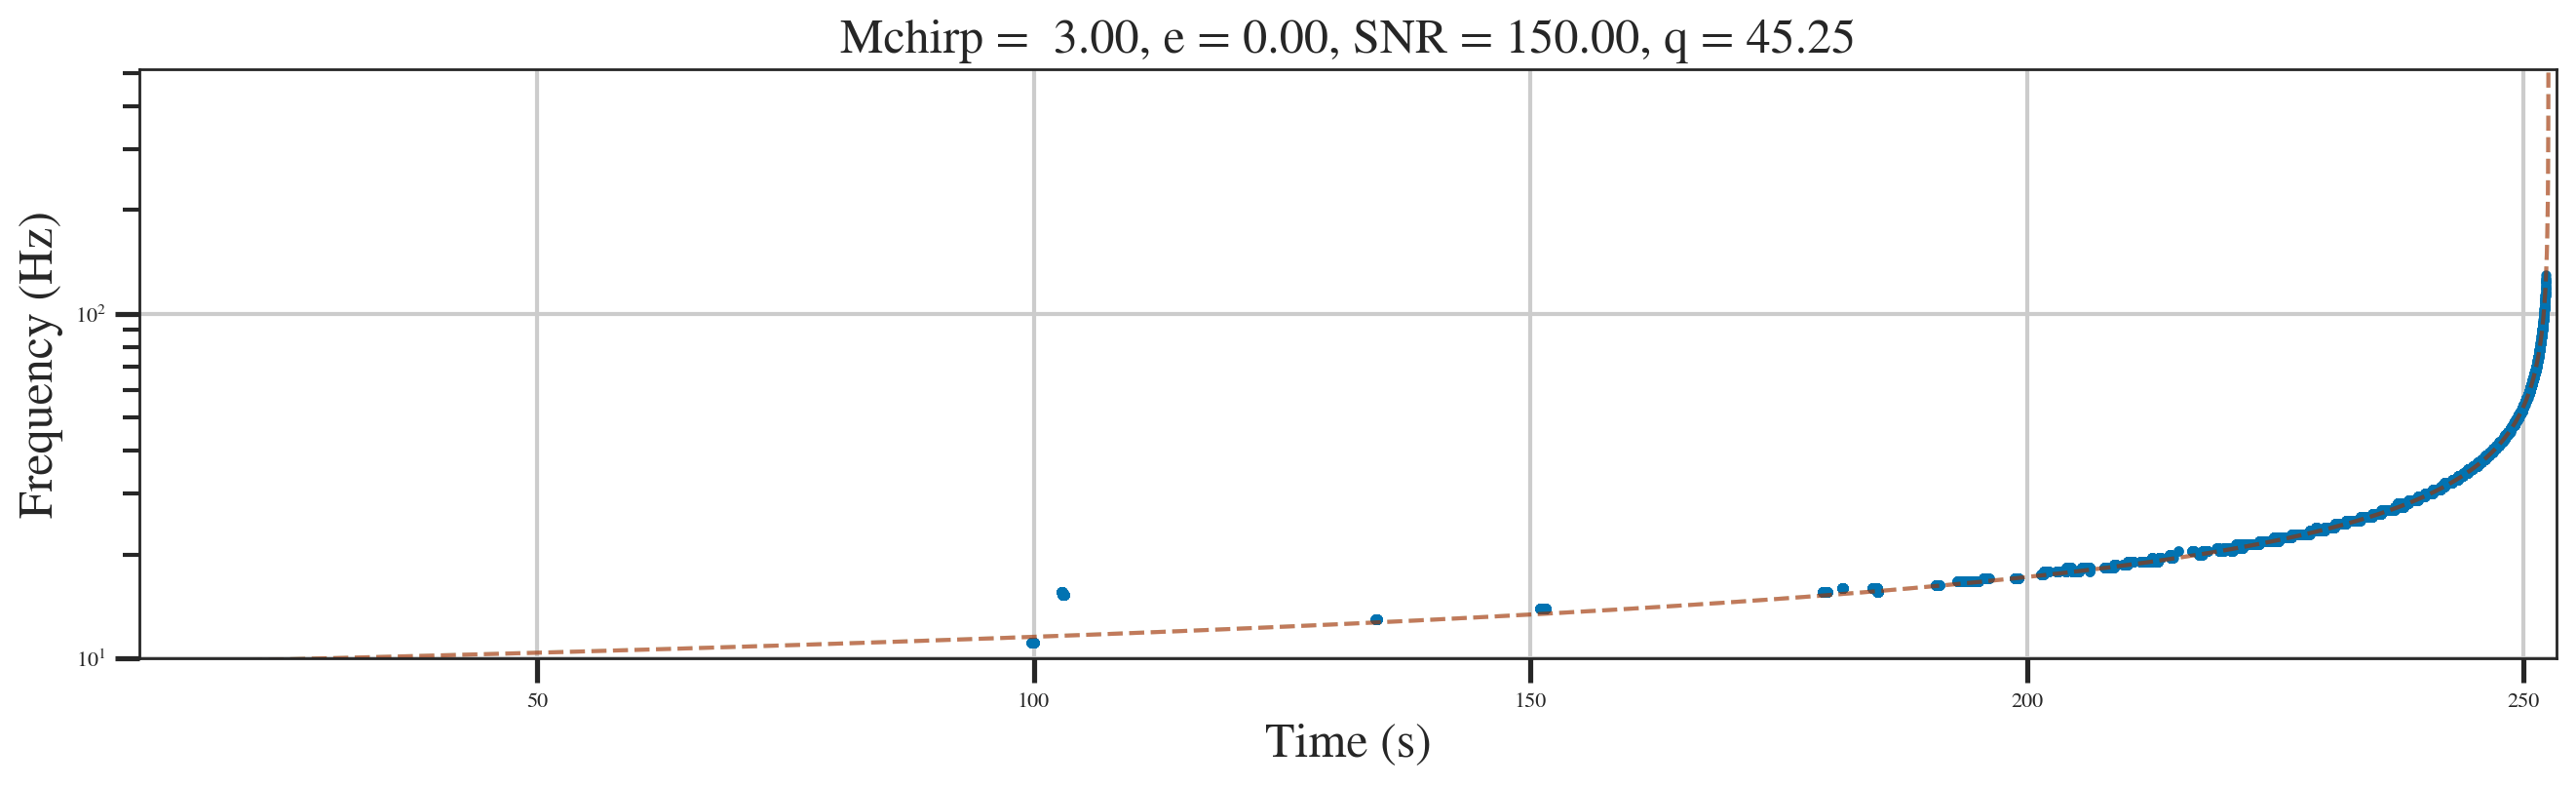

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.ylim(10, 512)
pylab.xlim(10, 760/m)
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')
pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}, SNR = {snr:0.2f}, q = {max_key:0.2f}')
pylab.scatter(times2, frq2, s=5)
pylab.plot(times, fx,"--", color = "green", alpha = 0.4, lw = 1.5)
pylab.plot(times, fs,"--", color = "red", alpha = 0.4, lw = 1.5)

In [ ]:
# pylab.figure(figsize=(16,4))
# pylab.grid(zorder=1)
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
# pylab.xlabel('Time (s)')
# pylab.ylabel('Frequency (Hz)')
# pylab.yscale('log')
# pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}, SNR = {snr:0.2f}, q = {max_key:0.2f}')
# pylab.scatter(times1, frq1, s=5)
# pylab.plot(times, fx,"--", color = "green", alpha = 0.4, lw = 1.5)

In [ ]:
std1 = np.square(fx2 - frq2)
# std1 = std1[~np.isnan(std1)]
N1 = len(std1)
std1 = np.sum(std1)
std_1 = std1 / N1
print(std1)
print(N1)
print(std_1)

2466.8728548664403
9443
0.2612382563662438


In [ ]:
std2 = np.square(fs2 - frq2)
# std2 = std2[~np.isnan(std2)]
N2 = len(std2)
std2 = np.sum(std2)
std_2 = std2 / N2
print(std2)
print(N2)
print(std_2)

2488.883205689448
9443
0.26356912058556053


NameError: ignored

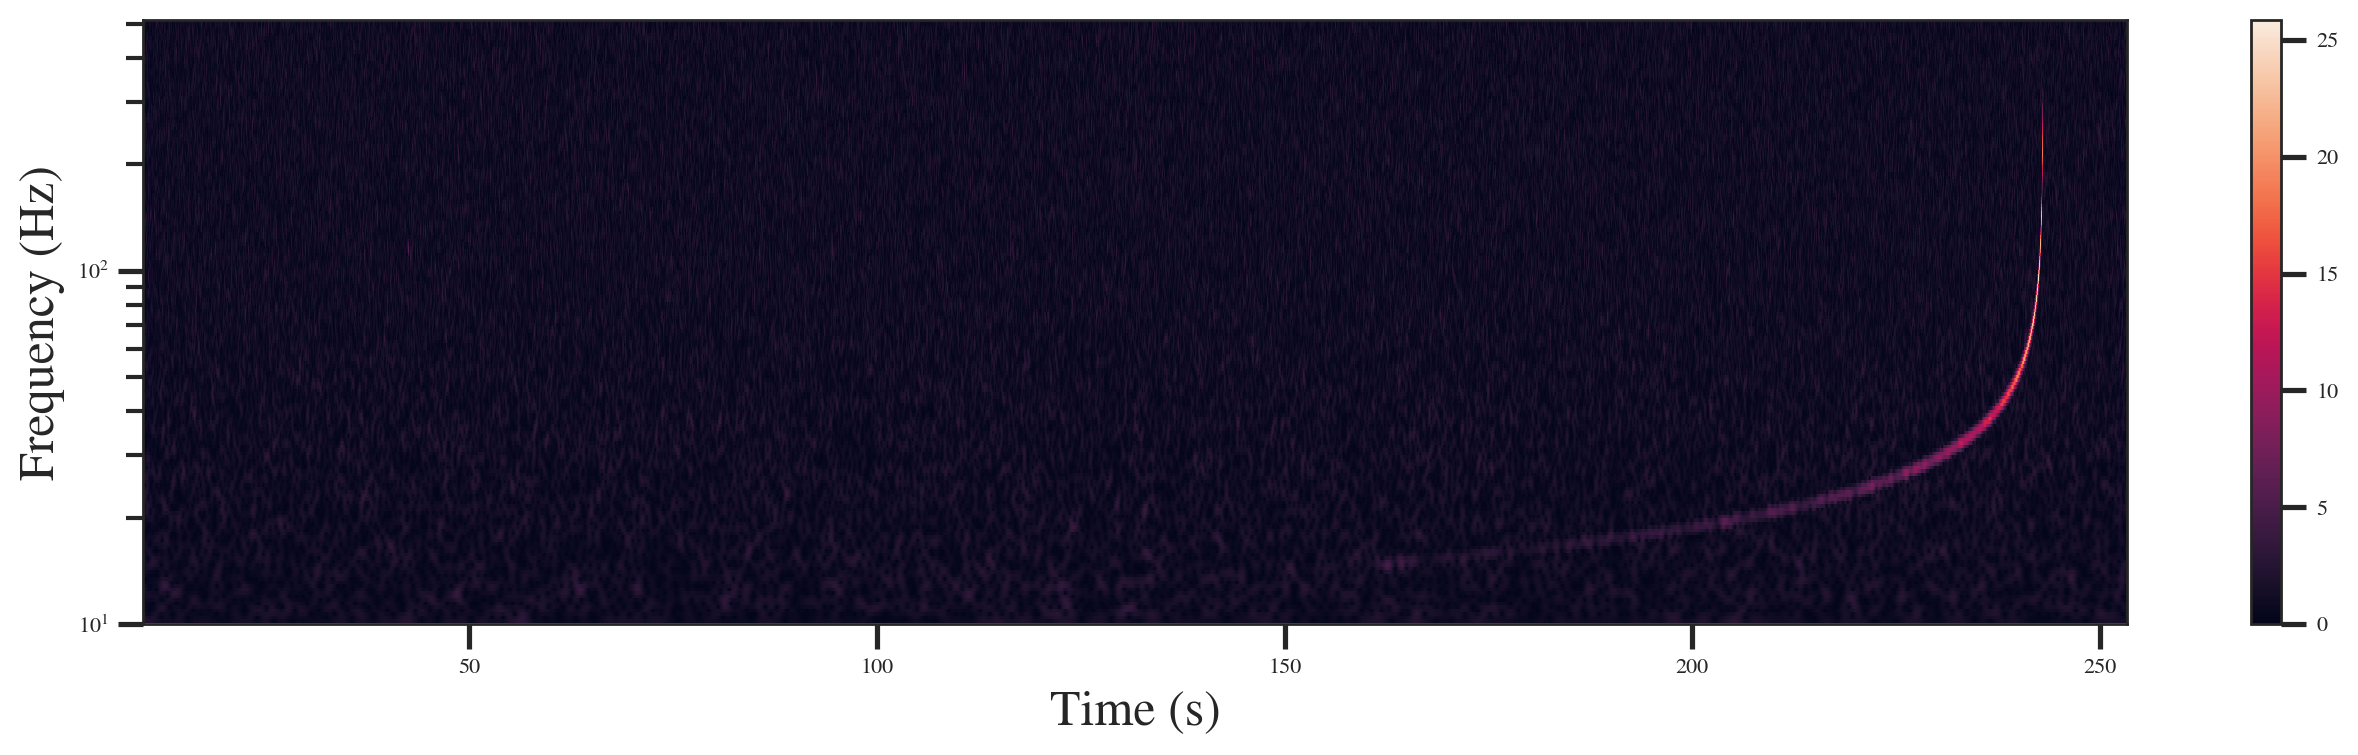

In [ ]:
#plotting
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(times, freqs, power**0.5, vmin=0,zorder=2)
pylab.ylim(10, 512)
pylab.xlim(10, 760/m)
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.yscale('log')
pylab.colorbar()
pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}')
#generating and superimposng f(t) from the model
fx = freq_gen(m3[0], i3[0], times, tc)
pylab.plot(times, fx,"--", color = "white", alpha = 1, lw = 1.5)
# fy = freq_gen2(m1[0], m, times, tc)
# pylab.plot(times, fy, "--", color = "white", alpha = 1, lw = 1.5)
fs = gen_freq(m,e,times,tc)
pylab.plot(times, fs, "g", alpha = 0.4, lw = 1.5)
pylab.show()

# Multiple Cases

2022-04-14 08:24:02 Generating Fake Strain
2022-04-14 08:24:03 Generating waveform
2022-04-14 08:24:48 Tapering TimeSeries and scaling its SNR
2022-04-14 08:24:48 Generating frequency domain version of the waveform
2022-04-14 08:24:48 Applying injections
2022-04-14 08:24:48 $case=1,mchirp=3.00,~e=0.00,~\iota=1.66,~\varphi_c=1.50,~ra=0.81,~dec=2.99,~SNR=150.00$


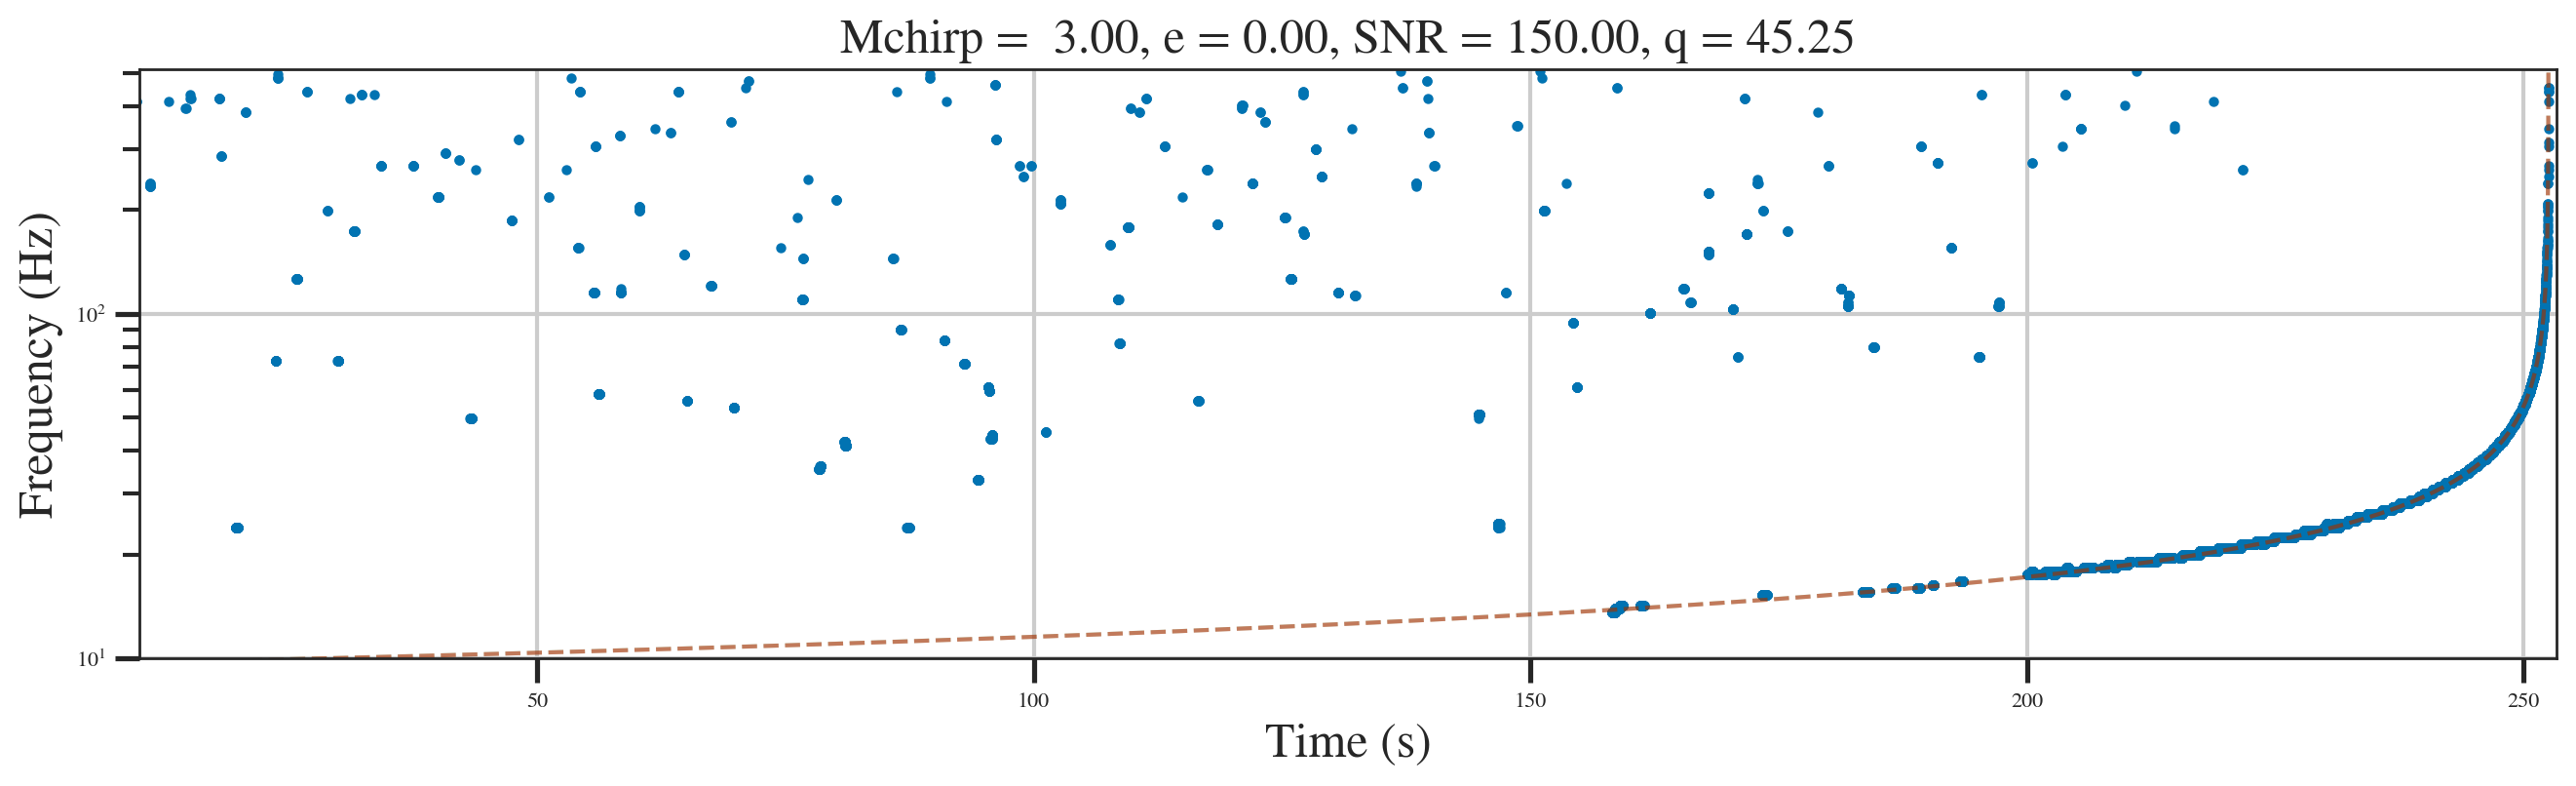

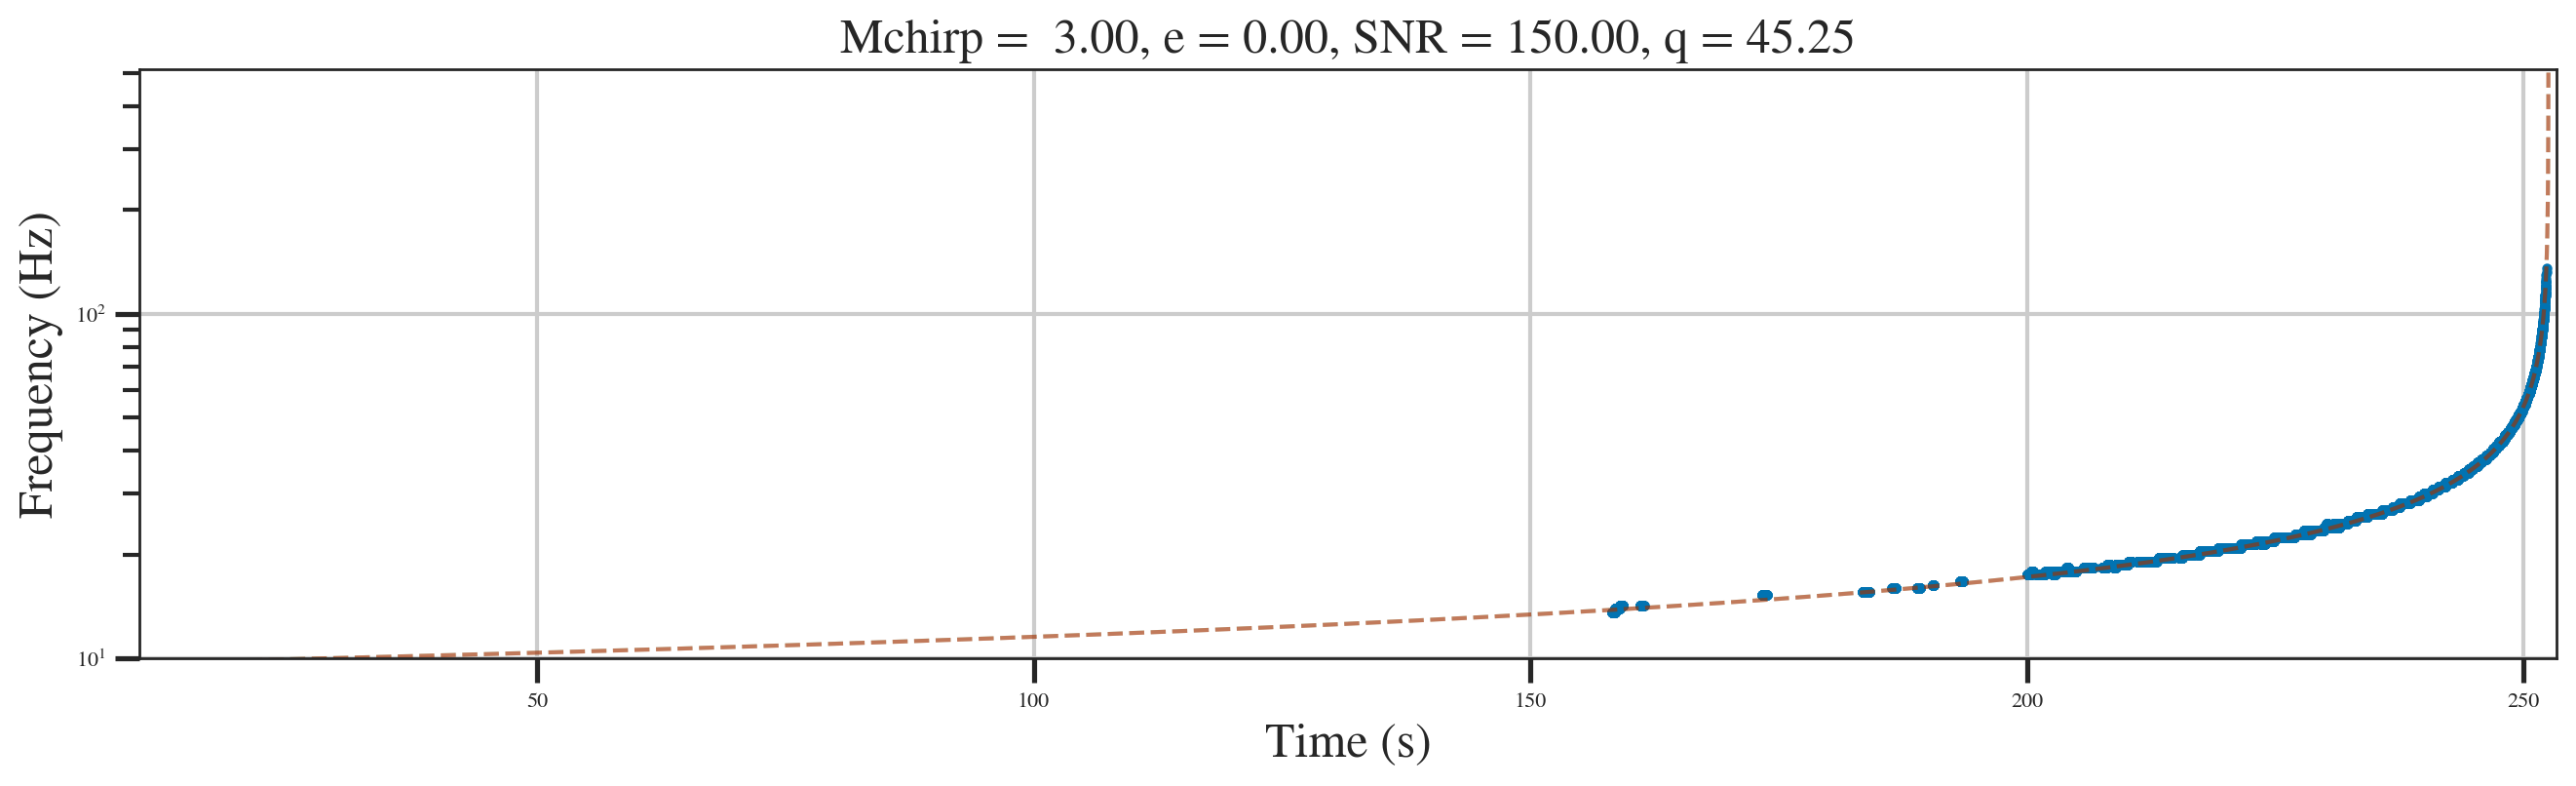

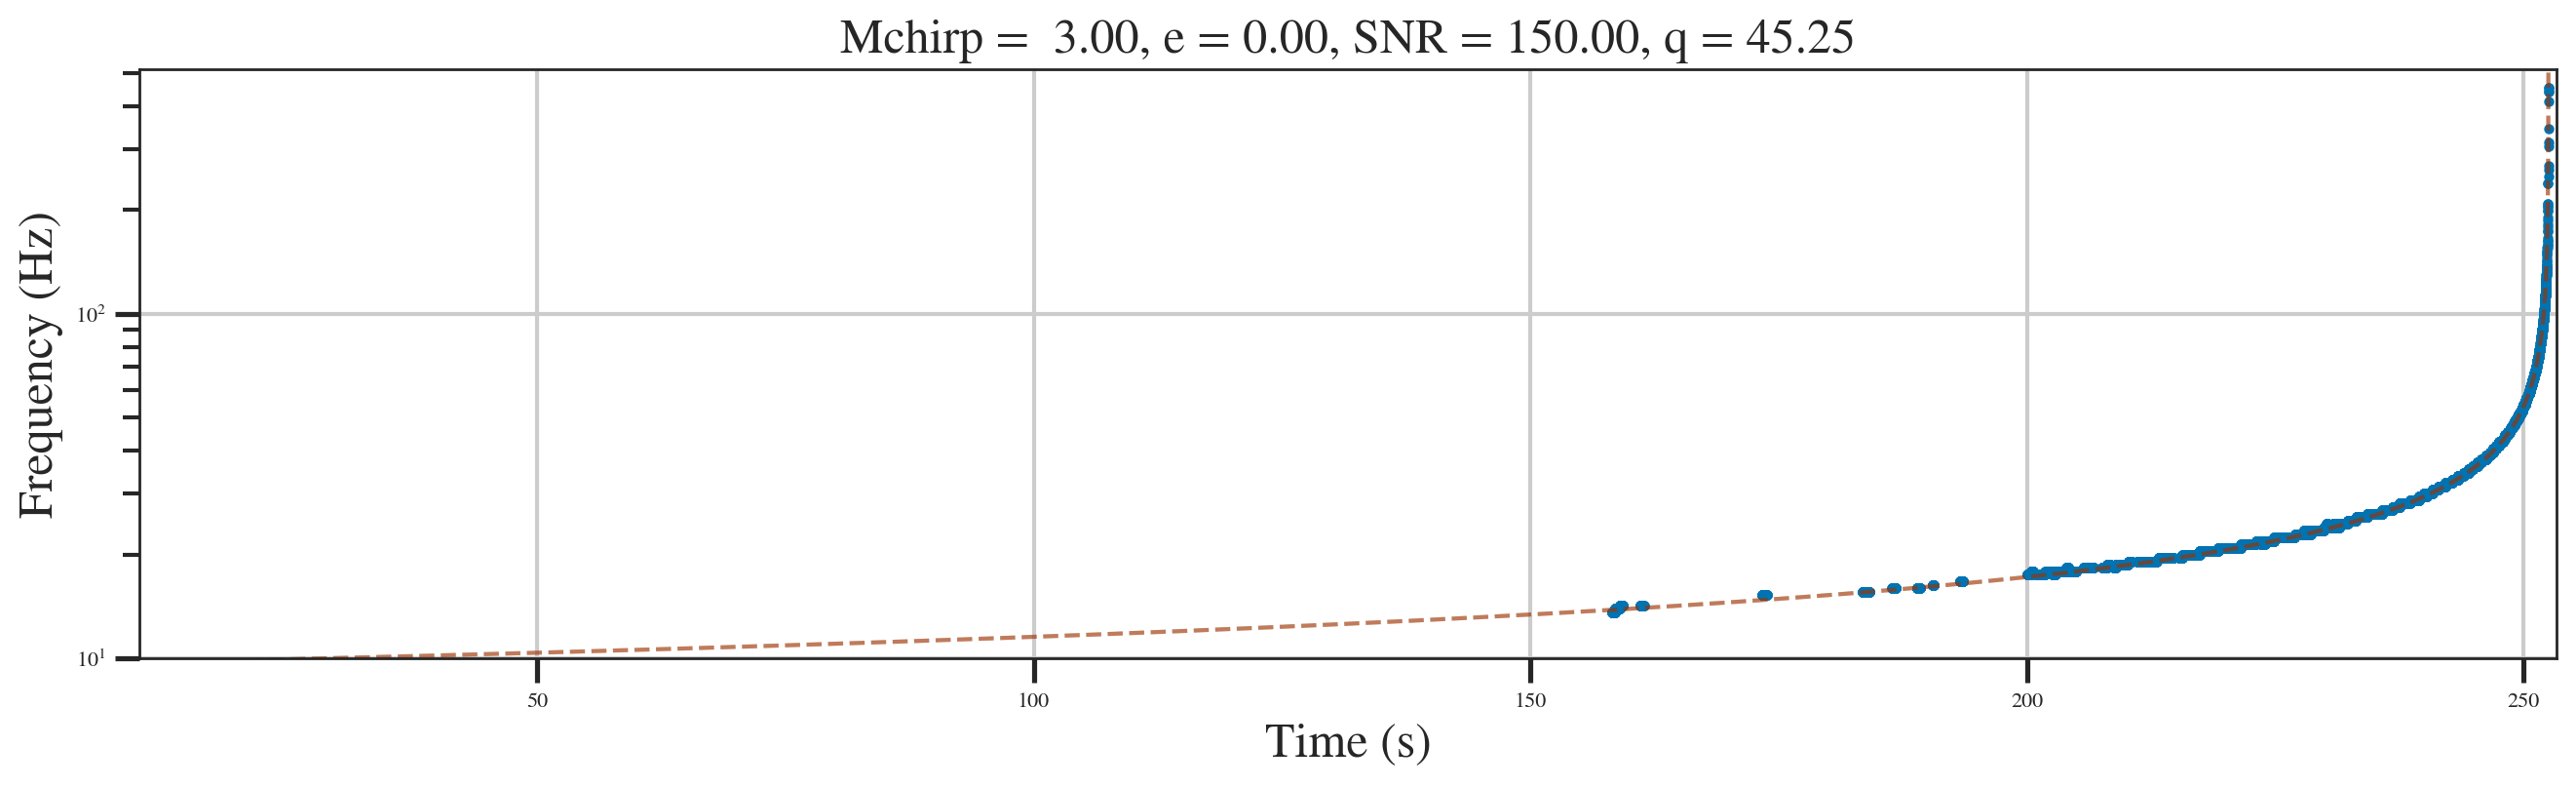

2022-04-14 08:25:39 Generating Fake Strain


0.15738304616203935
0.15955436917473412


2022-04-14 08:25:40 Generating waveform
2022-04-14 08:26:24 Tapering TimeSeries and scaling its SNR
2022-04-14 08:26:24 Generating frequency domain version of the waveform
2022-04-14 08:26:24 Applying injections
2022-04-14 08:26:24 $case=2,mchirp=3.00,~e=0.05,~\iota=2.87,~\varphi_c=2.32,~ra=1.45,~dec=2.06,~SNR=150.00$


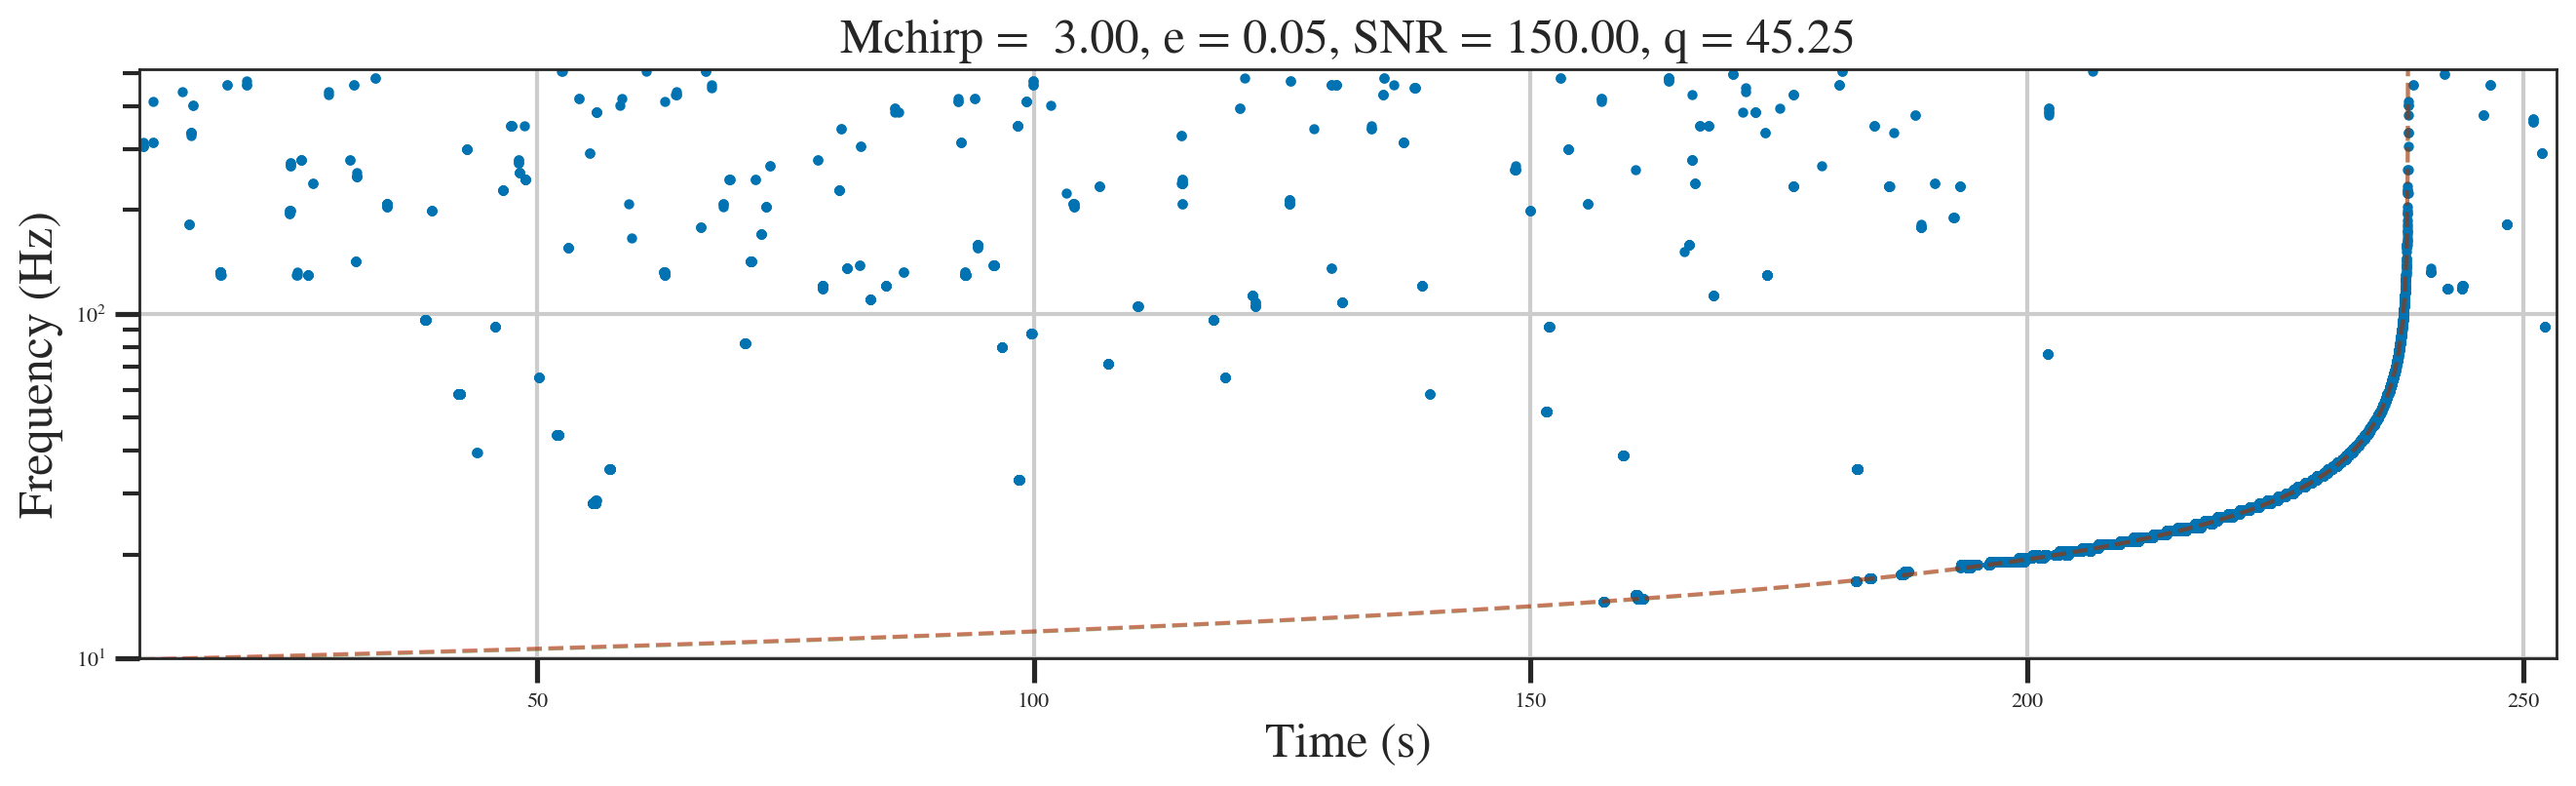

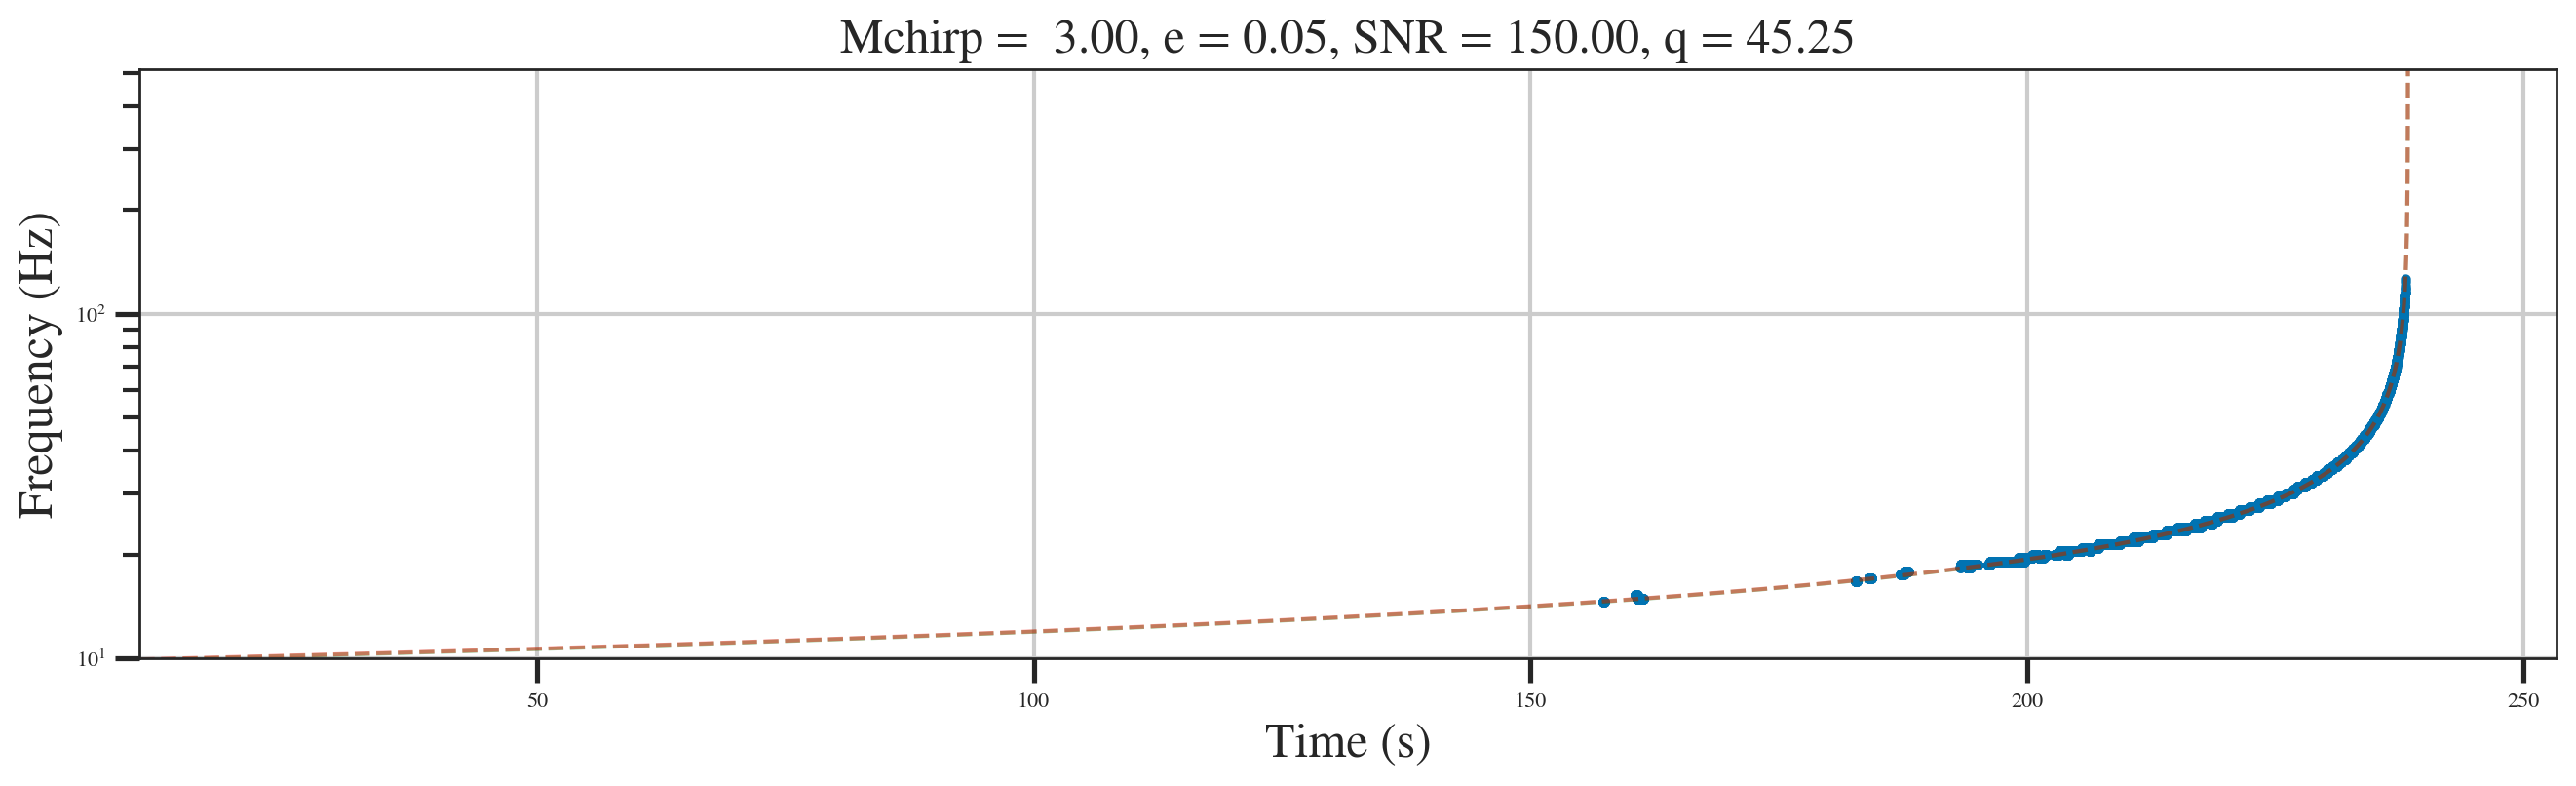

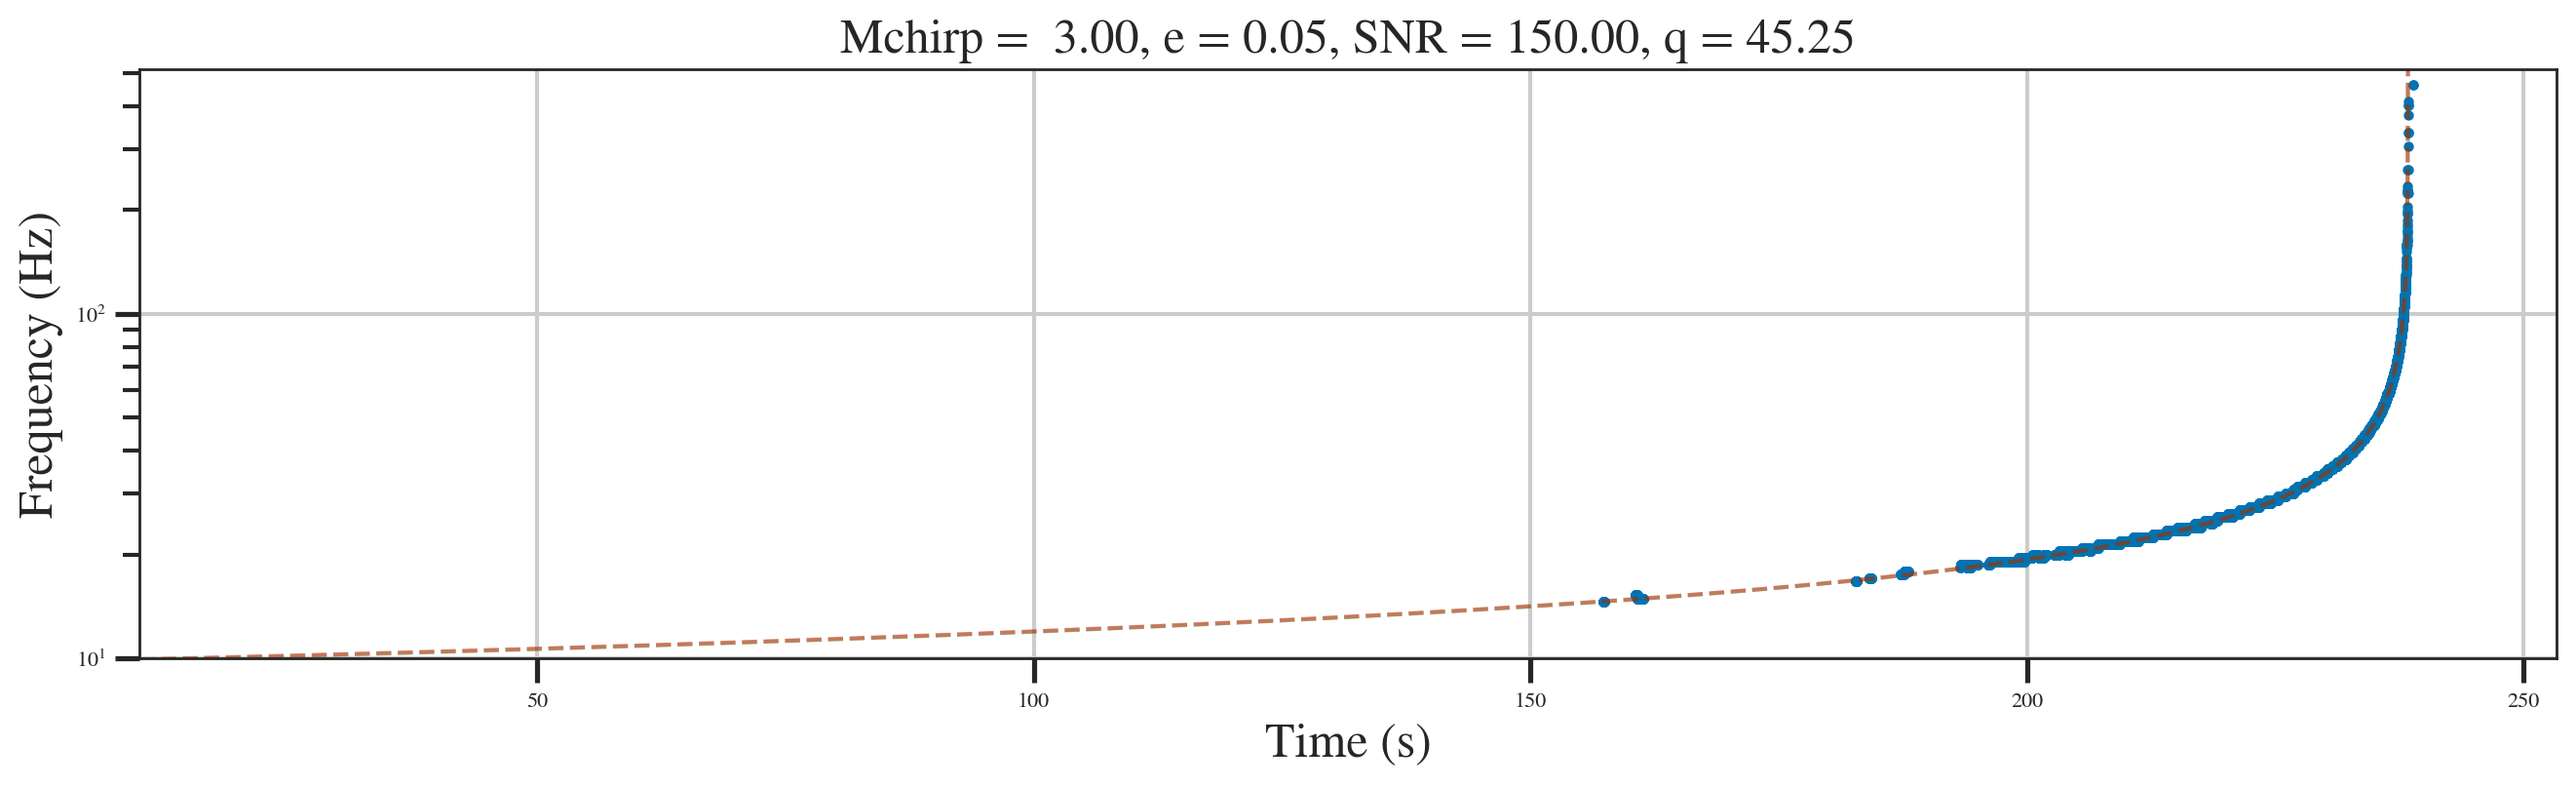

2022-04-14 08:27:09 Generating Fake Strain


0.1667427957055995
0.14648834890280754


2022-04-14 08:27:10 Generating waveform
2022-04-14 08:27:52 Tapering TimeSeries and scaling its SNR
2022-04-14 08:27:52 Generating frequency domain version of the waveform
2022-04-14 08:27:53 Applying injections
2022-04-14 08:27:53 $case=3,mchirp=3.00,~e=0.10,~\iota=2.58,~\varphi_c=0.38,~ra=1.86,~dec=0.89,~SNR=150.00$


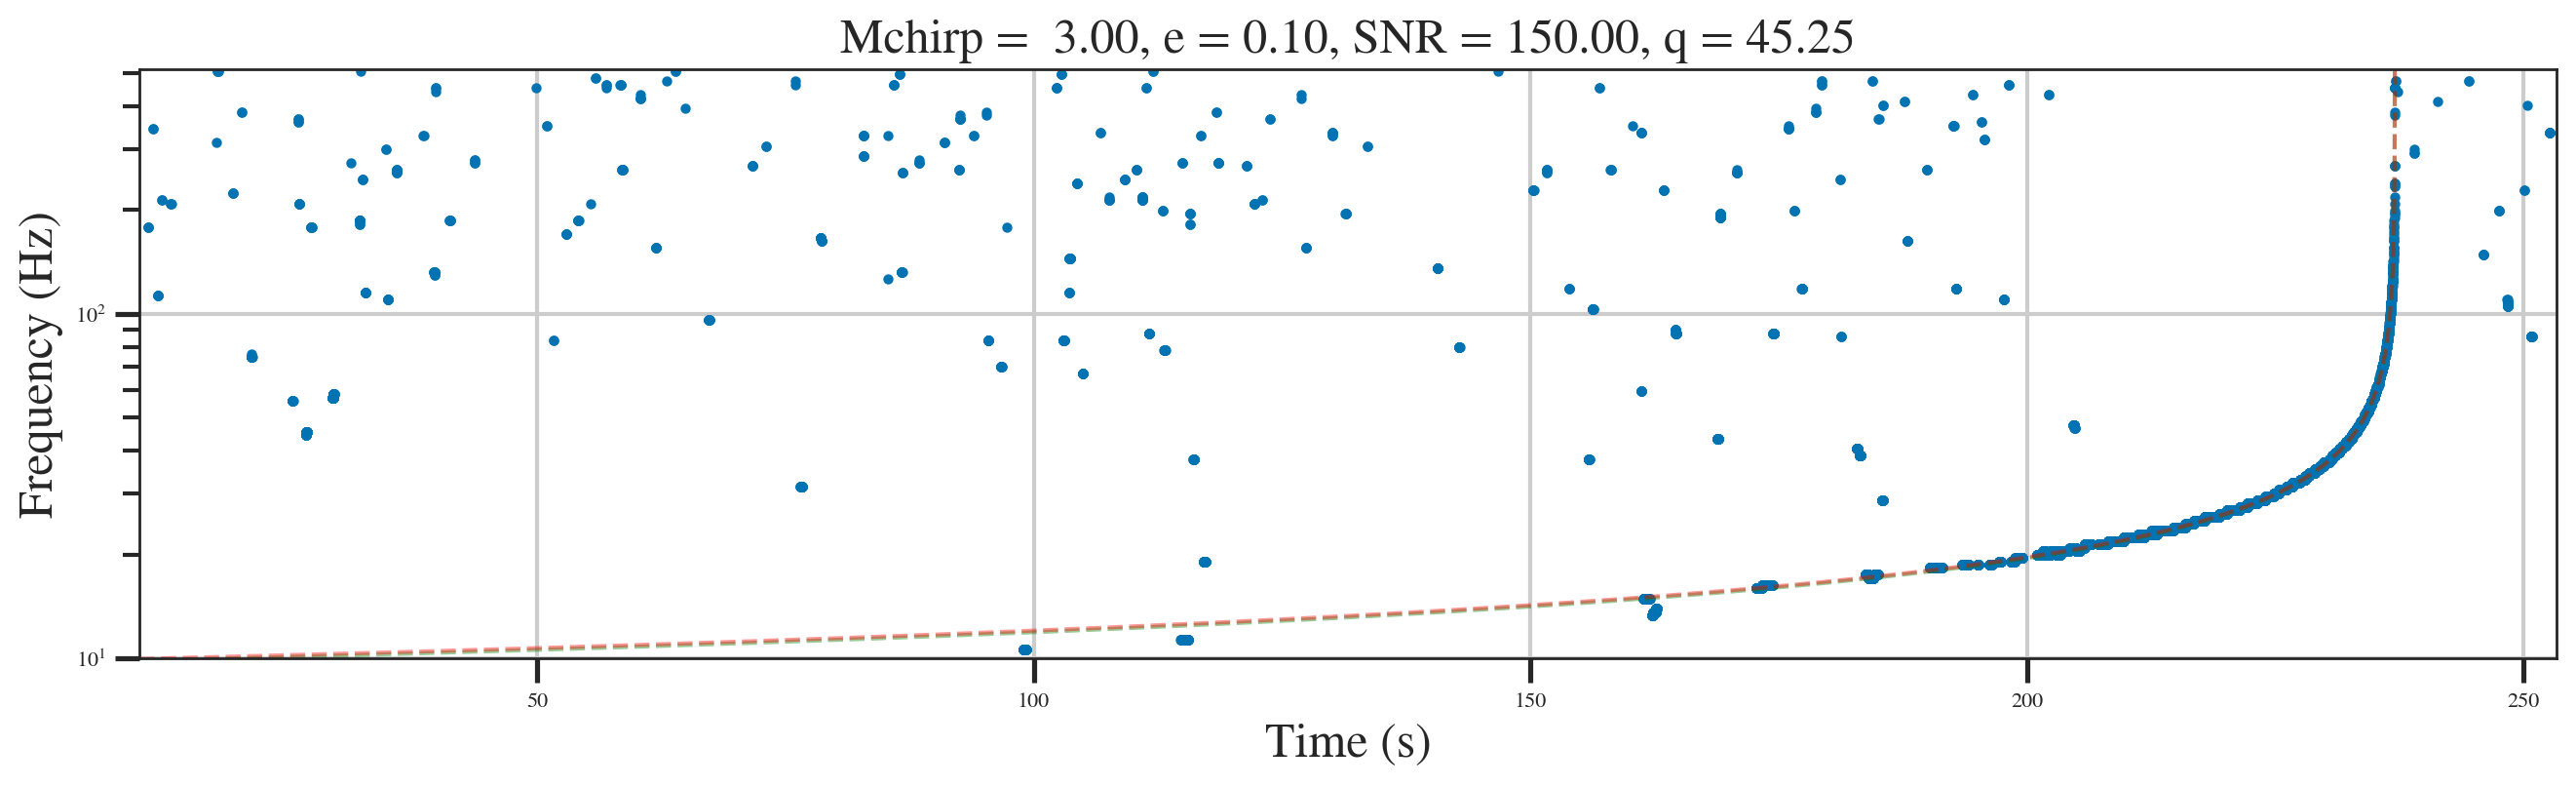

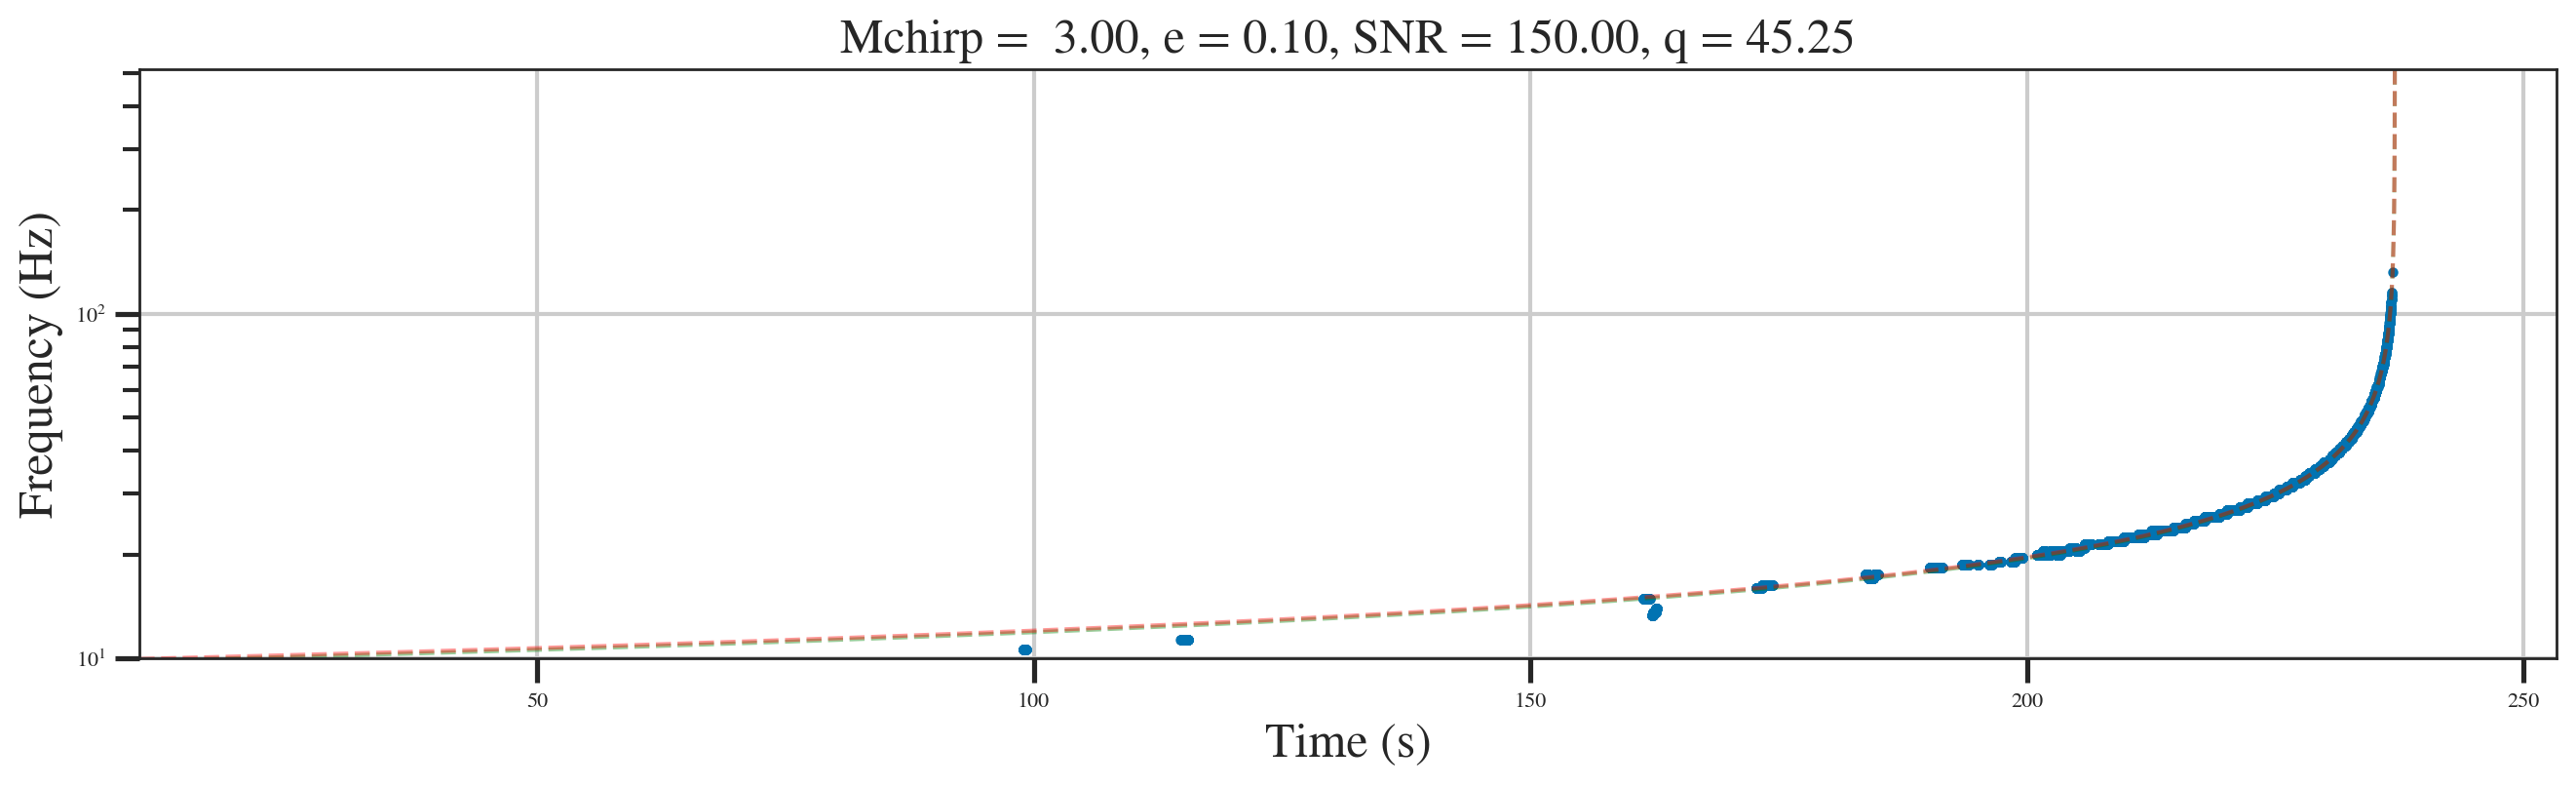

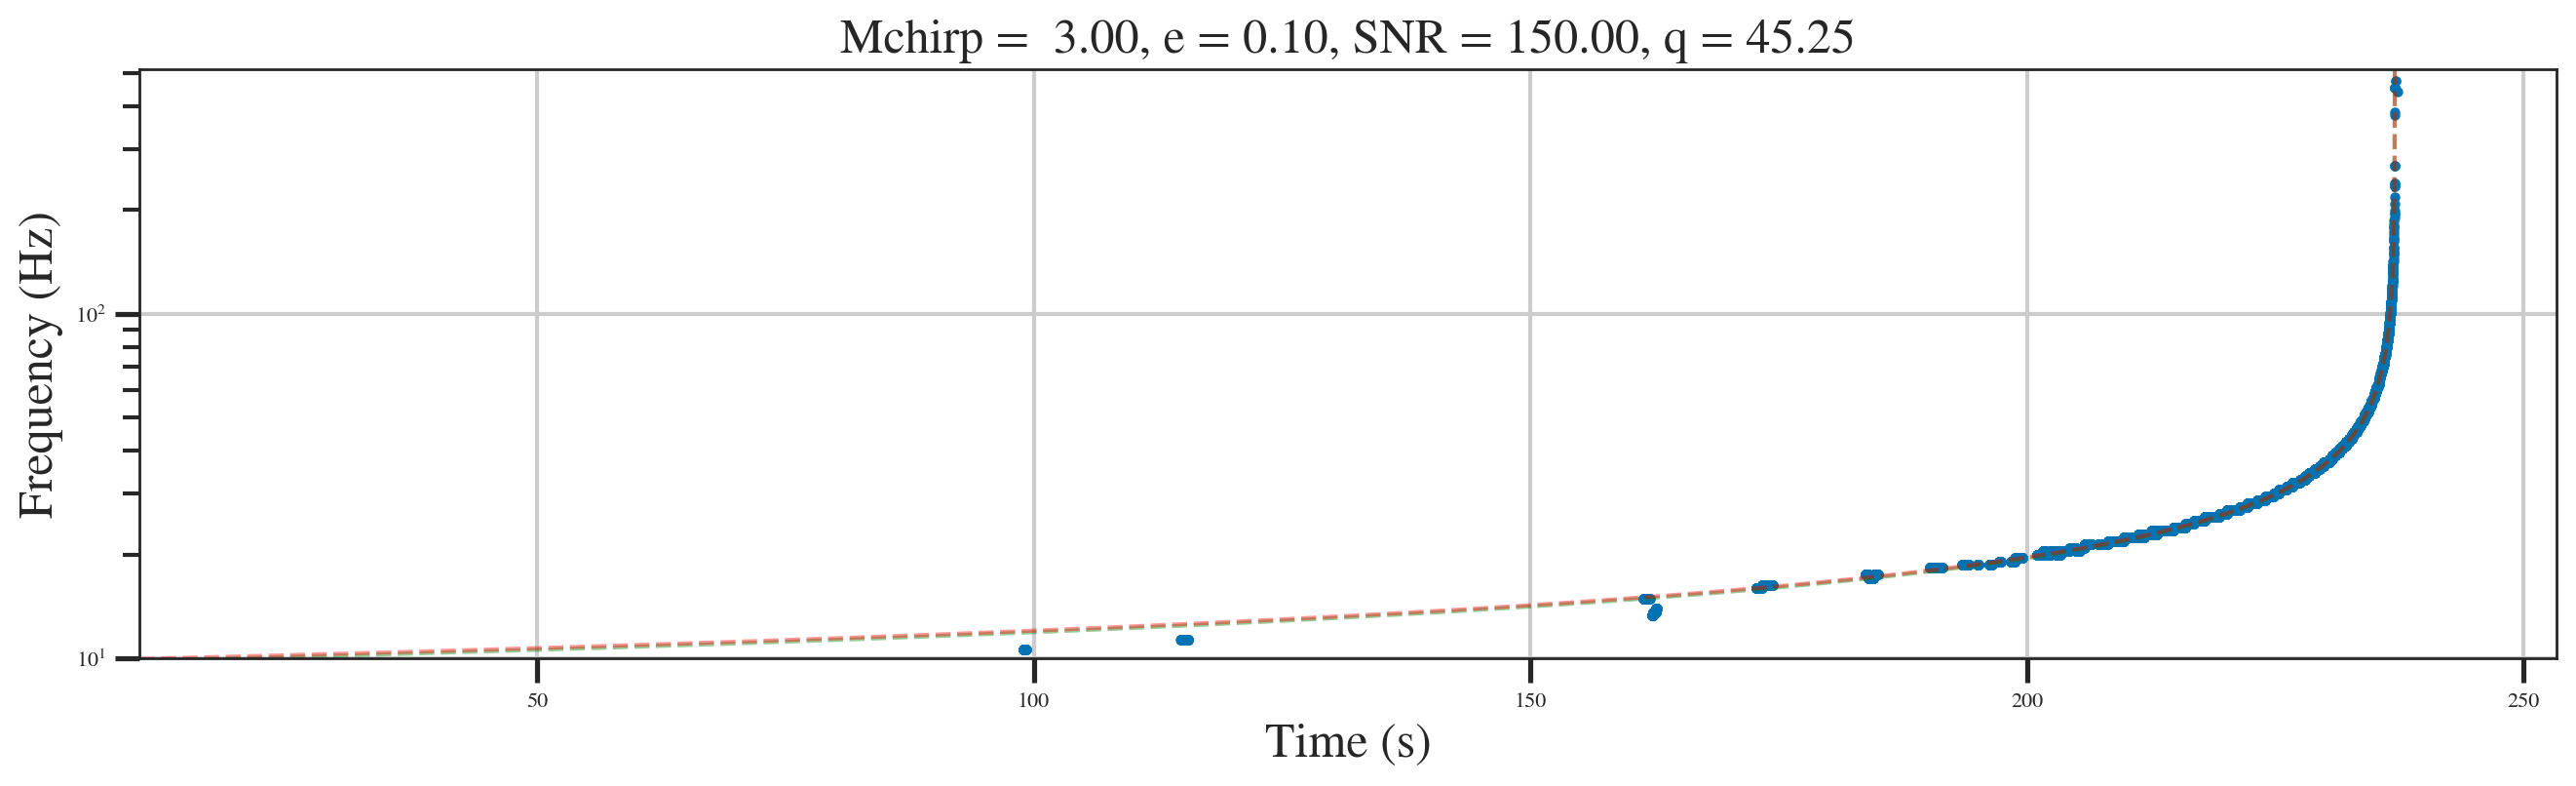

2022-04-14 08:28:39 Generating Fake Strain


0.24980555331869875
0.17855052001144456


2022-04-14 08:28:40 Generating waveform
2022-04-14 08:29:20 Tapering TimeSeries and scaling its SNR
2022-04-14 08:29:20 Generating frequency domain version of the waveform
2022-04-14 08:29:20 Applying injections
2022-04-14 08:29:20 $case=4,mchirp=3.00,~e=0.15,~\iota=2.08,~\varphi_c=0.57,~ra=1.35,~dec=0.92,~SNR=150.00$


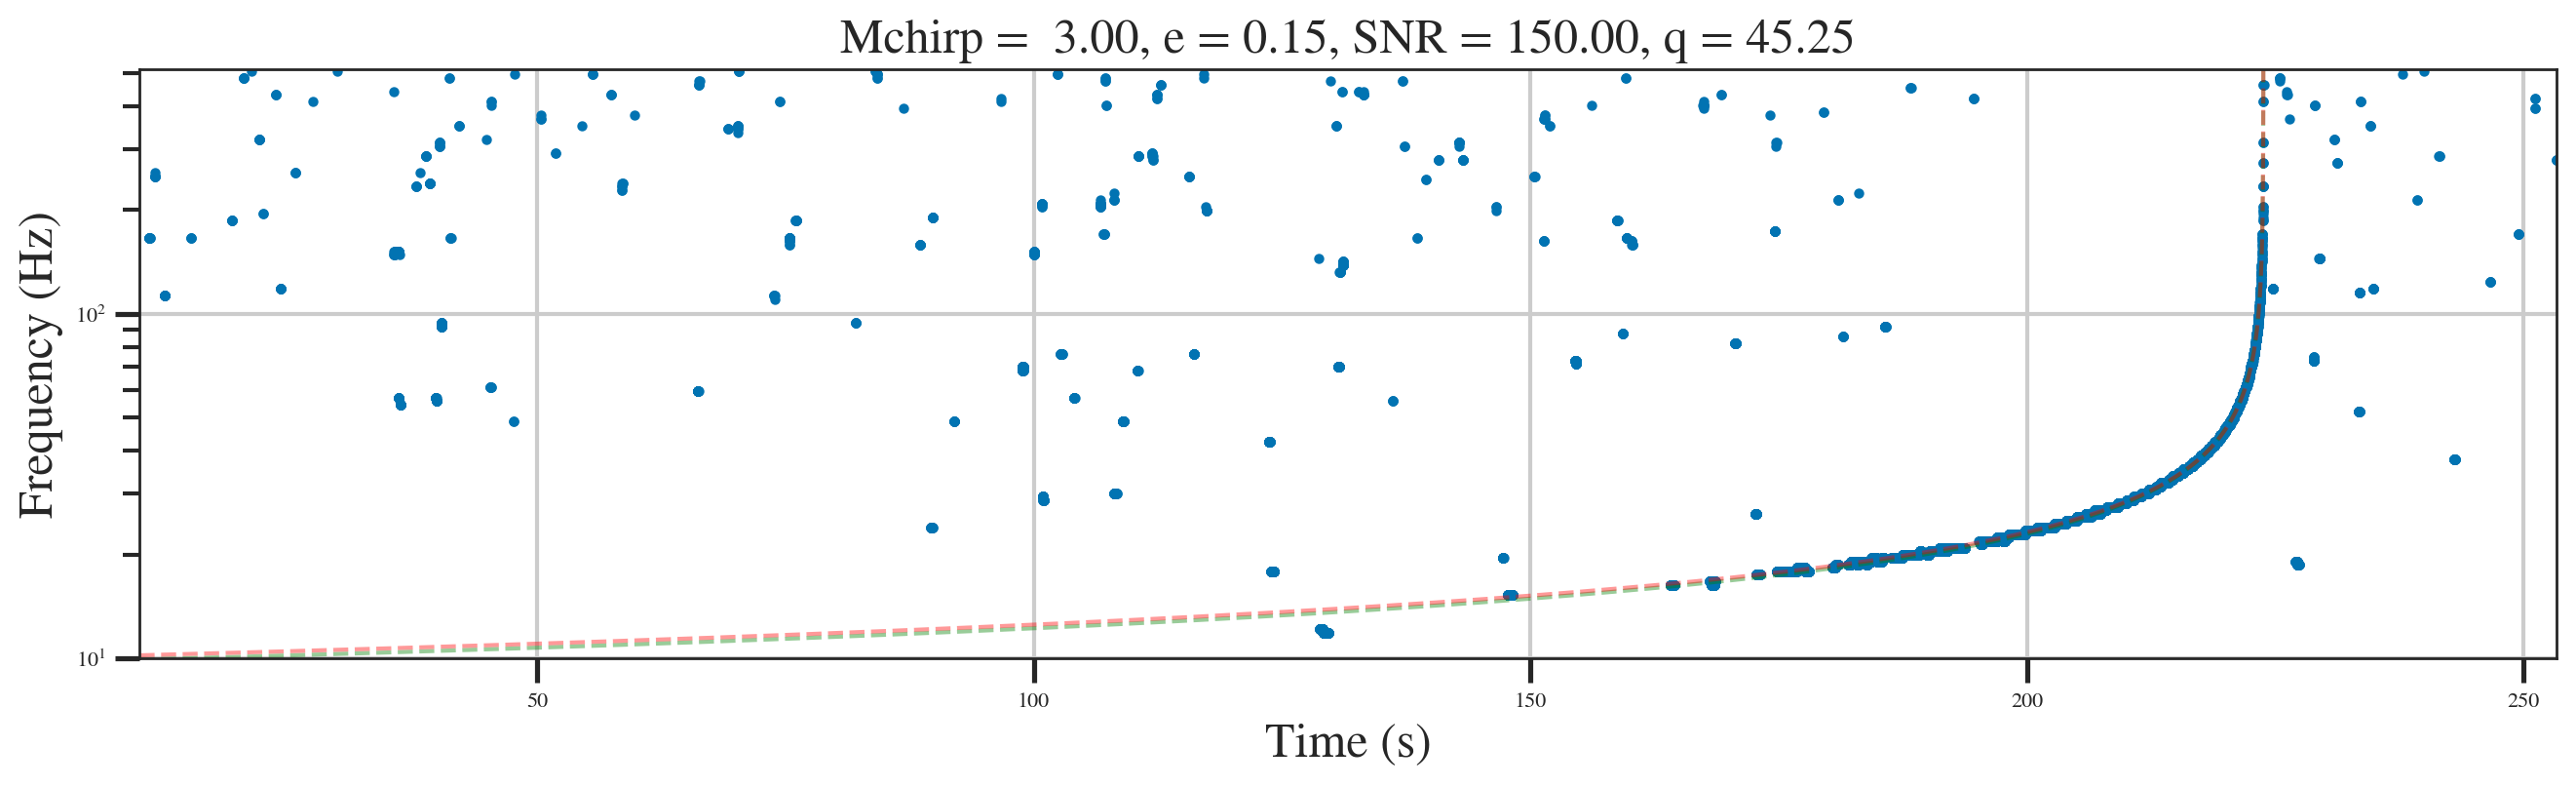

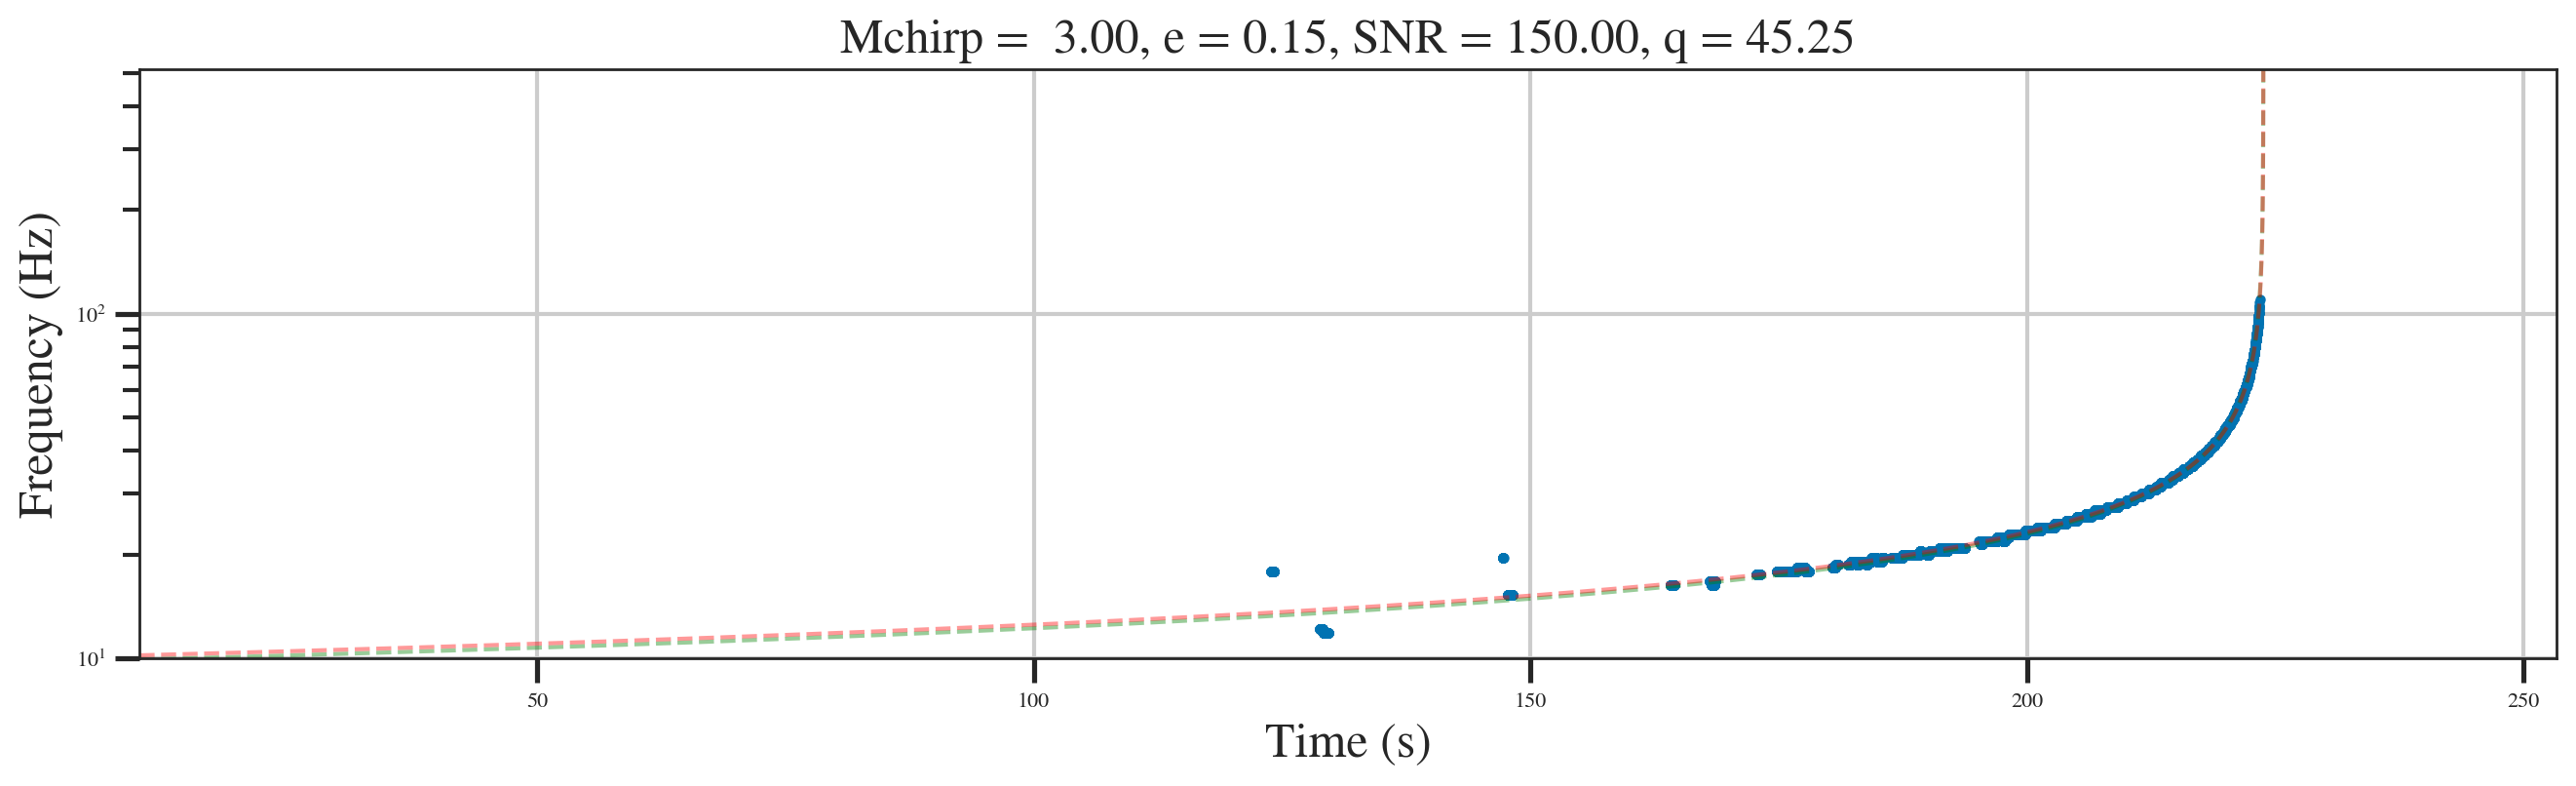

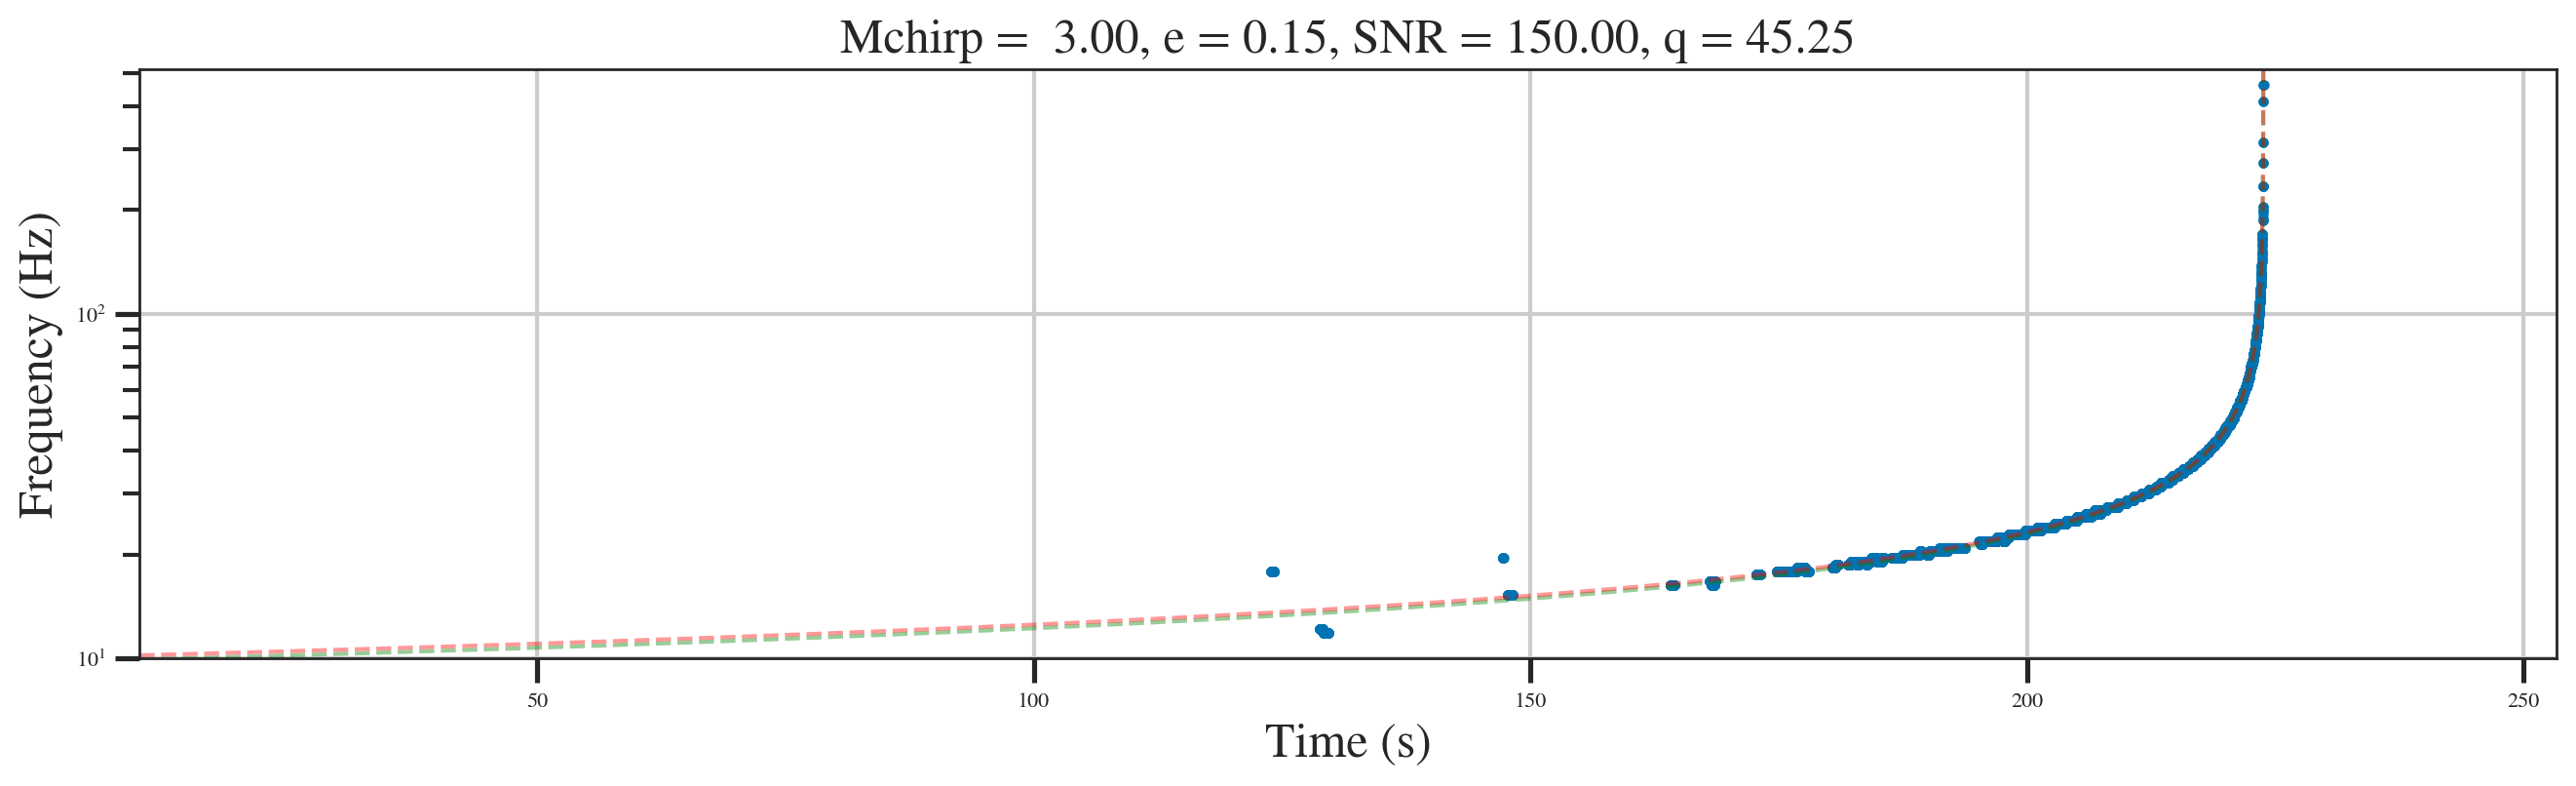

2022-04-14 08:30:07 Generating Fake Strain


0.513318403411803
0.3369859785524461


2022-04-14 08:30:07 Generating waveform
2022-04-14 08:30:45 Tapering TimeSeries and scaling its SNR
2022-04-14 08:30:45 Generating frequency domain version of the waveform
2022-04-14 08:30:45 Applying injections
2022-04-14 08:30:45 $case=5,mchirp=3.00,~e=0.20,~\iota=3.10,~\varphi_c=1.43,~ra=0.62,~dec=1.67,~SNR=150.00$


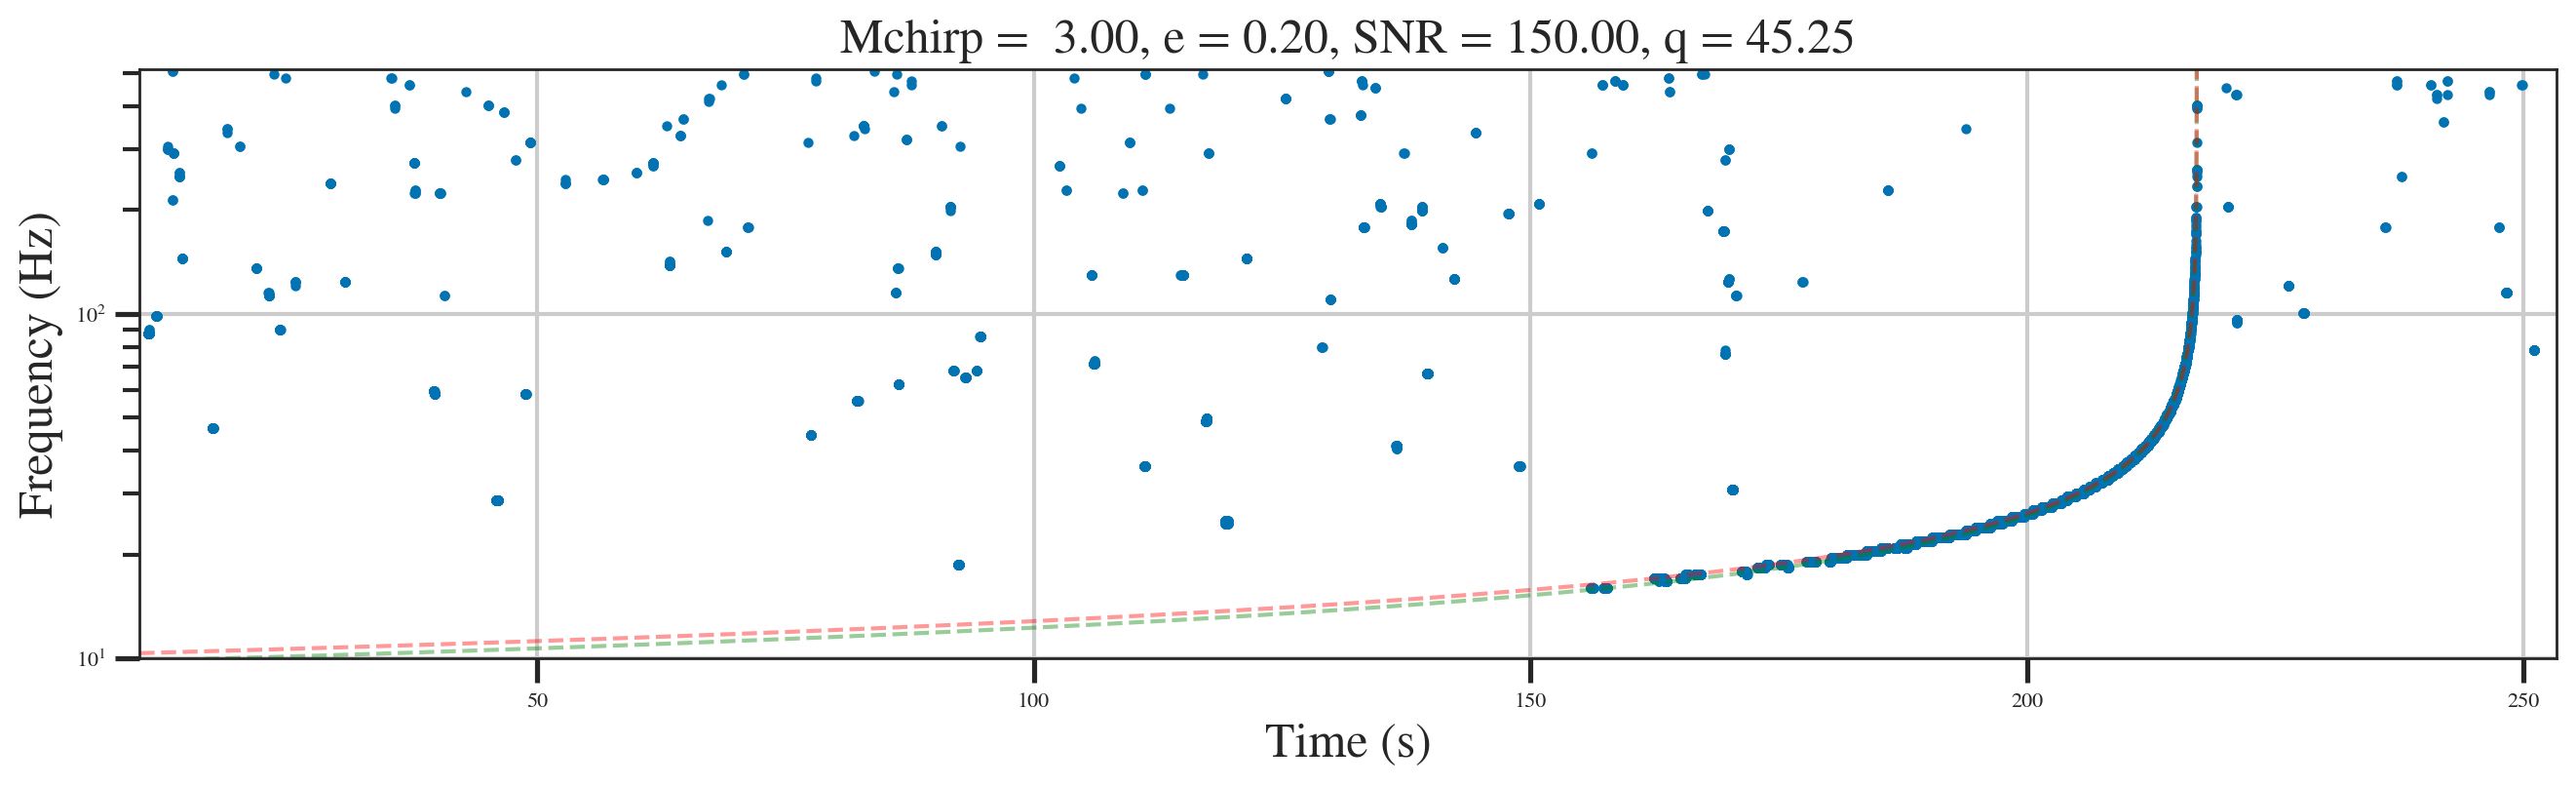

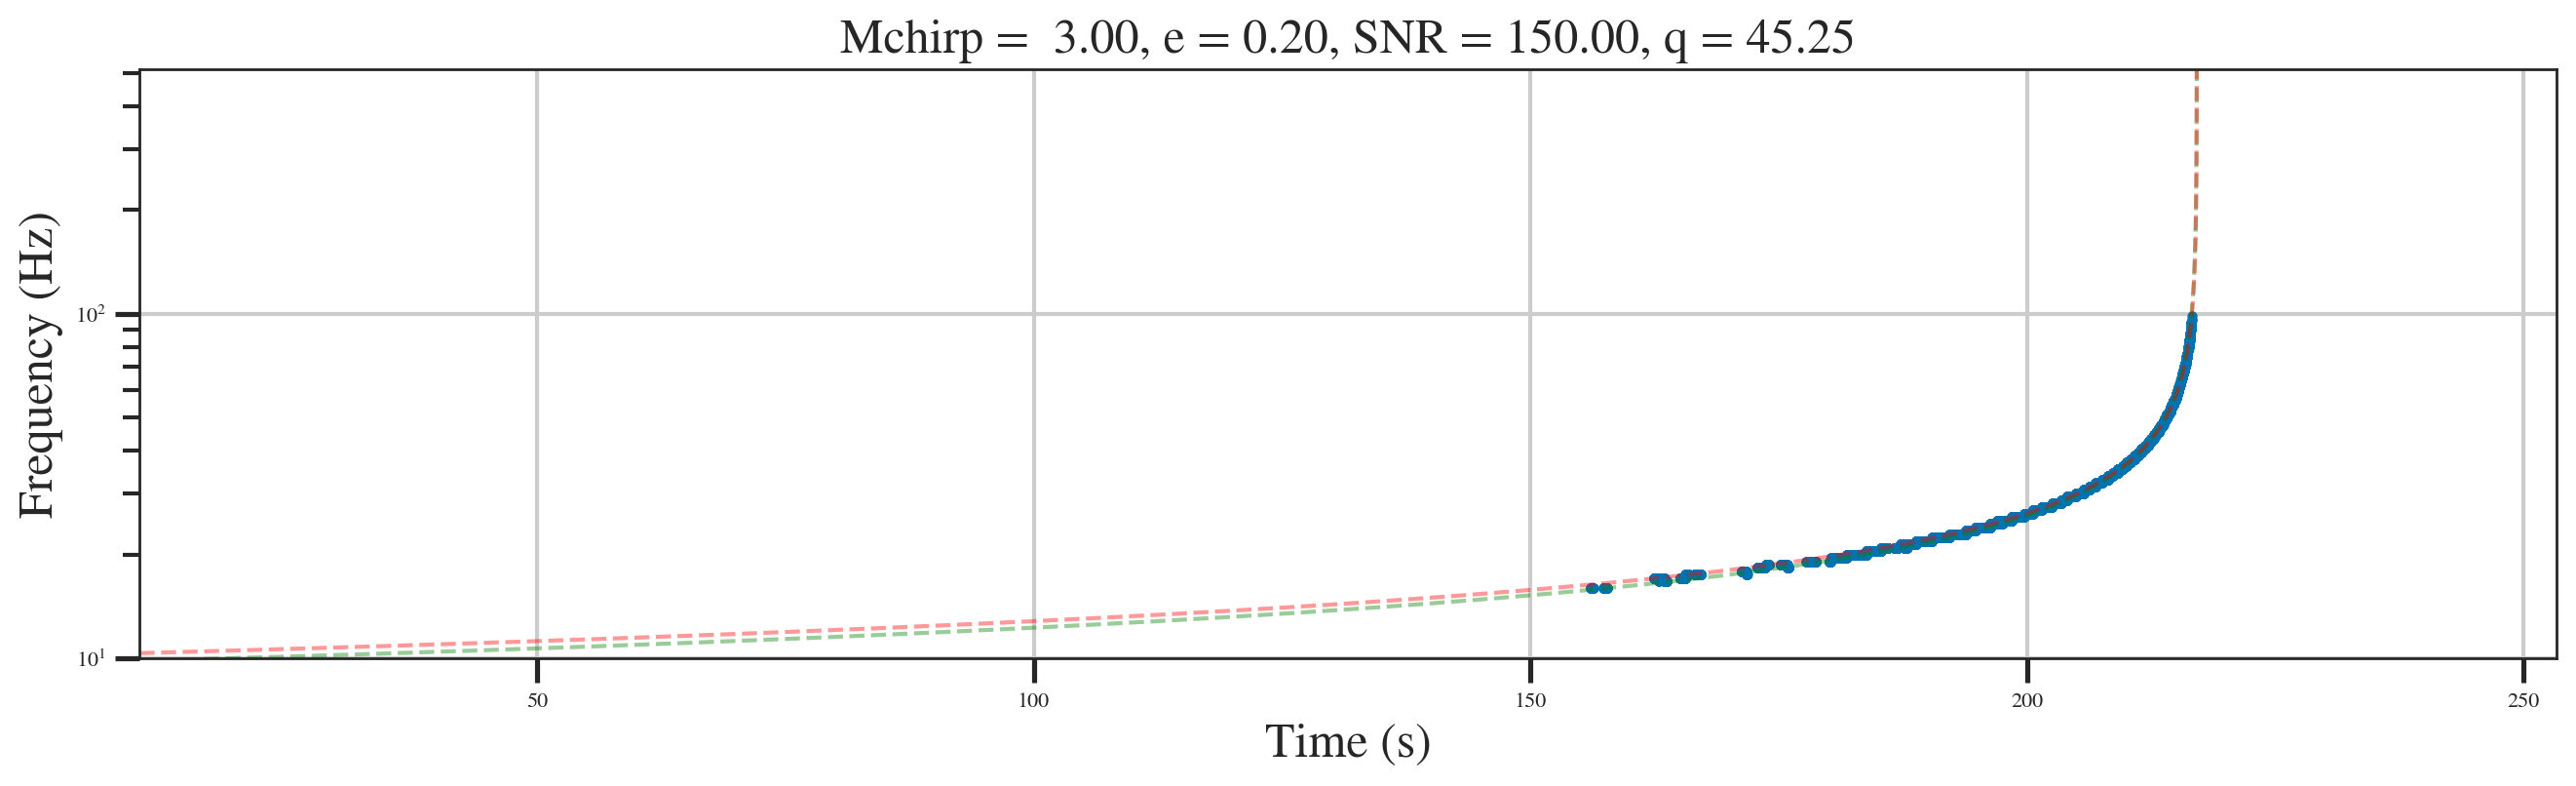

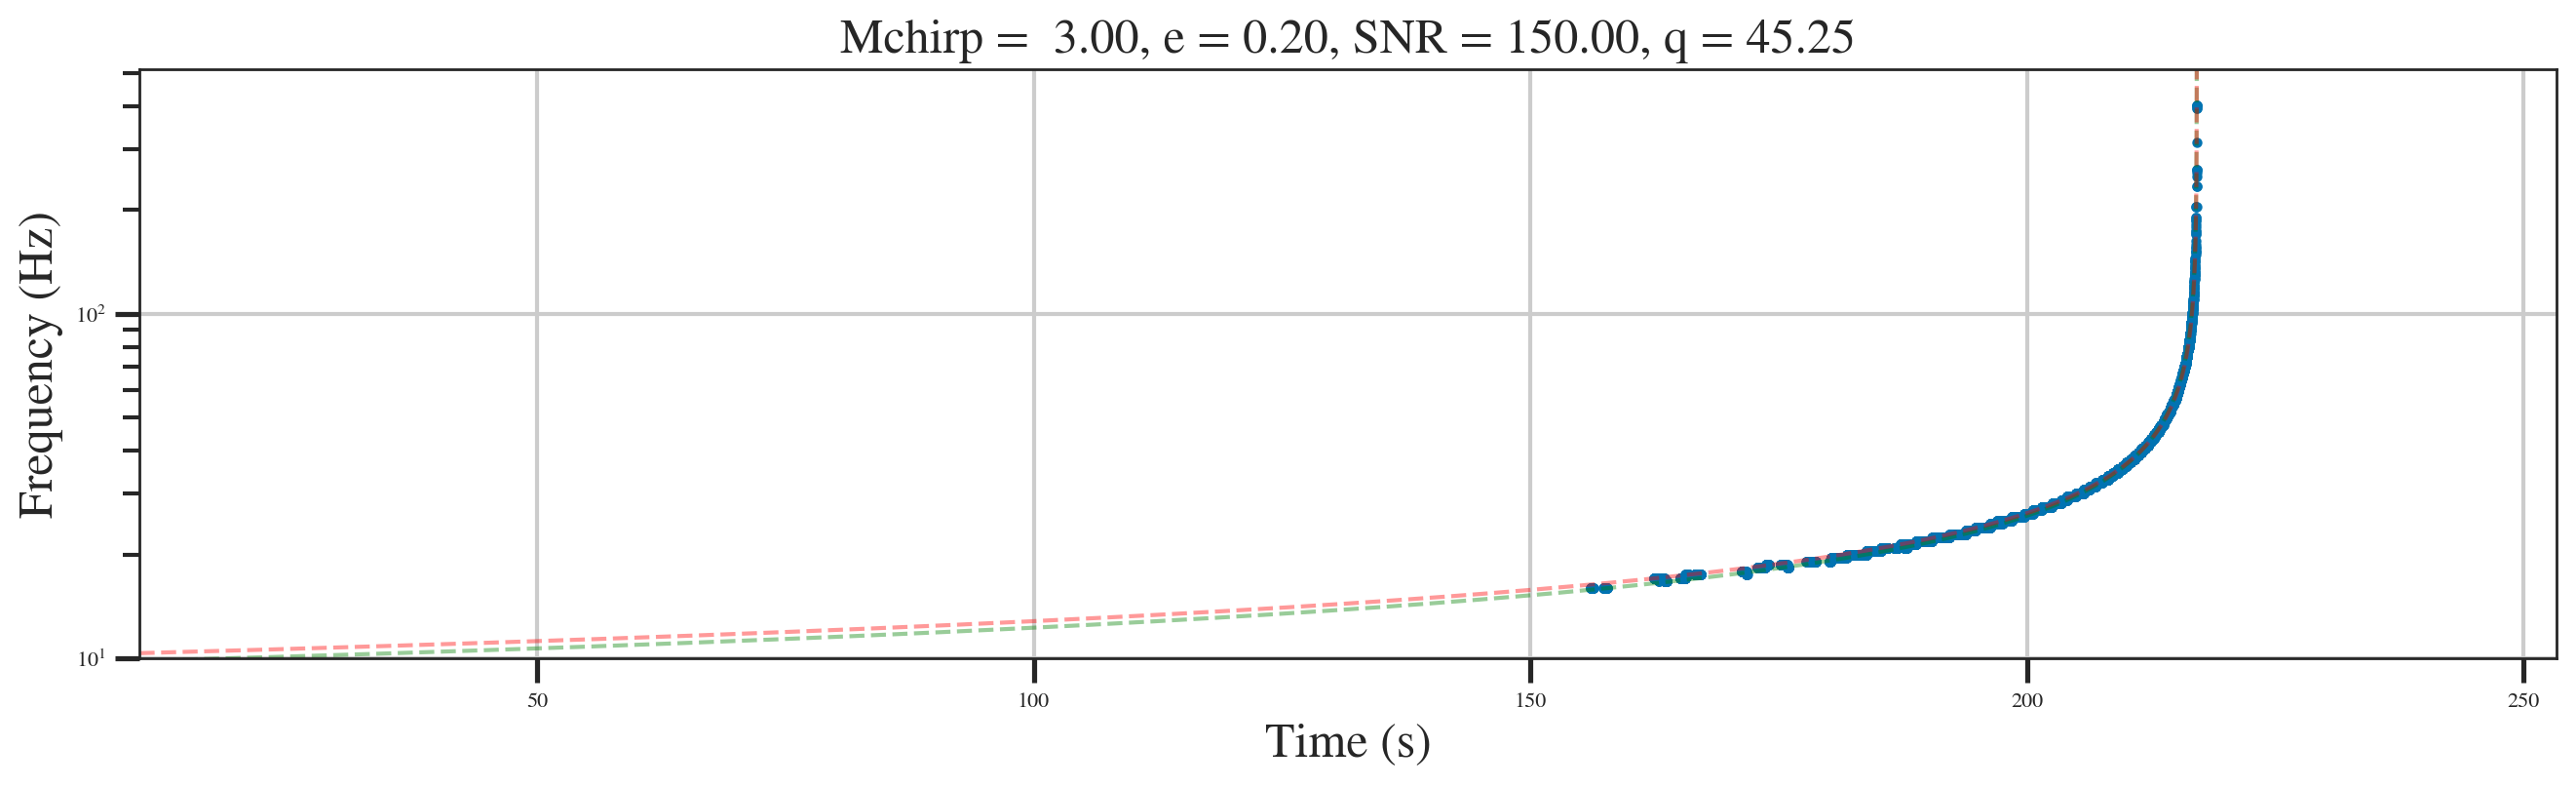

2022-04-14 08:31:28 Generating Fake Strain


0.3758028682098992
0.1271397295864432


2022-04-14 08:31:29 Generating waveform
2022-04-14 08:32:03 Tapering TimeSeries and scaling its SNR
2022-04-14 08:32:03 Generating frequency domain version of the waveform
2022-04-14 08:32:03 Applying injections
2022-04-14 08:32:03 $case=6,mchirp=3.00,~e=0.25,~\iota=2.41,~\varphi_c=2.21,~ra=0.35,~dec=2.08,~SNR=150.00$


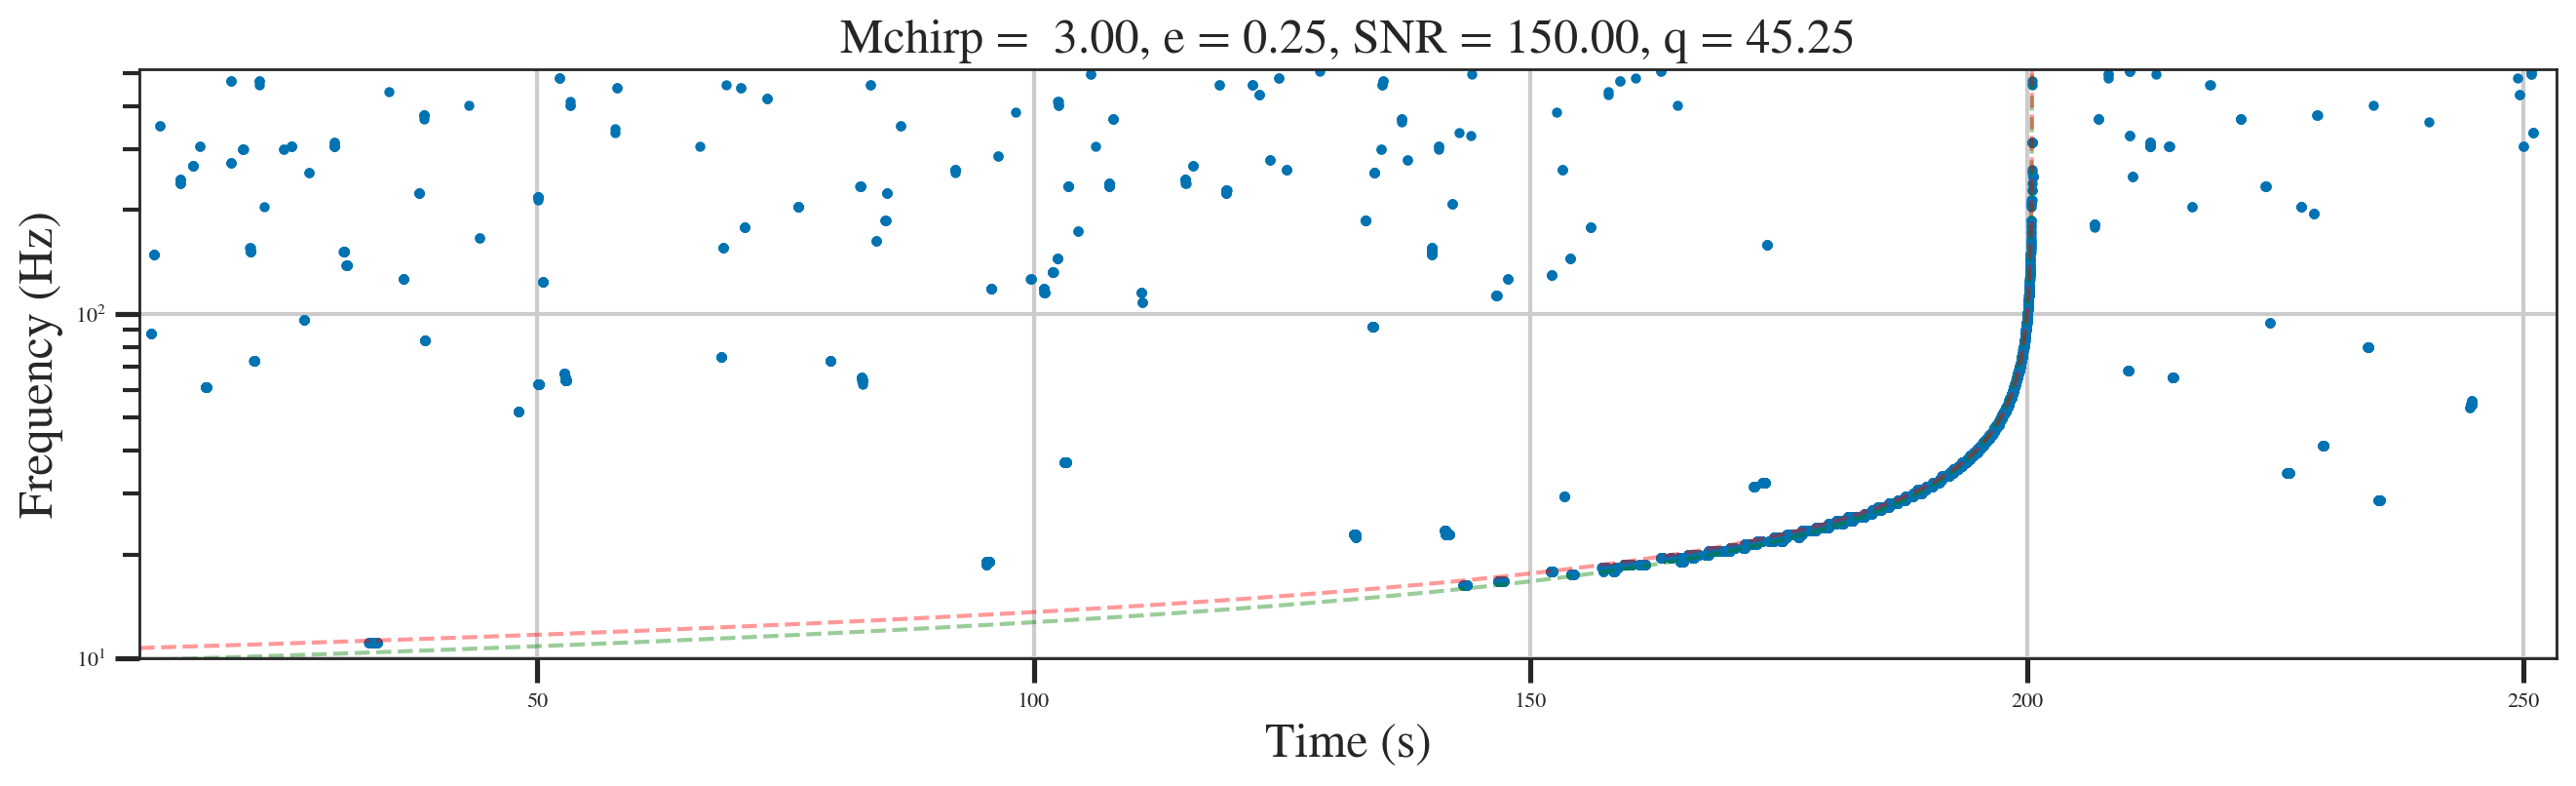

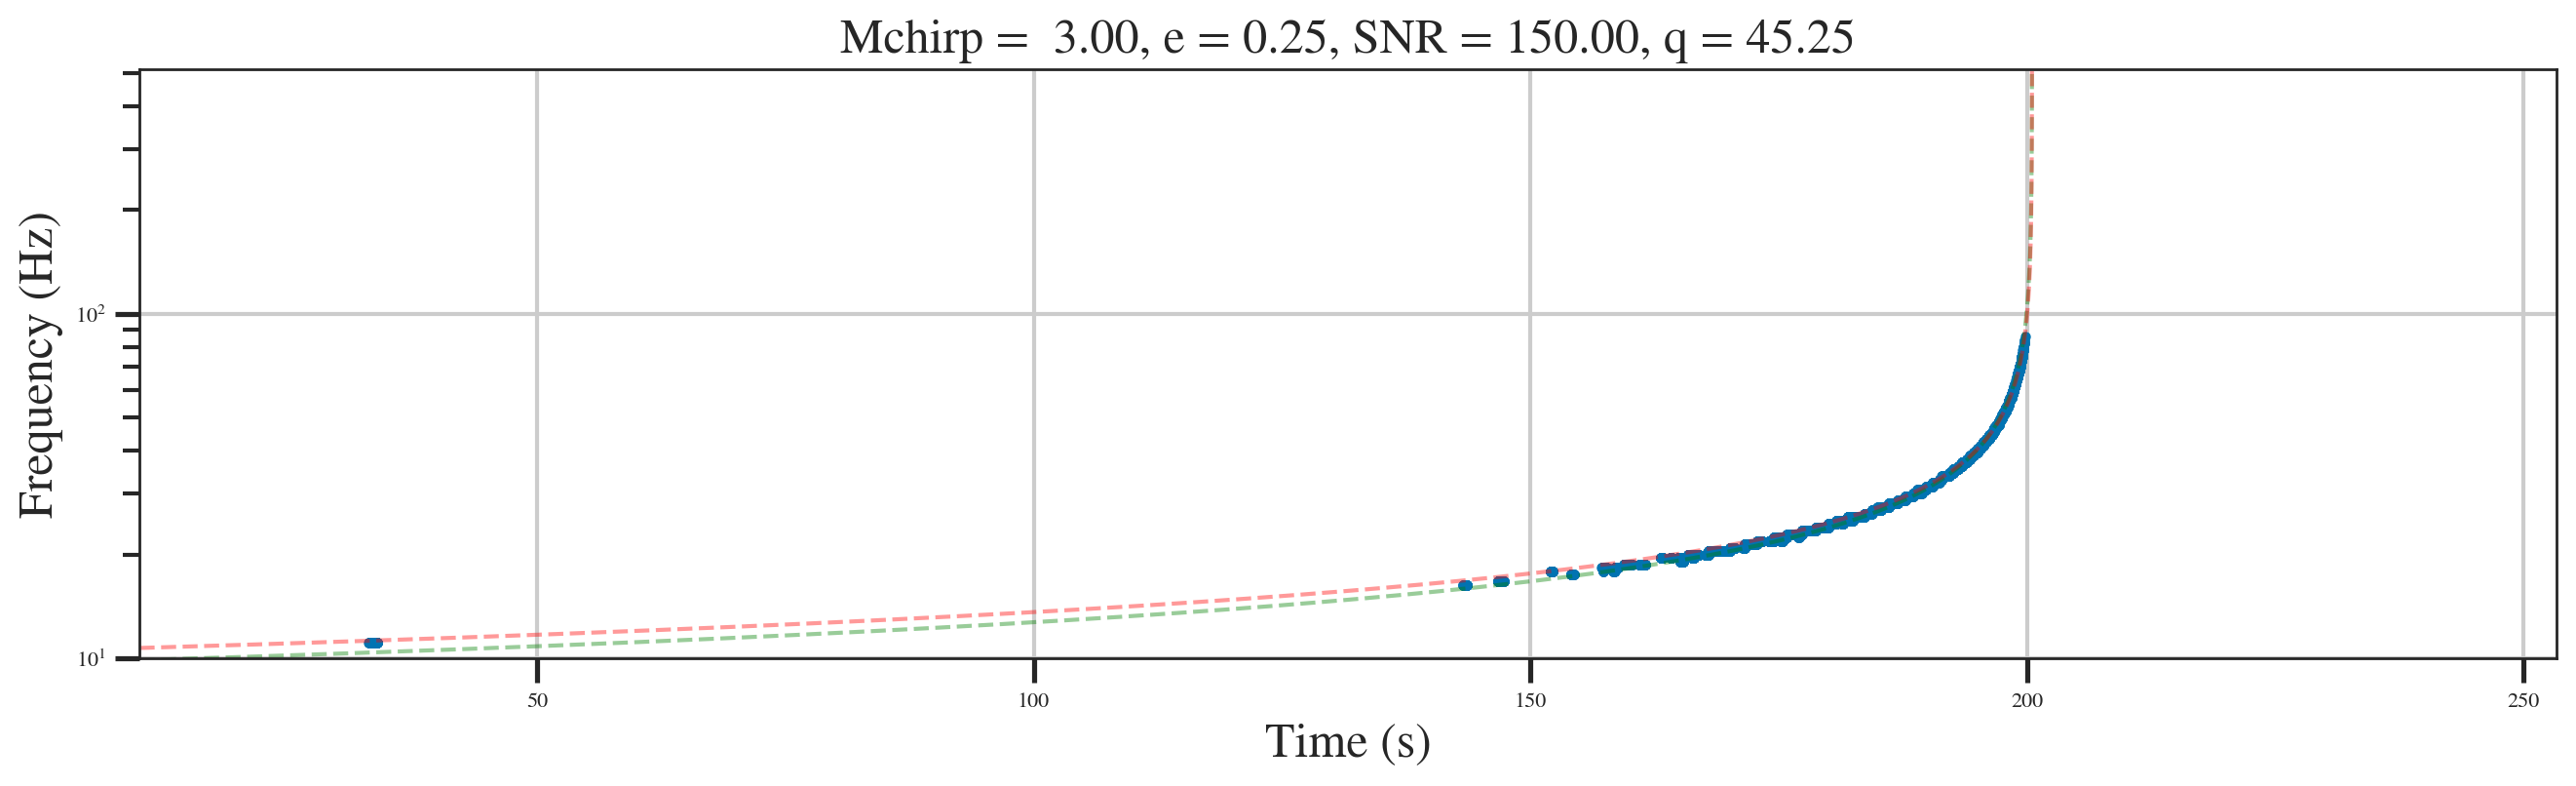

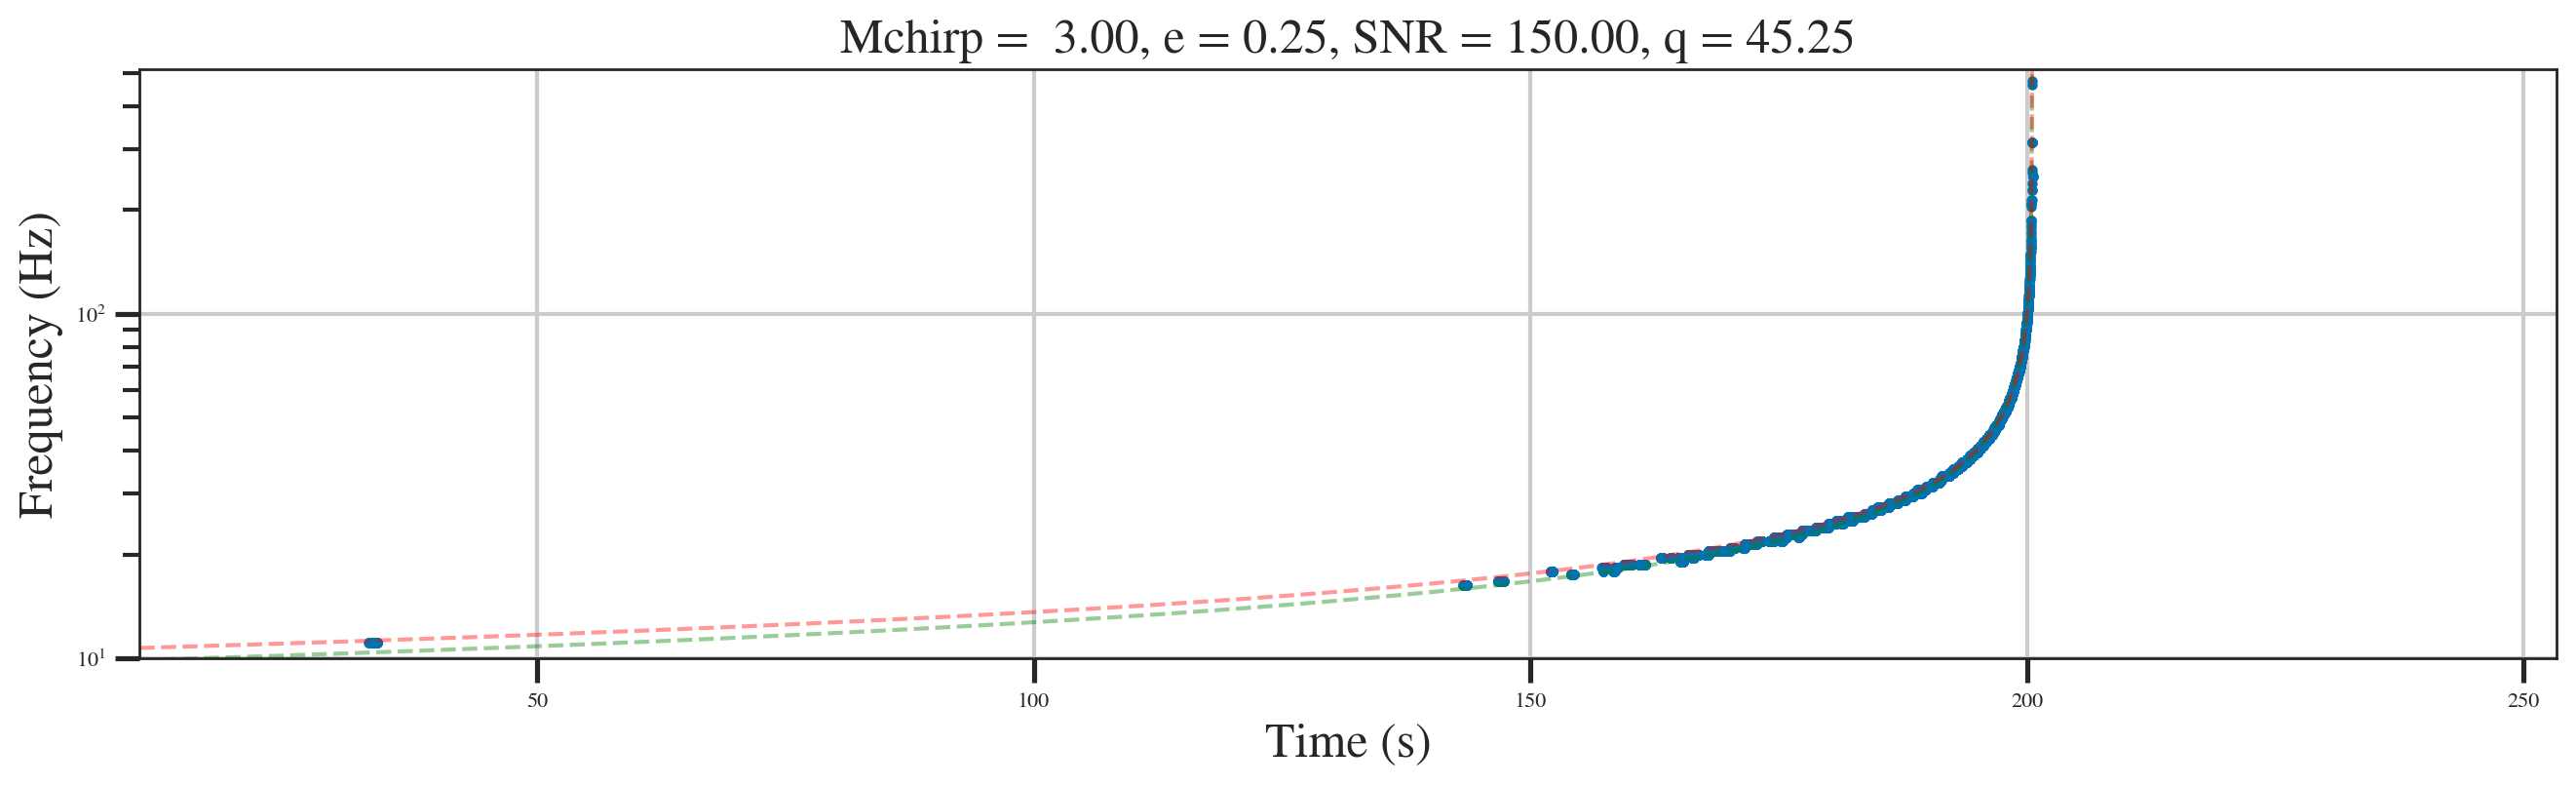

2022-04-14 08:32:46 Generating Fake Strain


0.5331788827182821
0.292823025328279


2022-04-14 08:32:47 Generating waveform
2022-04-14 08:33:17 Tapering TimeSeries and scaling its SNR
2022-04-14 08:33:17 Generating frequency domain version of the waveform
2022-04-14 08:33:18 Applying injections
2022-04-14 08:33:18 $case=7,mchirp=3.00,~e=0.30,~\iota=1.75,~\varphi_c=2.20,~ra=2.98,~dec=2.25,~SNR=150.00$


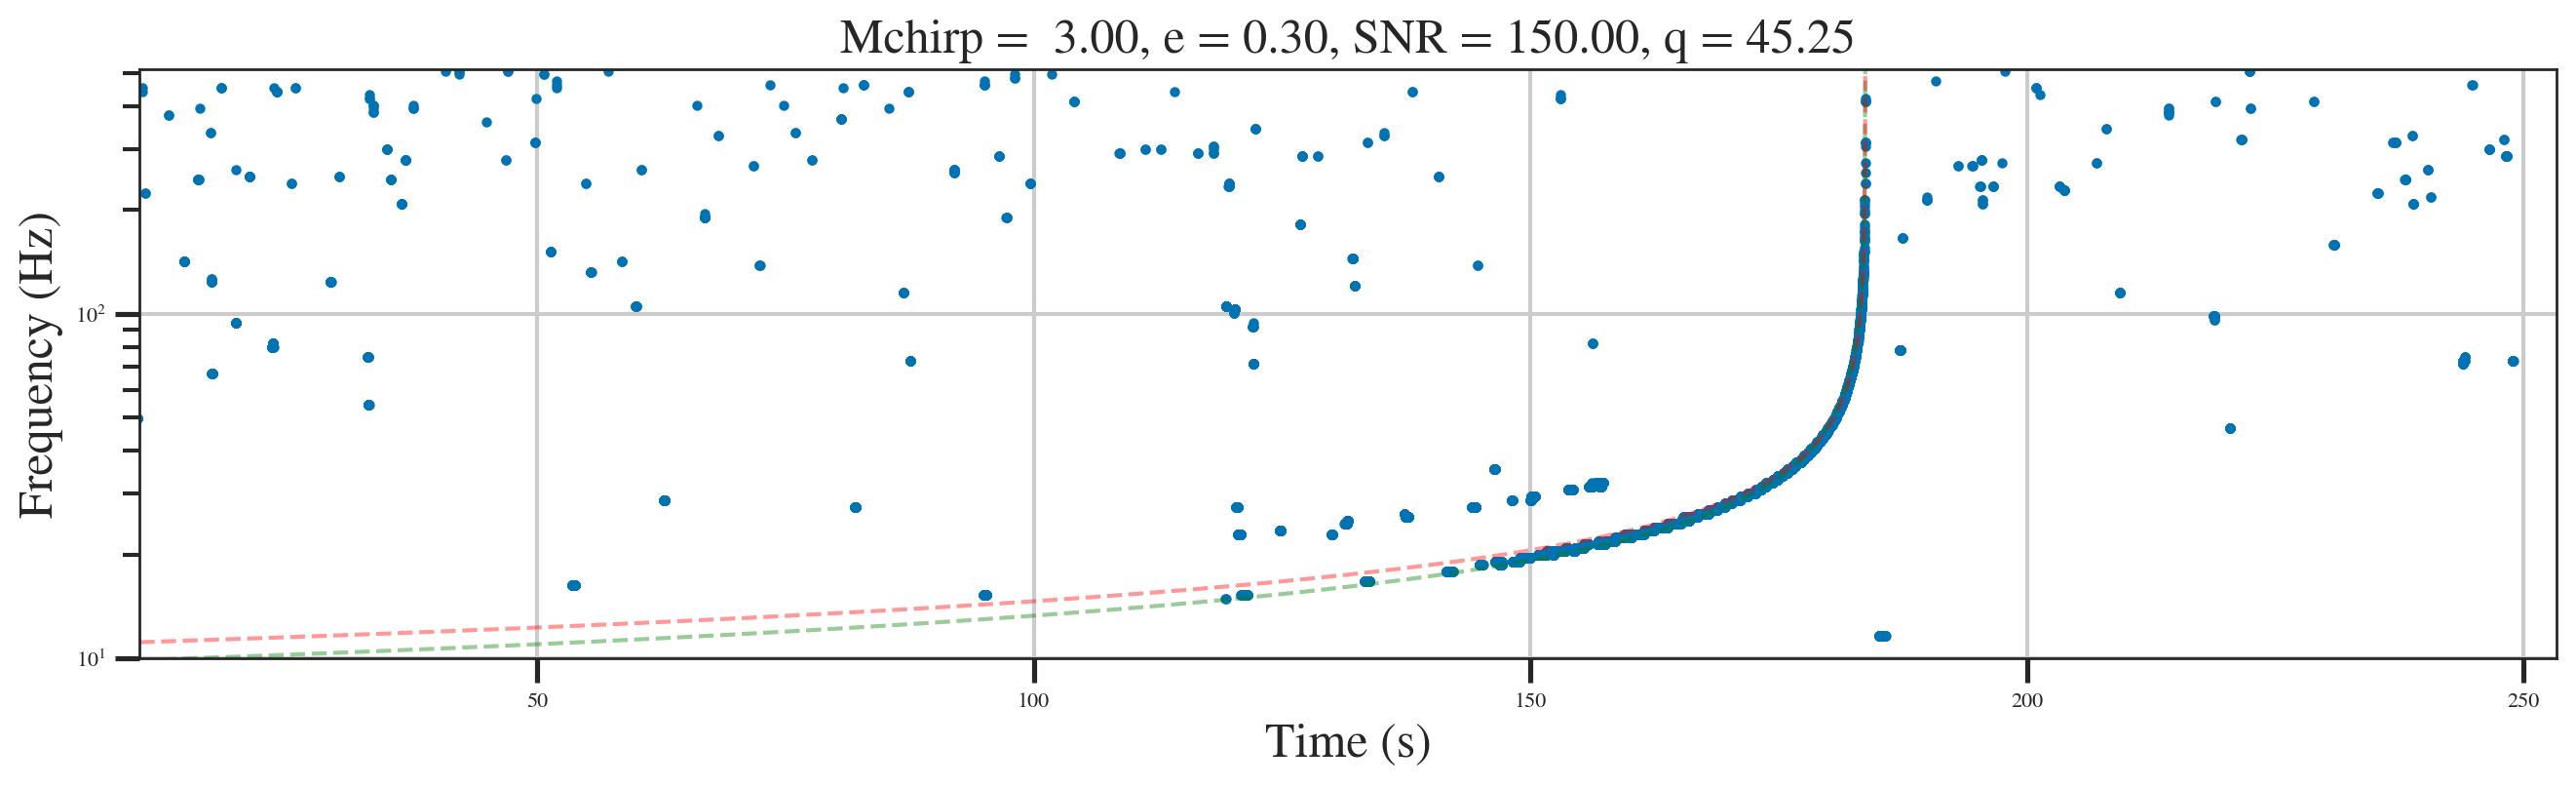

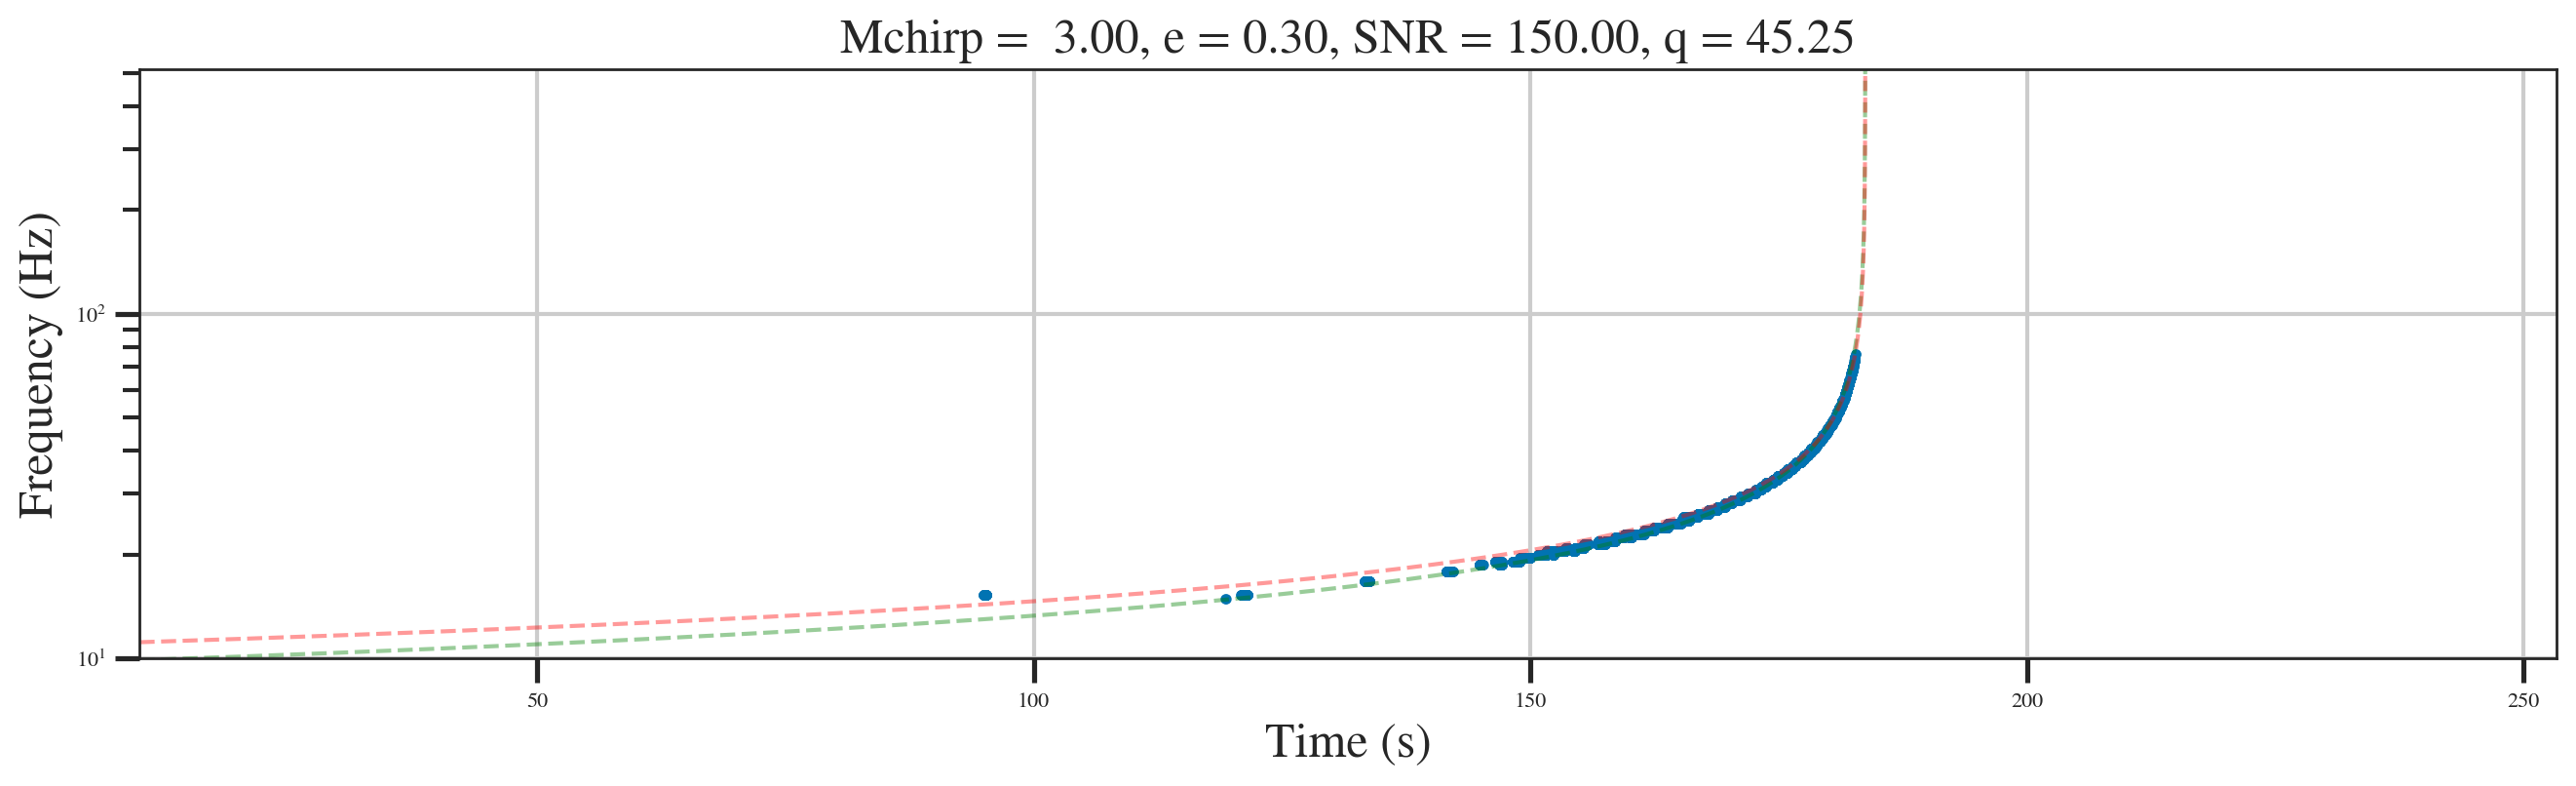

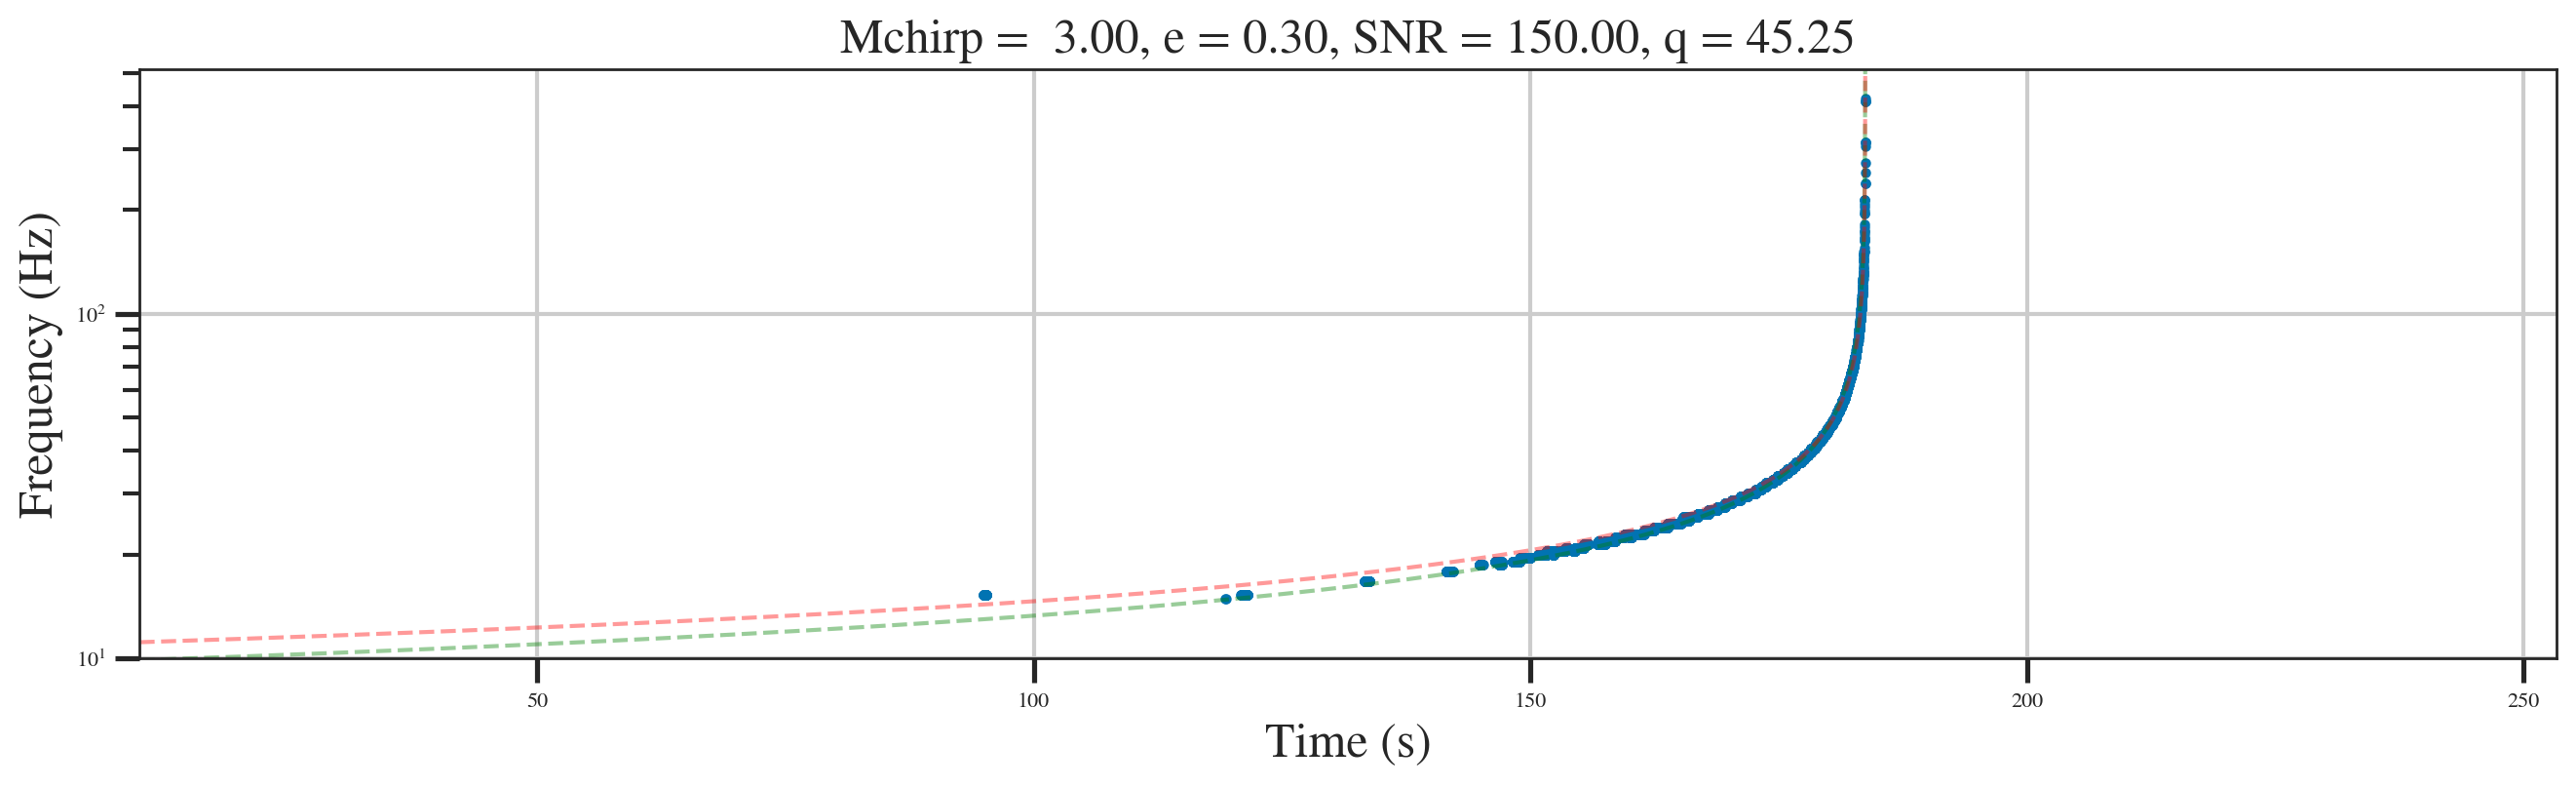

2022-04-14 08:34:00 Generating Fake Strain


0.7197751876712081
0.7076414393478085


2022-04-14 08:34:01 Generating waveform
2022-04-14 08:34:28 Tapering TimeSeries and scaling its SNR
2022-04-14 08:34:28 Generating frequency domain version of the waveform
2022-04-14 08:34:28 Applying injections
2022-04-14 08:34:28 $case=8,mchirp=3.00,~e=0.35,~\iota=2.54,~\varphi_c=0.14,~ra=2.64,~dec=2.61,~SNR=150.00$


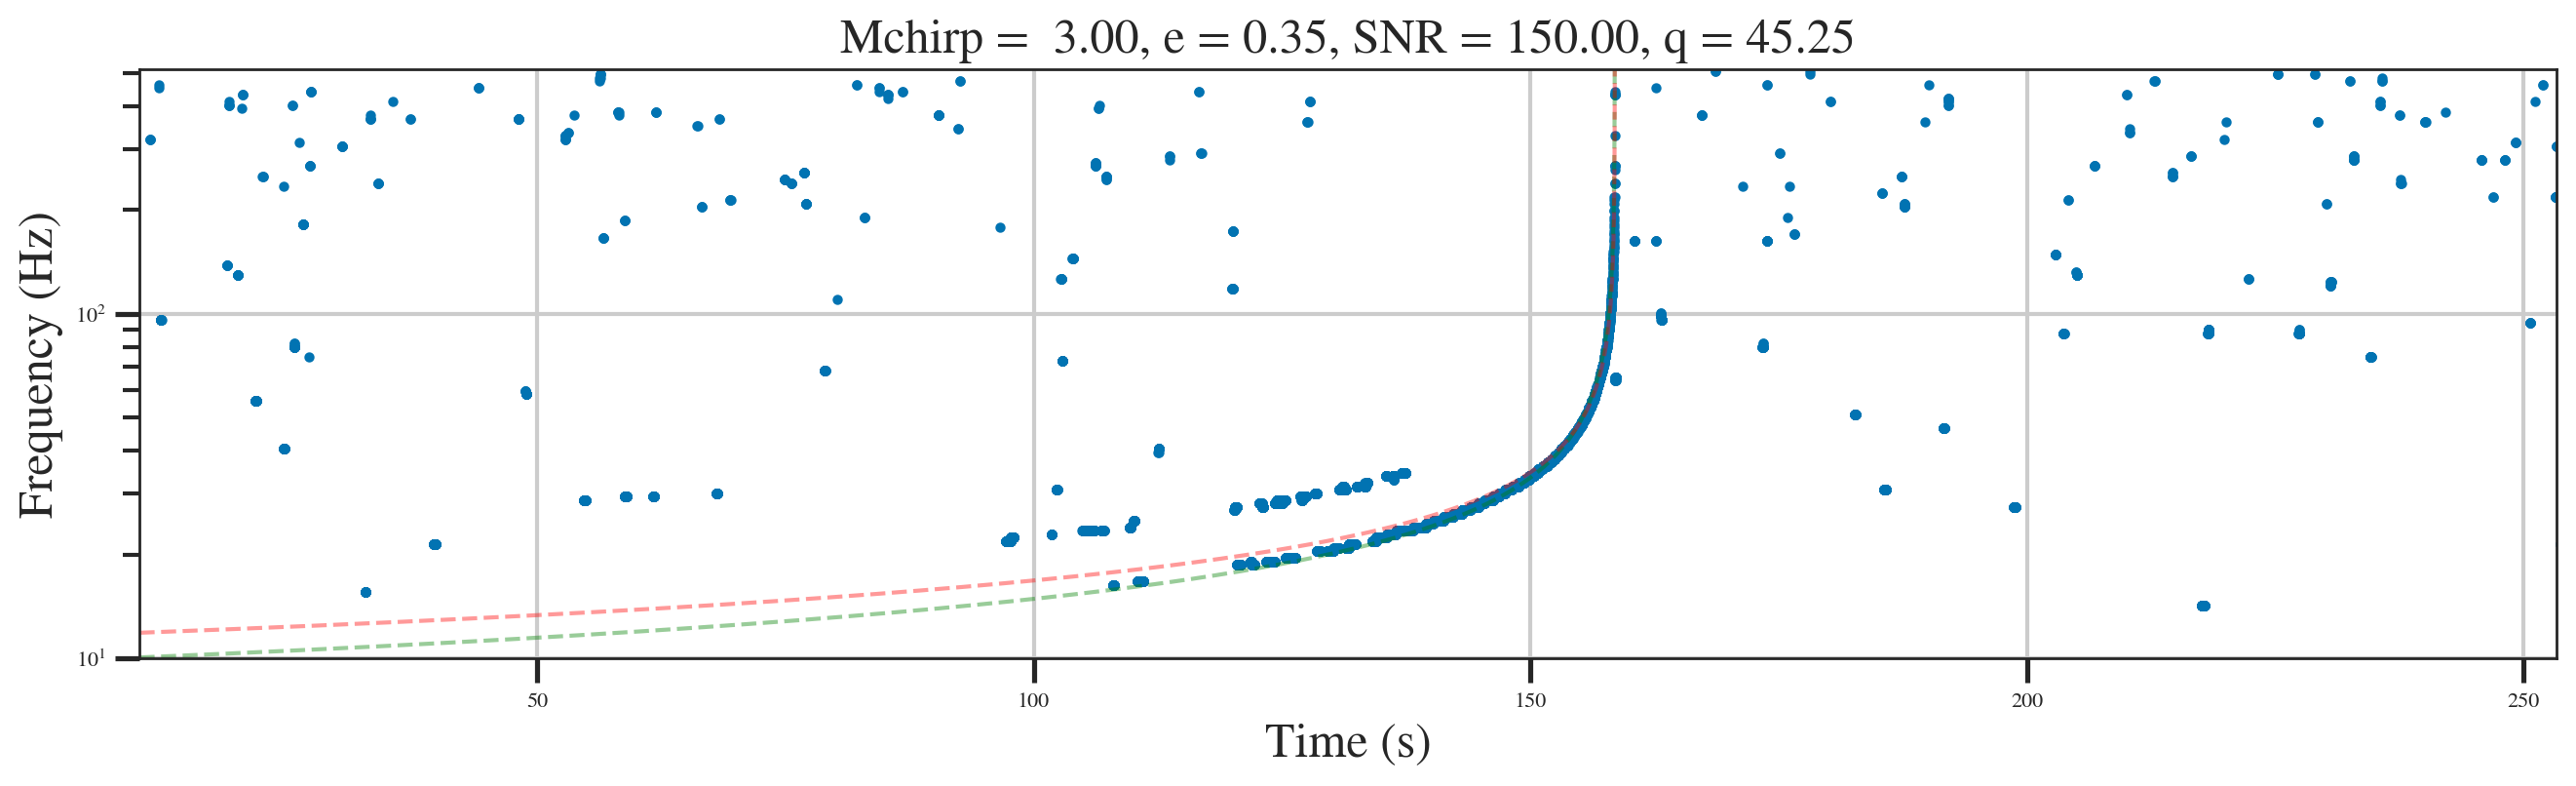

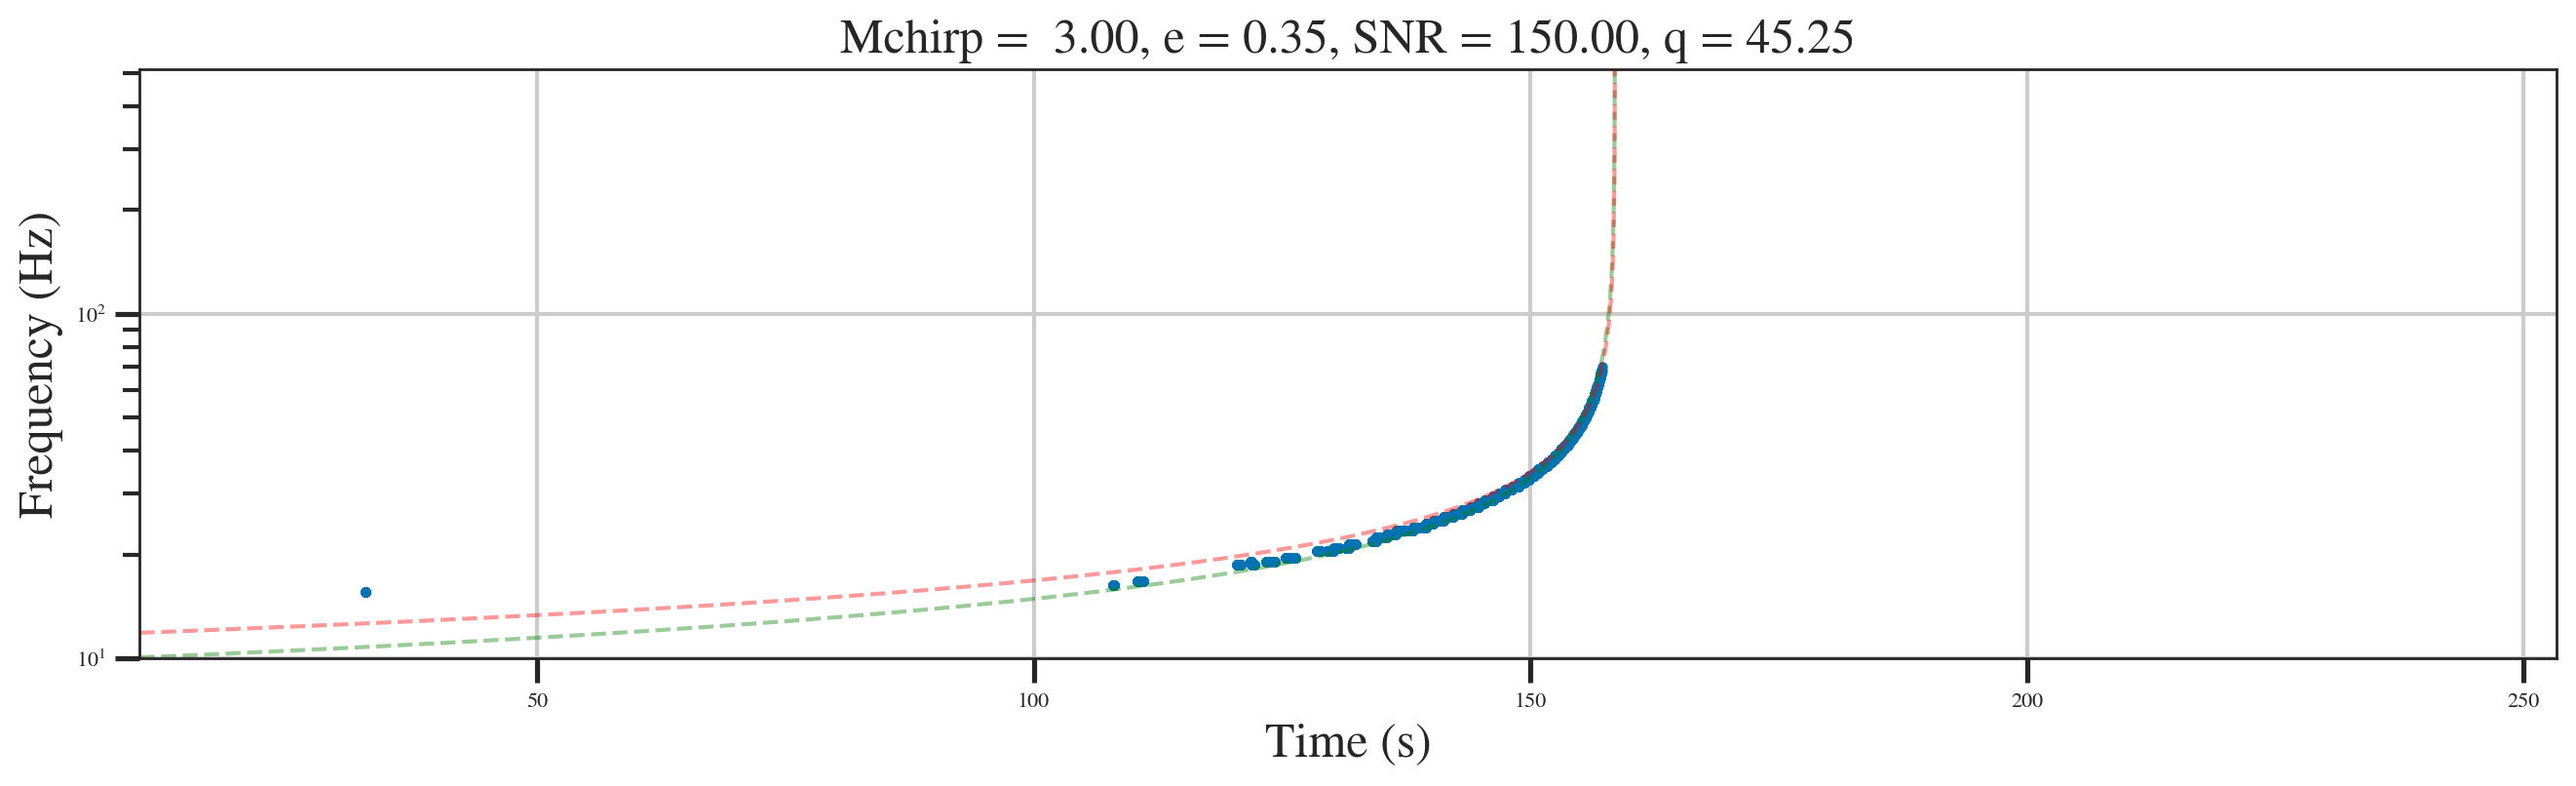

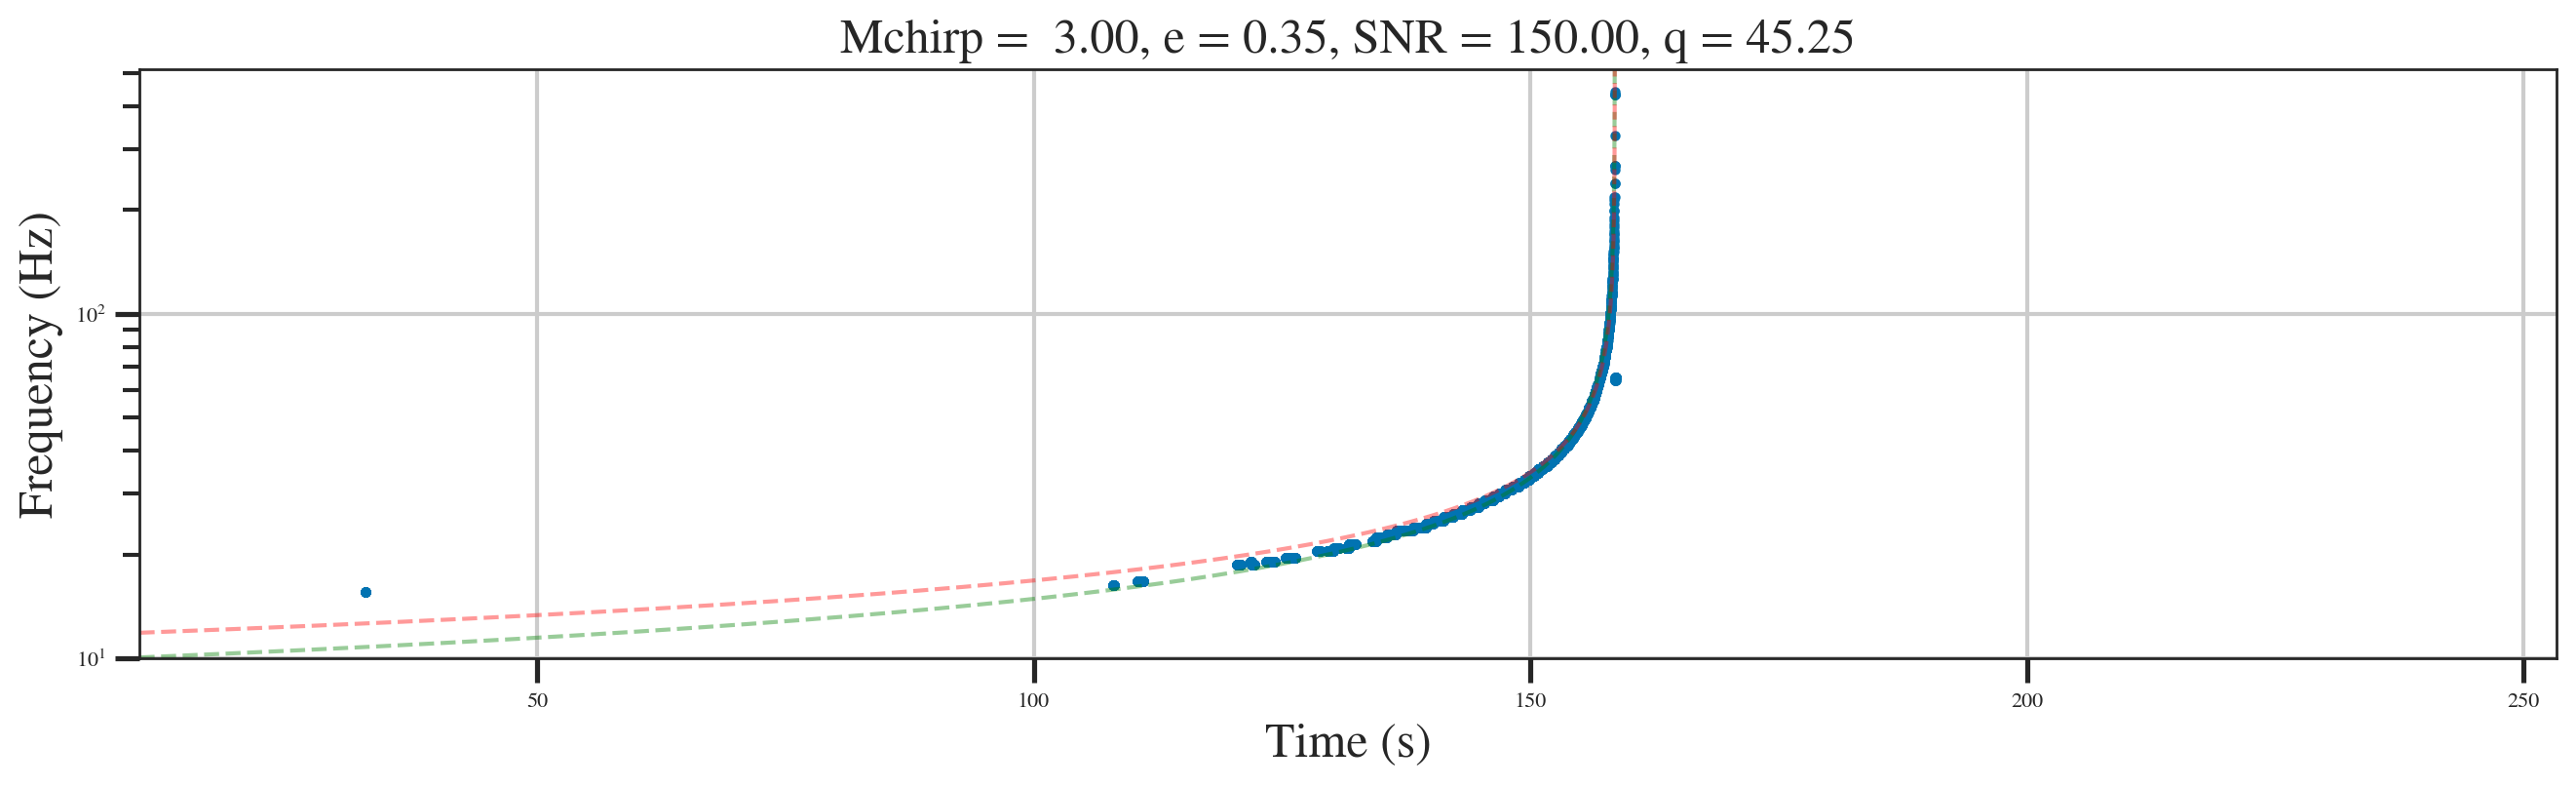

2022-04-14 08:35:11 Generating Fake Strain


1.0228149568009328
1.5137419688841722


2022-04-14 08:35:11 Generating waveform
2022-04-14 08:35:34 Tapering TimeSeries and scaling its SNR
2022-04-14 08:35:34 Generating frequency domain version of the waveform
2022-04-14 08:35:34 Applying injections
2022-04-14 08:35:34 $case=9,mchirp=3.00,~e=0.40,~\iota=0.97,~\varphi_c=1.50,~ra=0.80,~dec=1.60,~SNR=150.00$


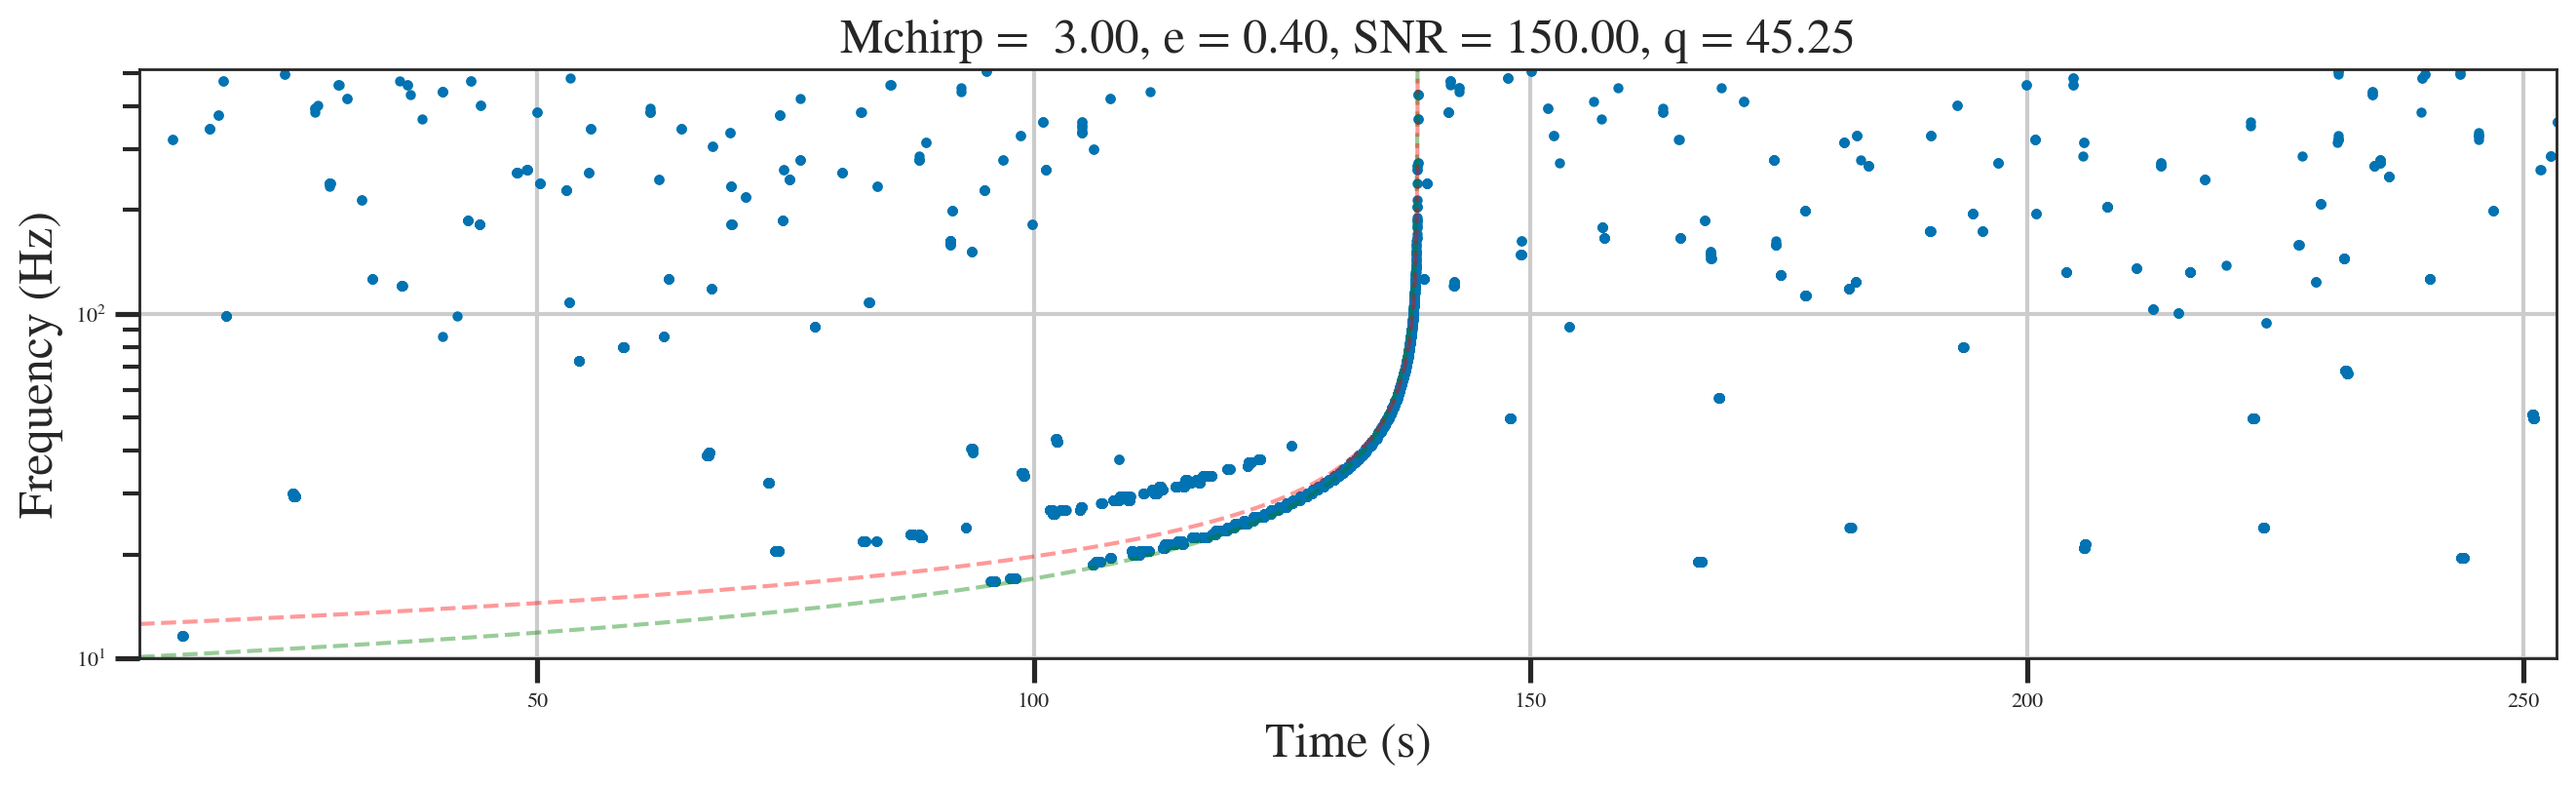

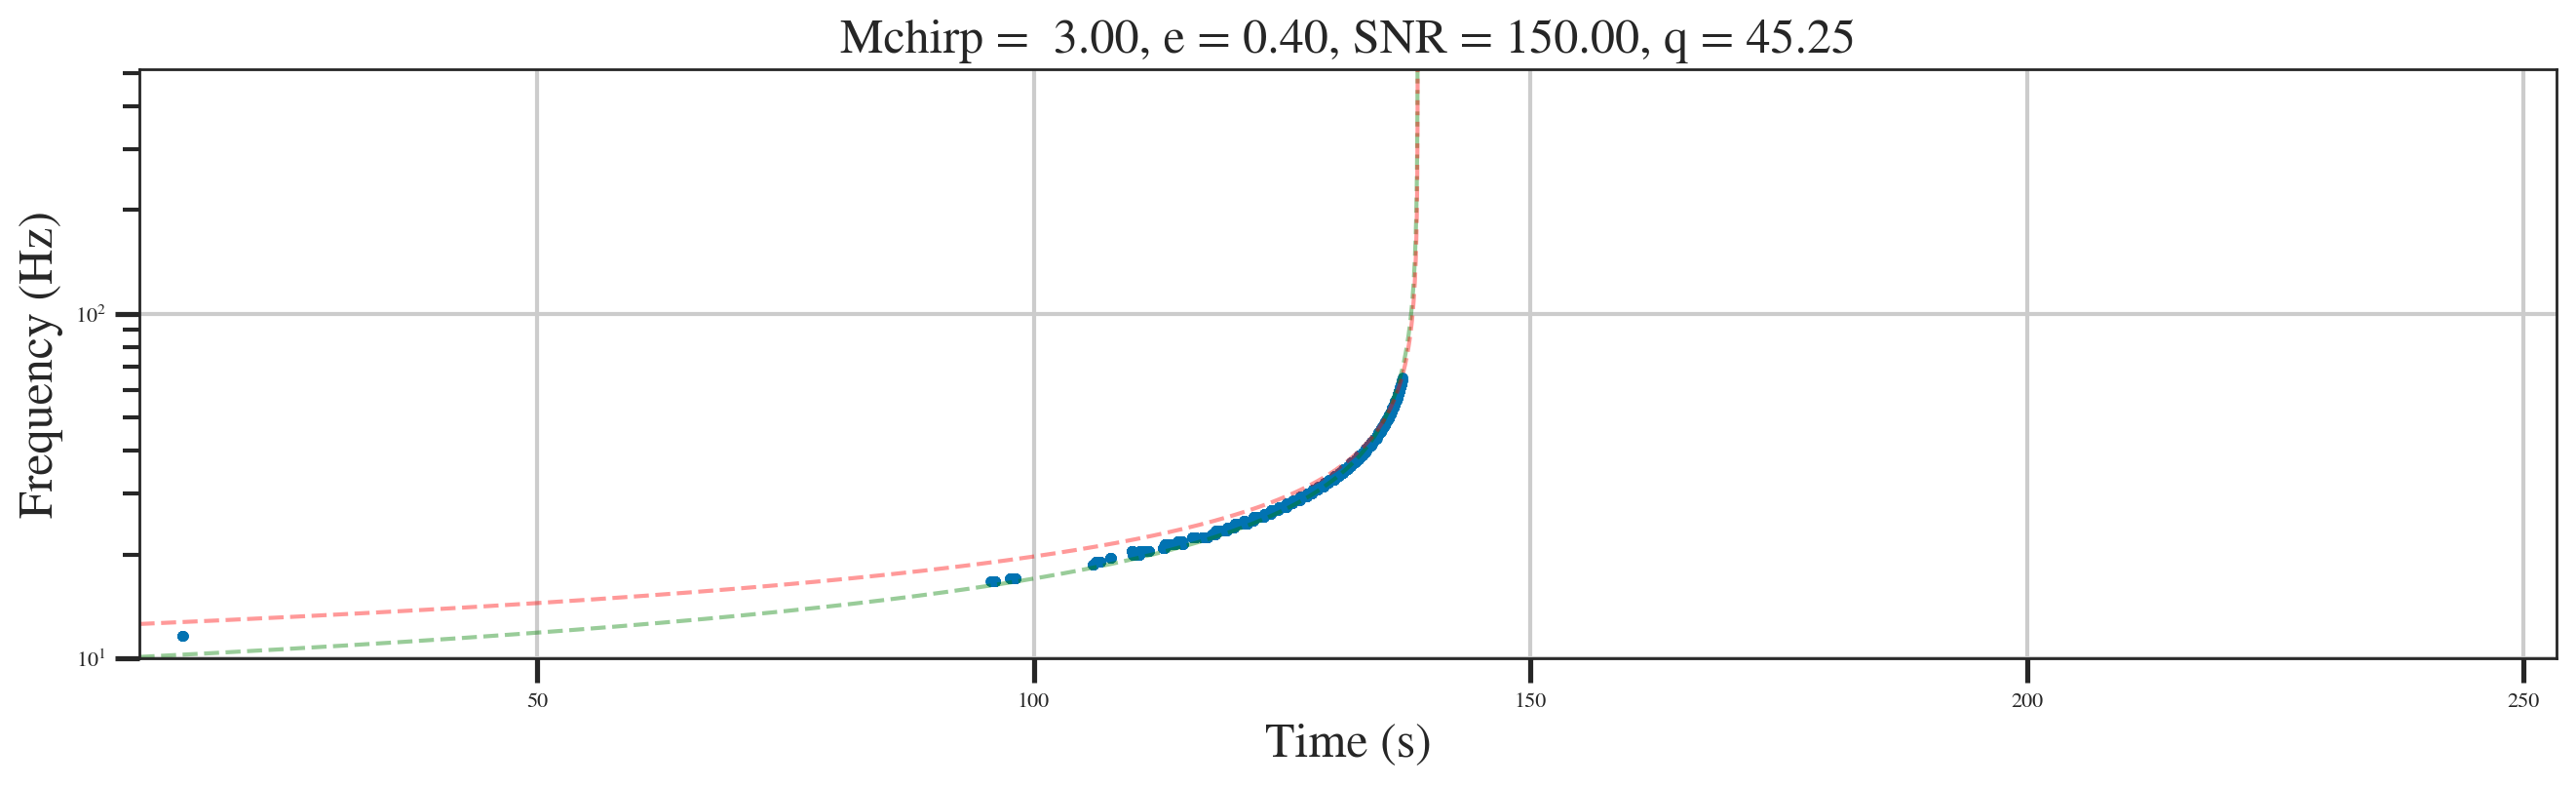

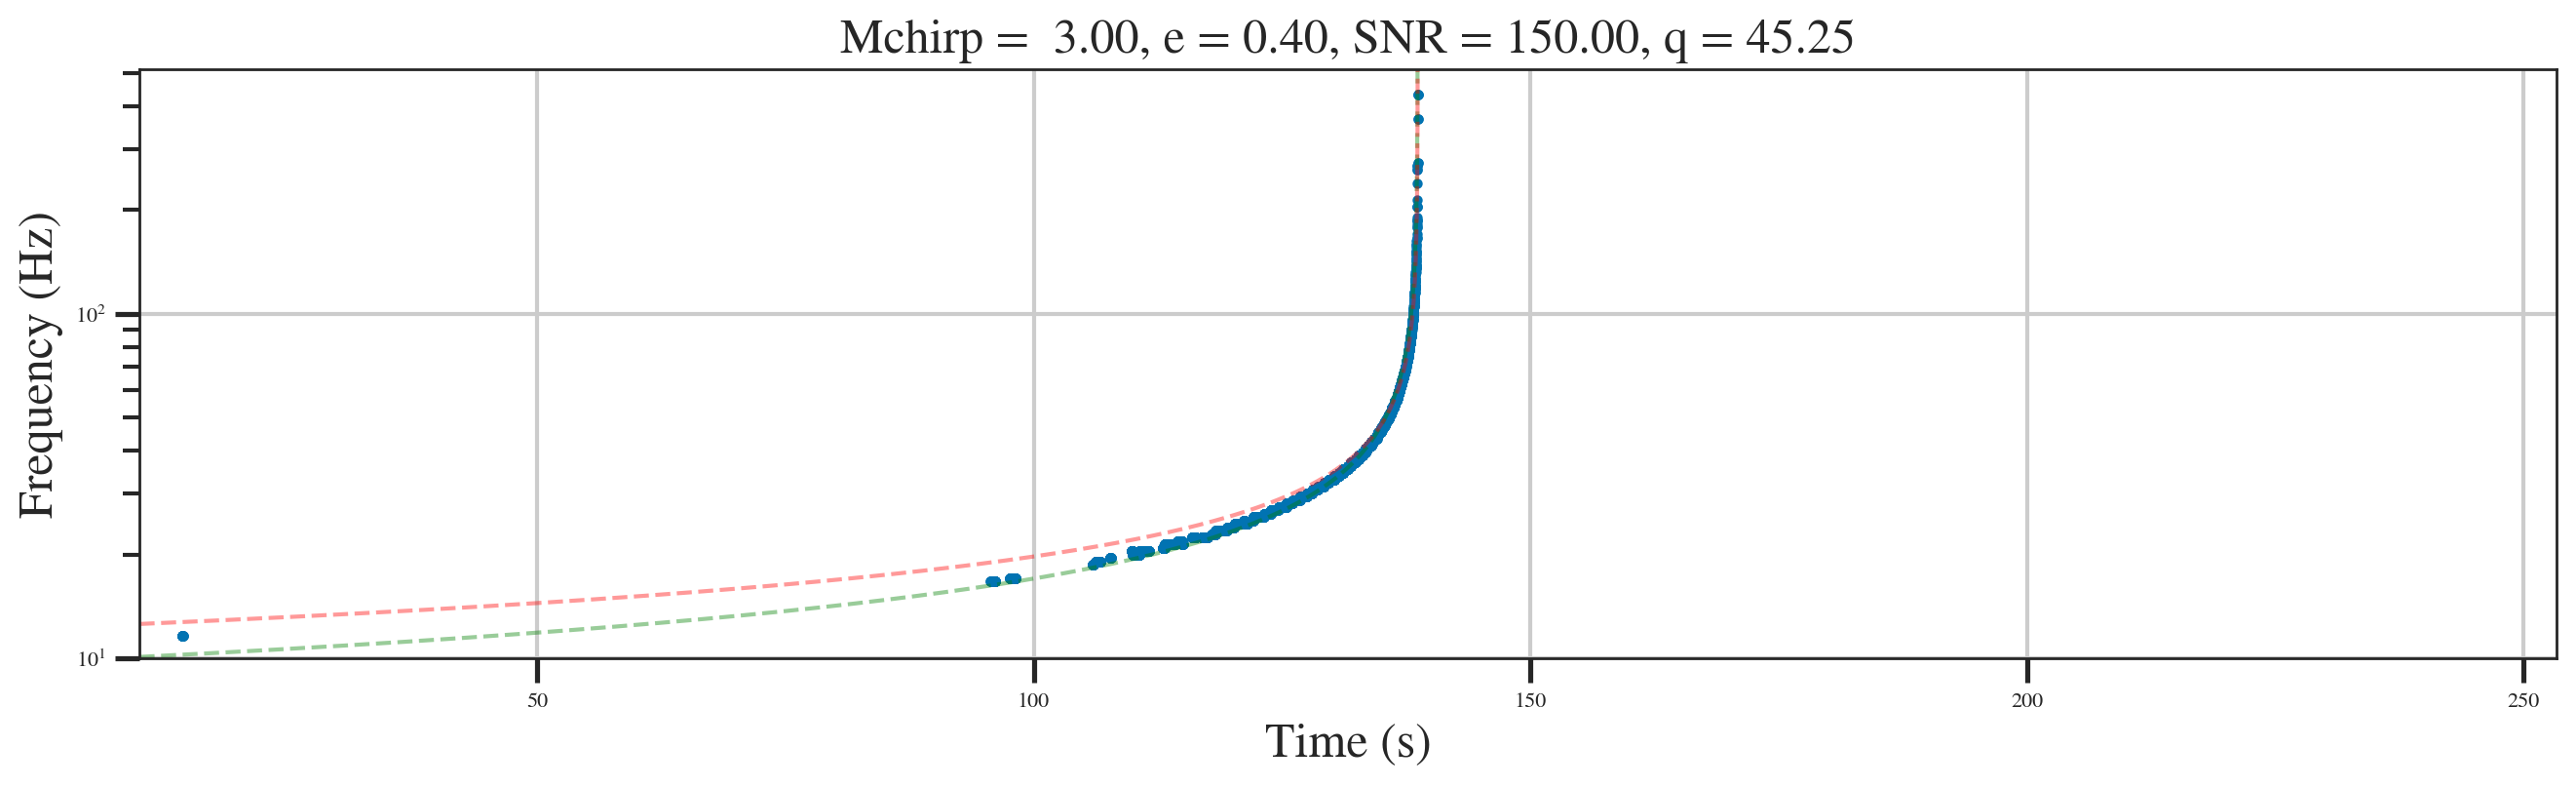

1.132161597733349
3.233826112342796
[[0.15738304616203935, 0.1667427957055995, 0.24980555331869875, 0.513318403411803, 0.3758028682098992, 0.5331788827182821, 0.7197751876712081, 1.0228149568009328, 1.132161597733349]]
[[0.15955436917473412, 0.14648834890280754, 0.17855052001144456, 0.3369859785524461, 0.1271397295864432, 0.292823025328279, 0.7076414393478085, 1.5137419688841722, 3.233826112342796]]


In [ ]:
ms = np.linspace(3, 3, 1)
es = np.linspace(0,0.4,9)
i = 1
std_mine = []
std_mine1 = []
std_nirban = []
std_nirban1 = []
for j in range(len(ms)):
    for k in range(len(es)):
        #generating strain timeseries
        data_zoom, inj_mchirp , inj_eccentricity,tc, snr= get_timeseries(mchirp_low=ms[j], 
                       mchirq_high=ms[j], 
                       min_mratio=1, 
                       max_mratio=1,
                       min_snr=150,
                       max_snr=150,
                       min_eccentricity=es[k]+0.00001 if es[k]==0 else es[k],
                       max_eccentricity=es[k]+0.00001 if es[k]==0 else es[k],
                       get_image=False,
                       get_strain_zoom = False,
                       case=i)
        #perform qtransform of the timeseries, and compare with model
        qrange = [16,64]
        min_f = 10
        max_f = 512
        max_key, times, freqs, power = qtransform(data_zoom,1/200,qrange=qrange,frange=(min_f,max_f))
        freqs1 = []
        for g in range(len(times)):
          ind = argmax(power[:, g])
          if(max(power[:,g])> 12):
            freqs1.append(freqs[ind])
          else:
            freqs1.append(np.nan)
        #plotting Q-transform
        pylab.figure(figsize=(16,4))
        pylab.grid(zorder=1)
        pylab.ylim(10, 512)
        pylab.xlim(10, 760/ms[j])
        pylab.xlabel('Time (s)')
        pylab.ylabel('Frequency (Hz)')
        pylab.yscale('log')
        pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}, SNR = {snr:0.2f}, q = {max_key:0.2f}')
        #generating and superimposng f(t) from the model
        pylab.scatter(times, freqs1, s=5)
        fx = freq_gen(ml[k][j], sl[k][j], times, tc)
        pylab.plot(times, fx,"--", color = "green", alpha = 0.4, lw = 1.5)
        # fy = freq_gen2(m1[0], m, times, tc)
        # pylab.plot(times, fy, "--", color = "white", alpha = 1, lw = 1.5)
        fs = gen_freq(ms[j],es[k],times,tc)
        pylab.plot(times, fs, "--", color = "red", alpha = 0.4, lw = 1.5)
        # pylab.savefig("("+str(ms[j])+", "+str(es[k])+").png")
        # files.download("("+str(ms[j])+", "+str(es[k])+").png")
        pylab.show()
        index_max = np.argmax(fx)
        # print(times[index_max])
        idx_filter = np.abs(fx - freqs1) < 5
        frq_1 = np.array(freqs1)
        frq1 = np.append(frq_1[idx_filter], frq_1[(times > np.ceil(times[index_max]-10)) * (times < np.ceil(times[index_max]))])
        frq2 = frq_1[idx_filter]
        times1 = np.append(times[idx_filter], times[(times > np.ceil(times[index_max]-10)) * (times < np.ceil(times[index_max]))])
        times2 = times[idx_filter]
        fx1 = np.append(fx[idx_filter], fx[(times > np.ceil(times[index_max]-10)) * (times < np.ceil(times[index_max]))])
        fx2 = fx[idx_filter]
        fs1 = np.append(fs[idx_filter], fs[(times > np.ceil(times[index_max]-10)) * (times < np.ceil(times[index_max]))])
        fs2 = fs[idx_filter]
        pylab.figure(figsize=(16,4))
        pylab.grid(zorder=1)
        pylab.ylim(10, 512)
        pylab.xlim(10, 760/ms[j])
        pylab.xlabel('Time (s)')
        pylab.ylabel('Frequency (Hz)')
        pylab.yscale('log')
        pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}, SNR = {snr:0.2f}, q = {max_key:0.2f}')
        pylab.scatter(times2, frq2, s=5)
        pylab.plot(times, fx,"--", color = "green", alpha = 0.4, lw = 1.5)
        pylab.plot(times, fs, "--", color = "red", alpha = 0.4, lw = 1.5)
        pylab.show()
        pylab.figure(figsize=(16,4))
        pylab.grid(zorder=1)
        pylab.ylim(10, 512)
        pylab.xlim(10, 760/ms[j])
        pylab.xlabel('Time (s)')
        pylab.ylabel('Frequency (Hz)')
        pylab.yscale('log')
        pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}, SNR = {snr:0.2f}, q = {max_key:0.2f}')
        pylab.scatter(times1, frq1, s=5)
        pylab.plot(times, fx,"--", color = "green", alpha = 0.4, lw = 1.5)
        pylab.plot(times, fs, "--", color = "red", alpha = 0.4, lw = 1.5)
        pylab.show()

        std1 = np.square(fx2 - frq2)
        # std1 = std1[~np.isnan(std1)]
        N1 = len(std1)
        std1 = np.sum(std1)
        std_1 = std1 / N1
        print(std_1)

        std_mine1.append(std_1)

        std2 = np.square(fs2 - frq2)
        # std2 = std2[~np.isnan(std2)]
        N2 = len(std2)
        std2 = np.sum(std2)
        std_2 = std2 / N2
        print(std_2)
        std_nirban1.append(std_2)
        
        i+=1

    std_mine.append(std_mine1)
    std_mine1 = []
    
    std_nirban.append(std_nirban1)
    std_nirban1 = []

print(std_mine)
print(std_nirban)
      

In [ ]:
np.savetxt('std_mine.txt', std_mine)
np.savetxt('std_nirban.txt', std_nirban)
files.download('std_mine.txt')
files.download('std_nirban.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
std_mine2 = np.array(std_mine)
print(std_mine2)
std_nirban2 = np.array(std_nirban)
print(std_nirban2)
std_mine3 = std_mine2
std_nirban3 = std_nirban2

NameError: ignored

In [ ]:
# std_nirban3[10][8] = 0
# std_nirban3[11][8] = 0
# std_nirban3[12][7] = 0
# std_nirban3[12][8] = 0
# std_nirban3[13][7] = 0
# std_nirban3[13][8] = 0
# std_nirban3[14][7] = 0
# std_nirban3[14][8] = 0
# std_nirban3[15][7] = 0
# std_nirban3[15][8] = 0
# std_nirban3[16][7] = 0
# std_nirban3[16][8] = 0
# std_nirban3[17][6] = 0
# std_nirban3[17][7] = 0
std_nirban3[17][8] = 0
print(std_nirban3)

[[8.46563343e-02 8.71547452e-02 6.74170163e-02 4.98585382e-02
  9.00091540e-02 2.44757985e-01 6.47411536e-01 1.55795646e+00
  3.36478513e+00]
 [8.35429495e-02 6.01426923e-02 4.76925322e-02 4.26560218e-02
  7.96180283e-02 2.24192710e-01 5.97990041e-01 1.37150103e+00
  2.63714369e+00]
 [6.07533340e-02 5.63490740e-02 4.22203865e-02 4.25786511e-02
  7.91254755e-02 2.22746489e-01 5.84824020e-01 1.19208678e+00
  2.20307407e+00]
 [5.60541621e-02 4.50924436e-02 3.46519833e-02 4.27956568e-02
  8.90997270e-02 2.04577044e-01 5.57750239e-01 1.16315885e+00
  1.94424584e+00]
 [5.02302878e-02 4.10436856e-02 3.46639713e-02 4.29523821e-02
  9.35716901e-02 2.35443589e-01 4.91758627e-01 8.61605252e-01
  1.21057855e+00]
 [4.31294952e-02 4.37539004e-02 4.08650454e-02 4.68712683e-02
  9.06740325e-02 2.04067256e-01 4.67966005e-01 7.34473726e-01
  1.01964116e+00]
 [4.88699963e-02 4.46755306e-02 4.57339430e-02 4.92573063e-02
  1.40021168e-01 2.29546301e-01 4.40788184e-01 5.30845318e-01
  6.59147356e-01]
 [6.03

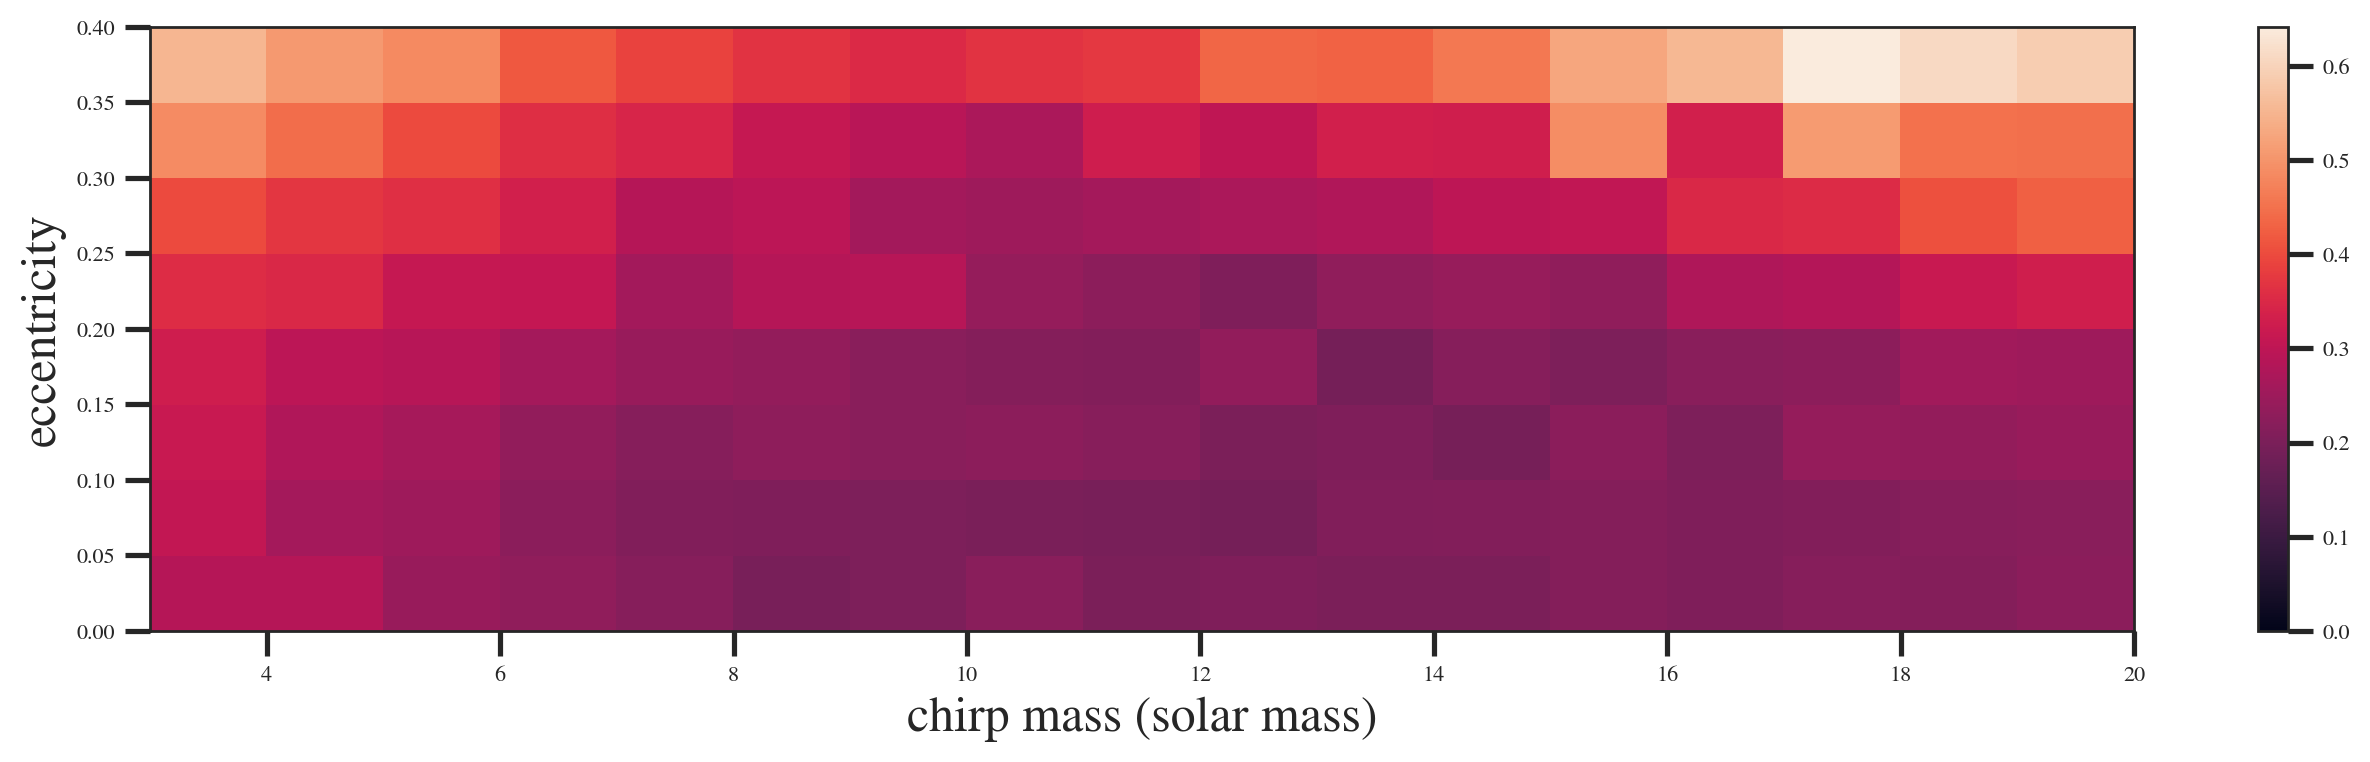

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_mine2.T**0.5, vmin=0,zorder=2)
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

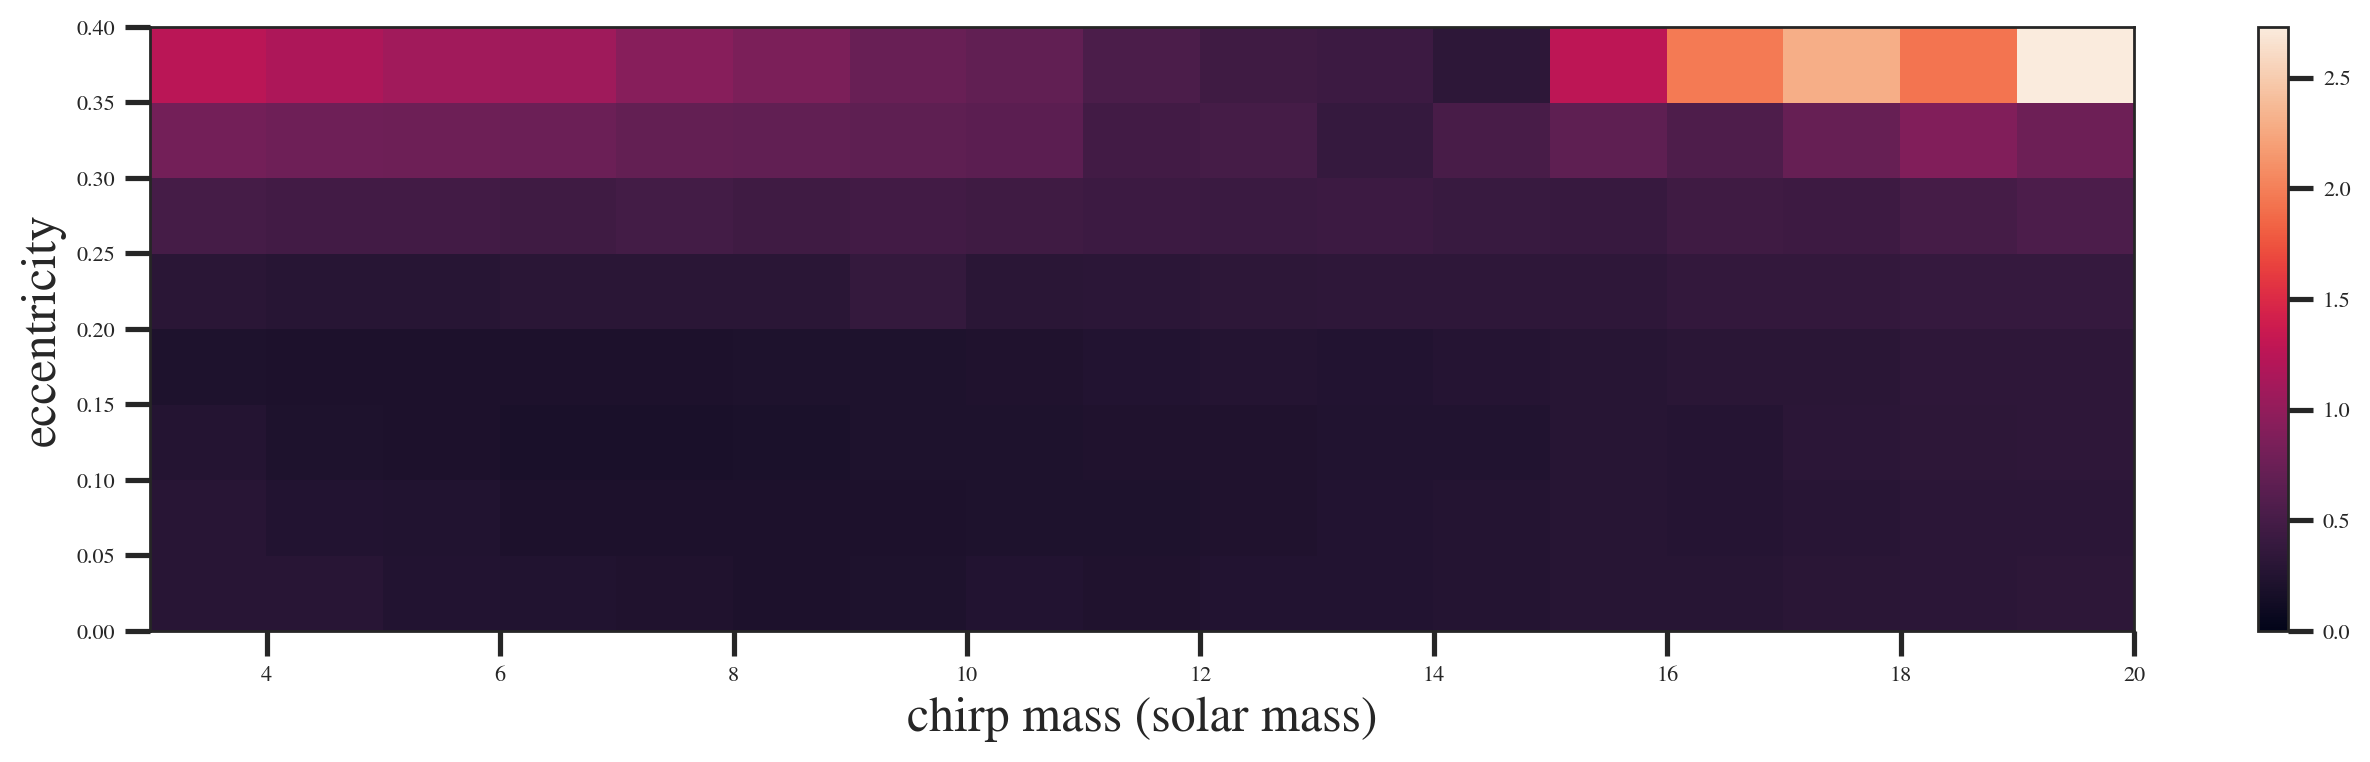

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_nirban3.T**0.5, vmin=0,zorder=2)
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

In [ ]:
for j in range(len(ms)):
    for k in range(len(es)):
        files.download("("+str(ms[j])+", "+str(es[k])+").png")


In [ ]:
ms = np.linspace(3,20,18)
es = np.linspace(0,0.4,9)
i = 1
for j in range(len(ms)):
    for k in range(len(es)):
        #generating strain timeseries
        data_zoom, inj_mchirp , inj_eccentricity,tc, snr= get_timeseries(mchirp_low=ms[j], 
                       mchirq_high=ms[j], 
                       min_mratio=1, 
                       max_mratio=1,
                       min_snr=150,
                       max_snr=150,
                       min_eccentricity=es[k]+0.00001 if es[k]==0 else es[k],
                       max_eccentricity=es[k]+0.00001 if es[k]==0 else es[k],
                       get_image=False,
                       get_strain_zoom = False,
                       case=i)
        #perform qtransform of the timeseries, and compare with model
        qrange = [16,64]
        min_f = 10
        max_f = 512
        max_key, times, freqs, power = qtransform(data_zoom,1/200,qrange=qrange,frange=(min_f,max_f))
        #plotting Q-transform
        pylab.figure(figsize=(16,4))
        pylab.grid(zorder=1)
        pylab.pcolormesh(times, freqs, power**0.5, vmin=0,zorder=2)
        pylab.ylim(10, 512)
        pylab.xlim(10, 760/ms[j])
        pylab.xlabel('Time (s)')
        pylab.ylabel('Frequency (Hz)')
        pylab.yscale('log')
        pylab.colorbar()
        pylab.title(f'Mchirp =  {inj_mchirp:0.2f}, e = {inj_eccentricity:0.2f}, SNR = {snr:0.2f}, q = {max_key:0.2f}')
        #generating and superimposng f(t) from the model
        fs = gen_freq(ms[j],es[k],times,tc)
        pylab.plot(times, fs, "b", alpha = 0.4, lw = 2.2)
        fx = freq_gen(ml[k][j], sl[k][j], times, tc)
        pylab.plot(times, fx, "--", color = "white", alpha = 1, lw = 1.5)
        # pylab.savefig("("+ str(ms[j])+ "," + str(es[k]) + ").png")
        # files.download("("+ str(ms[j])+ "," + str(es[k]) + ").png") 
        # fy = freq_gen2(ml[k][j], ms[j], times, tc)
        # pylab.plot(times, fy, "--", color = "white", alpha = 1, lw = 1.5)
        pylab.show()
        
        i+=1